In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_state = action_user_one_hot[:]
        mod_state = np.array(mod_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
class Mod_Agent:
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        action_user = np.argmax(state[:4])
        action_mod = 1
        new_loc, reward, done = env.step(action_user, action_mod, target_loc, curr_loc)
        
        return new_loc, reward, done

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.6 0.9]
 [0.2 0.7]
 [0.5 0.3]
 [0.1 0.8]
 [0.5 0.1]
 [0.1 0.1]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

In [5]:
state = [0.1,0.1,0.3,0.3]
state = np.array(state)
next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
print(next_state, reward,done)

user_agent.replay_buffer.print()

print(user_agent.model(np.array([state])))

[0.2, 0.1, 0.3, 0.3] 1 0
deque([array([0.1, 0.1, 0.3, 0.3])], maxlen=1024)
deque([1], maxlen=1024)
deque([1], maxlen=1024)
deque([[0.2, 0.1, 0.3, 0.3]], maxlen=1024)
deque([0], maxlen=1024)
tf.Tensor([[ 0.0242576  -0.0092018  -0.09773991 -0.05909398]], shape=(1, 4), dtype=float32)


  0%|                                                                            | 117/100000 [00:00<14:03, 118.41it/s]

Updated Weights
Mean Reward = -1.811881188118812
8


  0%|▏                                                                           | 217/100000 [00:01<15:35, 106.72it/s]

Updated Weights
Mean Reward = -2.44
7


  0%|▏                                                                            | 316/100000 [00:02<20:43, 80.16it/s]

Updated Weights
Mean Reward = -2.93
6


  0%|▎                                                                            | 413/100000 [00:04<21:17, 77.97it/s]

Updated Weights
Mean Reward = -2.72
4


  0%|▍                                                                            | 500/100000 [00:05<22:12, 74.65it/s]

Updated Weights
Mean Reward = -2.76
10


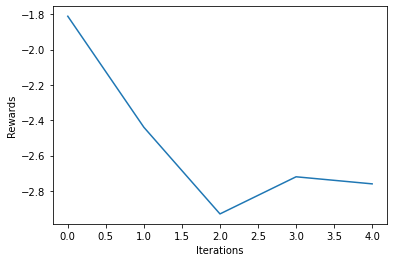

  1%|▍                                                                            | 614/100000 [00:07<25:07, 65.93it/s]

Updated Weights
Mean Reward = -1.74
7


  1%|▌                                                                            | 708/100000 [00:08<25:00, 66.17it/s]

Updated Weights
Mean Reward = -1.39
12


  1%|▌                                                                            | 807/100000 [00:10<29:36, 55.82it/s]

Updated Weights
Mean Reward = -1.2
9


  1%|▋                                                                            | 911/100000 [00:12<28:33, 57.82it/s]

Updated Weights
Mean Reward = -1.15
3


  1%|▊                                                                            | 998/100000 [00:13<29:34, 55.80it/s]

Updated Weights
Mean Reward = -0.21
9


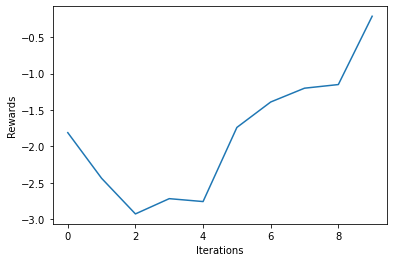

  1%|▊                                                                           | 1111/100000 [00:15<33:18, 49.47it/s]

Updated Weights
Mean Reward = -0.57
11


  1%|▉                                                                           | 1207/100000 [00:17<34:10, 48.18it/s]

Updated Weights
Mean Reward = 1.96
8


  1%|▉                                                                           | 1309/100000 [00:20<36:03, 45.62it/s]

Updated Weights
Mean Reward = 0.36
5


  1%|█                                                                           | 1407/100000 [00:22<34:23, 47.77it/s]

Updated Weights
Mean Reward = 1.04
14


  1%|█▏                                                                          | 1498/100000 [00:24<35:34, 46.16it/s]

Updated Weights
Mean Reward = 0.33
6


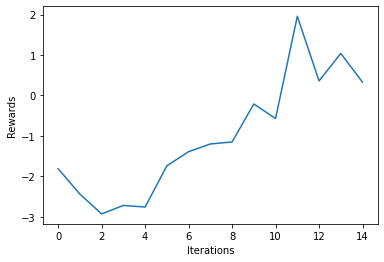

  2%|█▏                                                                          | 1606/100000 [00:27<40:19, 40.67it/s]

Updated Weights
Mean Reward = 1.02
5


  2%|█▎                                                                          | 1704/100000 [00:29<39:33, 41.42it/s]

Updated Weights
Mean Reward = 1.24
4


  2%|█▎                                                                          | 1806/100000 [00:31<39:11, 41.76it/s]

Updated Weights
Mean Reward = 0.19
7


  2%|█▍                                                                          | 1907/100000 [00:34<43:02, 37.99it/s]

Updated Weights
Mean Reward = 0.18
5


  2%|█▌                                                                          | 1998/100000 [00:36<42:36, 38.33it/s]

Updated Weights
Mean Reward = 1.05
5


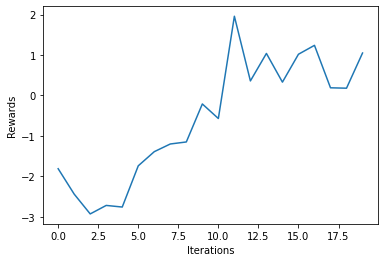

  2%|█▌                                                                          | 2105/100000 [00:39<45:23, 35.95it/s]

Updated Weights
Mean Reward = 0.46
8


  2%|█▋                                                                          | 2207/100000 [00:42<46:37, 34.95it/s]

Updated Weights
Mean Reward = -2.63
4


  2%|█▊                                                                          | 2308/100000 [00:45<43:58, 37.02it/s]

Updated Weights
Mean Reward = 1.27
6


  2%|█▊                                                                          | 2407/100000 [00:48<46:34, 34.92it/s]

Updated Weights
Mean Reward = 1.92
6


  2%|█▉                                                                          | 2497/100000 [00:50<44:48, 36.26it/s]

Updated Weights
Mean Reward = 1.46
3


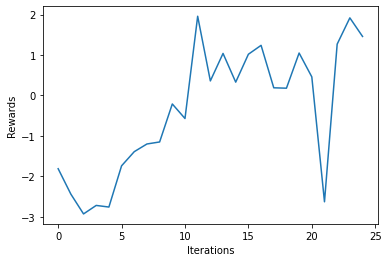

  3%|█▉                                                                          | 2605/100000 [00:53<47:30, 34.17it/s]

Updated Weights
Mean Reward = 2.58
2


  3%|██                                                                          | 2706/100000 [00:56<50:45, 31.94it/s]

Updated Weights
Mean Reward = 1.77
6


  3%|██▏                                                                         | 2806/100000 [00:59<51:31, 31.44it/s]

Updated Weights
Mean Reward = 1.98
4


  3%|██▏                                                                         | 2906/100000 [01:03<49:21, 32.78it/s]

Updated Weights
Mean Reward = 2.02
3


  3%|██▎                                                                         | 2998/100000 [01:05<45:00, 35.92it/s]

Updated Weights
Mean Reward = 3.4
7


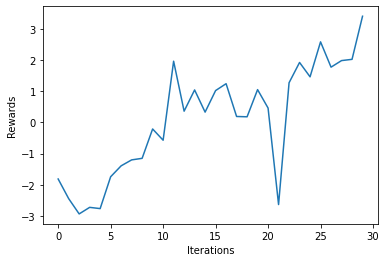

  3%|██▎                                                                         | 3106/100000 [01:09<50:53, 31.73it/s]

Updated Weights
Mean Reward = 2.11
12


  3%|██▎                                                                       | 3204/100000 [01:13<1:26:44, 18.60it/s]

Updated Weights
Mean Reward = 3.58
13


  3%|██▍                                                                       | 3304/100000 [01:17<1:07:06, 24.02it/s]

Updated Weights
Mean Reward = 0.61
9


  3%|██▌                                                                         | 3405/100000 [01:21<59:02, 27.27it/s]

Updated Weights
Mean Reward = 0.36
2


  3%|██▋                                                                         | 3498/100000 [01:24<53:07, 30.28it/s]

Updated Weights
Mean Reward = 2.09
13


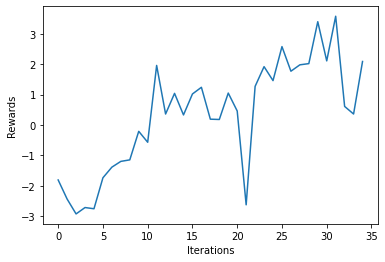

  4%|██▋                                                                         | 3605/100000 [01:28<50:46, 31.64it/s]

Updated Weights
Mean Reward = 2.17
9


  4%|██▊                                                                         | 3706/100000 [01:31<54:35, 29.39it/s]

Updated Weights
Mean Reward = 2.96
8


  4%|██▊                                                                       | 3804/100000 [01:35<1:01:20, 26.14it/s]

Updated Weights
Mean Reward = -0.31
10


  4%|██▉                                                                       | 3905/100000 [01:38<1:06:48, 23.97it/s]

Updated Weights
Mean Reward = 4.08
10


  4%|███                                                                         | 3999/100000 [01:42<57:20, 27.90it/s]

Updated Weights
Mean Reward = 1.35
2


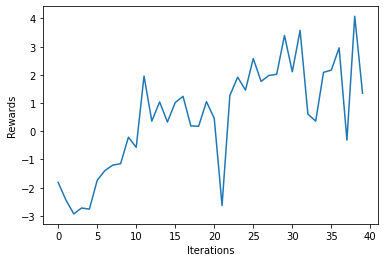

  4%|███                                                                       | 4103/100000 [01:47<1:23:55, 19.05it/s]

Updated Weights
Mean Reward = 1.89
6


  4%|███▏                                                                        | 4206/100000 [01:51<57:55, 27.56it/s]

Updated Weights
Mean Reward = 2.86
5


  4%|███▎                                                                        | 4306/100000 [01:54<54:49, 29.09it/s]

Updated Weights
Mean Reward = 1.93
11


  4%|███▎                                                                        | 4406/100000 [01:58<56:38, 28.13it/s]

Updated Weights
Mean Reward = -1.47
2


  4%|███▎                                                                      | 4498/100000 [02:02<1:00:17, 26.40it/s]

Updated Weights
Mean Reward = 1.79
6


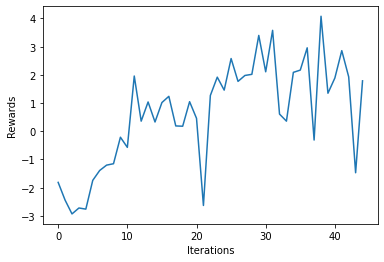

  5%|███▍                                                                        | 4604/100000 [02:06<55:07, 28.84it/s]

Updated Weights
Mean Reward = 2.22
5


  5%|███▍                                                                      | 4704/100000 [02:10<1:02:45, 25.31it/s]

Updated Weights
Mean Reward = 2.55
5


  5%|███▋                                                                        | 4804/100000 [02:14<57:00, 27.83it/s]

Updated Weights
Mean Reward = 3.39
9


  5%|███▋                                                                        | 4905/100000 [02:17<56:35, 28.00it/s]

Updated Weights
Mean Reward = 3.96
8


  5%|███▊                                                                        | 4998/100000 [02:21<57:06, 27.73it/s]

Updated Weights
Mean Reward = 5.03
11


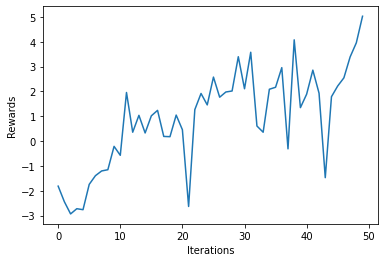

  5%|███▉                                                                        | 5103/100000 [02:26<57:17, 27.61it/s]

Updated Weights
Mean Reward = 0.76
8


  5%|███▊                                                                      | 5203/100000 [02:30<1:25:22, 18.51it/s]

Updated Weights
Mean Reward = 3.82
8


  5%|███▉                                                                      | 5302/100000 [02:35<1:08:04, 23.18it/s]

Updated Weights
Mean Reward = 3.58
3


  5%|███▉                                                                      | 5404/100000 [02:39<1:14:31, 21.16it/s]

Updated Weights
Mean Reward = 2.17
9


  5%|████                                                                      | 5499/100000 [02:44<1:24:03, 18.74it/s]

Updated Weights
Mean Reward = -0.22
3


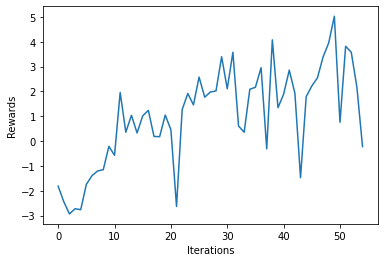

  6%|████▏                                                                     | 5606/100000 [02:49<1:00:04, 26.19it/s]

Updated Weights
Mean Reward = 0.68
8


  6%|████▎                                                                       | 5706/100000 [02:53<57:32, 27.31it/s]

Updated Weights
Mean Reward = 4.87
11


  6%|████▎                                                                     | 5803/100000 [02:57<1:09:19, 22.65it/s]

Updated Weights
Mean Reward = 4.18
4


  6%|████▎                                                                     | 5905/100000 [03:01<1:00:55, 25.74it/s]

Updated Weights
Mean Reward = 5.18
10


  6%|████▌                                                                       | 6000/100000 [03:05<58:36, 26.73it/s]

Updated Weights
Mean Reward = 0.57
3


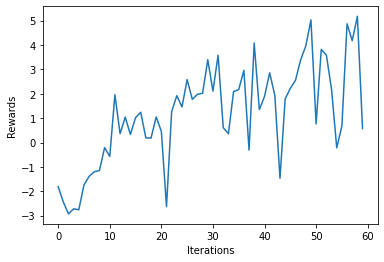

  6%|████▋                                                                       | 6103/100000 [03:09<53:44, 29.12it/s]

Updated Weights
Mean Reward = 3.54
10


  6%|████▌                                                                     | 6206/100000 [03:13<1:00:44, 25.74it/s]

Updated Weights
Mean Reward = 3.31
8


  6%|████▊                                                                       | 6305/100000 [03:16<55:30, 28.13it/s]

Updated Weights
Mean Reward = 4.9
8


  6%|████▋                                                                     | 6404/100000 [03:20<1:04:18, 24.26it/s]

Updated Weights
Mean Reward = 4.89
9


  6%|████▊                                                                     | 6499/100000 [03:24<1:03:53, 24.39it/s]

Updated Weights
Mean Reward = 4.55
7


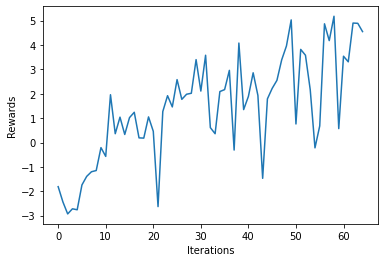

  7%|████▉                                                                     | 6606/100000 [03:29<1:01:31, 25.30it/s]

Updated Weights
Mean Reward = 0.88
7


  7%|█████                                                                       | 6705/100000 [03:33<57:17, 27.14it/s]

Updated Weights
Mean Reward = 3.98
14


  7%|█████▏                                                                      | 6806/100000 [03:37<58:44, 26.44it/s]

Updated Weights
Mean Reward = 2.2
4


  7%|█████▏                                                                      | 6906/100000 [03:41<58:52, 26.35it/s]

Updated Weights
Mean Reward = 1.58
10


  7%|█████▏                                                                    | 6999/100000 [03:46<1:15:07, 20.63it/s]

Updated Weights
Mean Reward = -0.59
8


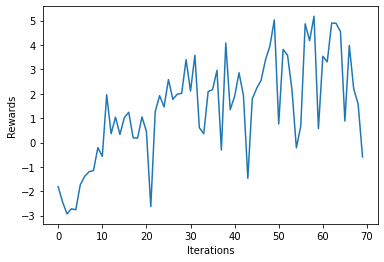

  7%|█████▎                                                                    | 7103/100000 [03:50<1:06:27, 23.30it/s]

Updated Weights
Mean Reward = 2.0
7


  7%|█████▎                                                                    | 7204/100000 [03:55<1:18:01, 19.82it/s]

Updated Weights
Mean Reward = -0.14
5


  7%|█████▍                                                                    | 7304/100000 [04:00<1:17:26, 19.95it/s]

Updated Weights
Mean Reward = 2.03
7


  7%|█████▍                                                                    | 7401/100000 [04:04<1:10:32, 21.88it/s]

Updated Weights
Mean Reward = 3.05
11


  7%|█████▌                                                                    | 7499/100000 [04:08<1:02:46, 24.56it/s]

Updated Weights
Mean Reward = 1.82
8


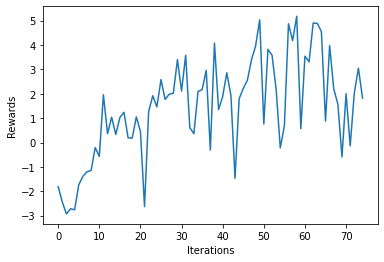

  8%|█████▋                                                                    | 7605/100000 [04:13<1:00:22, 25.50it/s]

Updated Weights
Mean Reward = 2.58
8


  8%|█████▊                                                                      | 7706/100000 [04:16<54:14, 28.36it/s]

Updated Weights
Mean Reward = 2.85
9


  8%|█████▉                                                                      | 7808/100000 [04:20<51:49, 29.65it/s]

Updated Weights
Mean Reward = 3.77
10


  8%|██████                                                                      | 7905/100000 [04:23<54:51, 27.98it/s]

Updated Weights
Mean Reward = 2.79
6


  8%|█████▉                                                                    | 7999/100000 [04:27<1:00:23, 25.39it/s]

Updated Weights
Mean Reward = 4.17
9


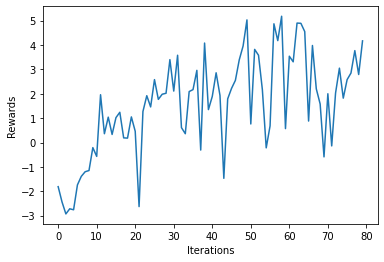

  8%|█████▉                                                                    | 8105/100000 [04:31<1:01:03, 25.08it/s]

Updated Weights
Mean Reward = 4.79
12


  8%|██████▏                                                                     | 8205/100000 [04:35<54:41, 27.97it/s]

Updated Weights
Mean Reward = 4.18
8


  8%|██████▏                                                                   | 8303/100000 [04:39<1:02:46, 24.35it/s]

Updated Weights
Mean Reward = 3.65
8


  8%|██████▍                                                                     | 8405/100000 [04:43<54:45, 27.88it/s]

Updated Weights
Mean Reward = 3.29
10


  8%|██████▍                                                                     | 8500/100000 [04:46<59:37, 25.58it/s]

Updated Weights
Mean Reward = 3.23
4


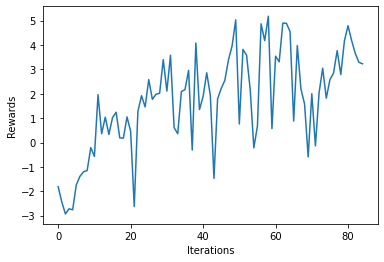

  9%|██████▌                                                                     | 8607/100000 [04:50<53:58, 28.22it/s]

Updated Weights
Mean Reward = 4.18
11


  9%|██████▌                                                                     | 8707/100000 [04:54<55:17, 27.52it/s]

Updated Weights
Mean Reward = 1.68
8


  9%|██████▋                                                                     | 8804/100000 [04:58<55:10, 27.55it/s]

Updated Weights
Mean Reward = 3.45
8


  9%|██████▊                                                                     | 8907/100000 [05:02<50:43, 29.93it/s]

Updated Weights
Mean Reward = -0.87
3


  9%|██████▊                                                                     | 8999/100000 [05:05<58:52, 25.76it/s]

Updated Weights
Mean Reward = 0.84
5


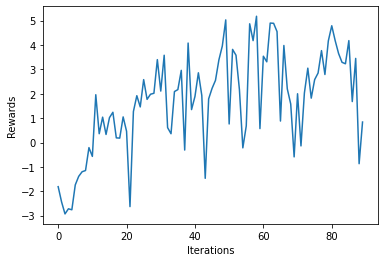

  9%|██████▉                                                                     | 9107/100000 [05:09<55:57, 27.07it/s]

Updated Weights
Mean Reward = 3.41
5


  9%|██████▉                                                                     | 9205/100000 [05:13<55:22, 27.32it/s]

Updated Weights
Mean Reward = 2.92
9


  9%|███████                                                                     | 9307/100000 [05:16<53:50, 28.07it/s]

Updated Weights
Mean Reward = 2.78
6


  9%|███████▏                                                                    | 9406/100000 [05:20<55:00, 27.45it/s]

Updated Weights
Mean Reward = 5.32
14


 10%|███████▏                                                                    | 9500/100000 [05:23<51:39, 29.20it/s]

Updated Weights
Mean Reward = 3.31
6


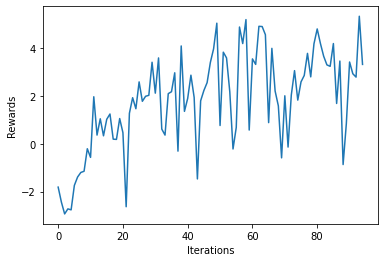

 10%|███████▎                                                                    | 9605/100000 [05:27<54:08, 27.83it/s]

Updated Weights
Mean Reward = 2.92
6


 10%|███████▏                                                                  | 9703/100000 [05:31<1:08:52, 21.85it/s]

Updated Weights
Mean Reward = -0.02
3


 10%|███████▎                                                                  | 9804/100000 [05:36<1:17:46, 19.33it/s]

Updated Weights
Mean Reward = 2.52
5


 10%|███████▌                                                                    | 9904/100000 [05:41<59:49, 25.10it/s]

Updated Weights
Mean Reward = 2.99
5


 10%|███████▎                                                                 | 10000/100000 [05:45<1:03:21, 23.68it/s]

Updated Weights
Mean Reward = 4.03
4


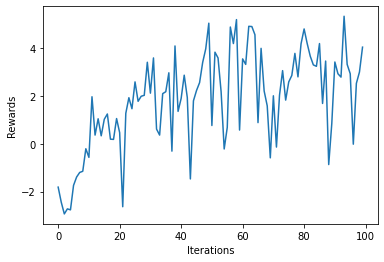

 10%|███████▌                                                                   | 10104/100000 [05:49<58:12, 25.74it/s]

Updated Weights
Mean Reward = 3.65
4


 10%|███████▍                                                                 | 10203/100000 [05:53<1:13:34, 20.34it/s]

Updated Weights
Mean Reward = 3.76
6


 10%|███████▋                                                                   | 10307/100000 [05:57<52:07, 28.68it/s]

Updated Weights
Mean Reward = 4.09
10


 10%|███████▊                                                                   | 10403/100000 [06:01<53:23, 27.96it/s]

Updated Weights
Mean Reward = 2.69
10


 10%|███████▊                                                                   | 10498/100000 [06:04<53:28, 27.89it/s]

Updated Weights
Mean Reward = 2.59
6


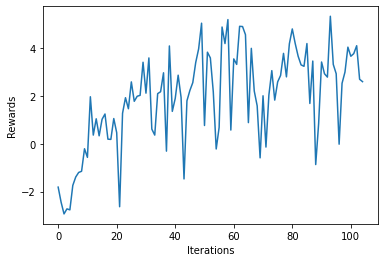

 11%|███████▉                                                                   | 10605/100000 [06:08<54:03, 27.56it/s]

Updated Weights
Mean Reward = 3.9
7


 11%|████████                                                                   | 10705/100000 [06:12<53:04, 28.04it/s]

Updated Weights
Mean Reward = 2.8
11


 11%|████████                                                                   | 10806/100000 [06:15<55:28, 26.80it/s]

Updated Weights
Mean Reward = 2.29
7


 11%|████████▏                                                                  | 10906/100000 [06:19<53:24, 27.80it/s]

Updated Weights
Mean Reward = 4.2
7


 11%|████████▏                                                                  | 10999/100000 [06:22<55:55, 26.53it/s]

Updated Weights
Mean Reward = 1.45
9


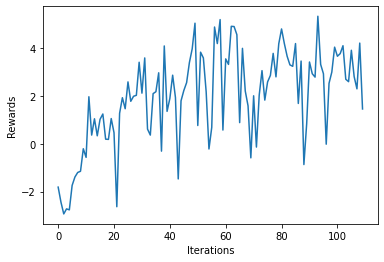

 11%|████████▎                                                                  | 11105/100000 [06:26<50:01, 29.62it/s]

Updated Weights
Mean Reward = 2.67
9


 11%|████████▍                                                                  | 11204/100000 [06:30<54:26, 27.18it/s]

Updated Weights
Mean Reward = 3.67
5


 11%|████████▍                                                                  | 11304/100000 [06:33<55:10, 26.80it/s]

Updated Weights
Mean Reward = 4.74
8


 11%|████████▌                                                                  | 11403/100000 [06:37<55:56, 26.40it/s]

Updated Weights
Mean Reward = 4.37
9


 11%|████████▌                                                                  | 11499/100000 [06:41<55:33, 26.55it/s]

Updated Weights
Mean Reward = 0.36
3


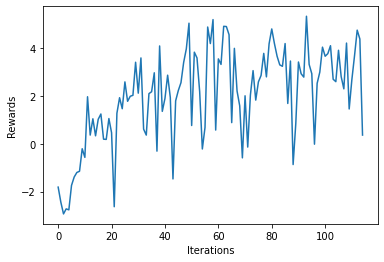

 12%|████████▋                                                                  | 11605/100000 [06:45<54:46, 26.89it/s]

Updated Weights
Mean Reward = 3.63
5


 12%|████████▊                                                                  | 11706/100000 [06:48<55:38, 26.45it/s]

Updated Weights
Mean Reward = 3.8
11


 12%|████████▊                                                                  | 11805/100000 [06:52<53:22, 27.54it/s]

Updated Weights
Mean Reward = 2.99
2


 12%|████████▉                                                                  | 11904/100000 [06:56<55:04, 26.66it/s]

Updated Weights
Mean Reward = 4.19
5


 12%|████████▉                                                                  | 11999/100000 [06:59<56:21, 26.02it/s]

Updated Weights
Mean Reward = 2.49
7


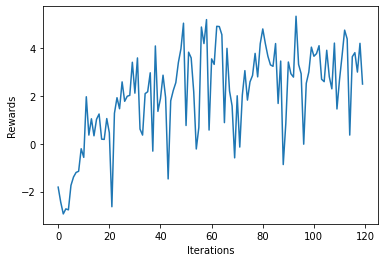

 12%|█████████                                                                  | 12104/100000 [07:03<52:39, 27.82it/s]

Updated Weights
Mean Reward = -2.61
5


 12%|█████████▏                                                                 | 12205/100000 [07:07<53:18, 27.45it/s]

Updated Weights
Mean Reward = 2.01
8


 12%|█████████▏                                                                 | 12306/100000 [07:10<51:12, 28.55it/s]

Updated Weights
Mean Reward = 4.02
7


 12%|█████████▎                                                                 | 12404/100000 [07:14<50:03, 29.16it/s]

Updated Weights
Mean Reward = 4.05
9


 12%|█████████▎                                                                 | 12498/100000 [07:17<51:26, 28.35it/s]

Updated Weights
Mean Reward = 4.03
8


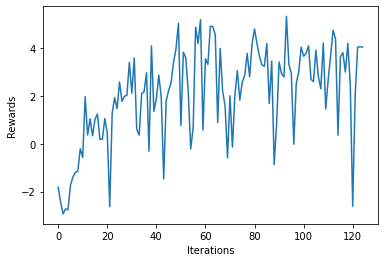

 13%|█████████▍                                                                 | 12604/100000 [07:21<54:45, 26.60it/s]

Updated Weights
Mean Reward = 3.35
4


 13%|█████████▎                                                               | 12703/100000 [07:25<1:18:07, 18.62it/s]

Updated Weights
Mean Reward = 5.42
16


 13%|█████████▌                                                                 | 12803/100000 [07:29<58:20, 24.91it/s]

Updated Weights
Mean Reward = 4.49
14


 13%|█████████▍                                                               | 12903/100000 [07:34<1:10:18, 20.65it/s]

Updated Weights
Mean Reward = 4.19
5


 13%|█████████▍                                                               | 12999/100000 [07:39<1:50:03, 13.17it/s]

Updated Weights
Mean Reward = 3.88
5


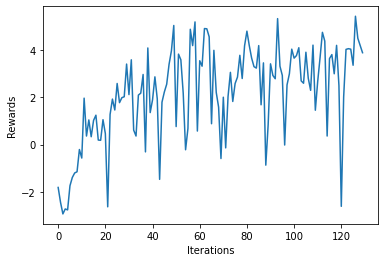

 13%|█████████▌                                                               | 13102/100000 [07:45<1:20:13, 18.05it/s]

Updated Weights
Mean Reward = 4.45
7


 13%|█████████▉                                                                 | 13205/100000 [07:50<52:00, 27.81it/s]

Updated Weights
Mean Reward = 1.26
3


 13%|█████████▉                                                                 | 13305/100000 [07:54<47:29, 30.42it/s]

Updated Weights
Mean Reward = 4.36
9


 13%|██████████                                                                 | 13406/100000 [07:57<52:03, 27.72it/s]

Updated Weights
Mean Reward = 2.59
13


 14%|██████████▏                                                                | 13500/100000 [08:00<47:29, 30.36it/s]

Updated Weights
Mean Reward = 1.15
7


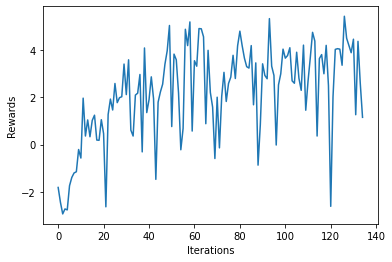

 14%|██████████▏                                                                | 13605/100000 [08:04<52:23, 27.49it/s]

Updated Weights
Mean Reward = 2.81
4


 14%|██████████▎                                                                | 13705/100000 [08:08<51:08, 28.12it/s]

Updated Weights
Mean Reward = 4.08
7


 14%|██████████▎                                                                | 13806/100000 [08:12<50:09, 28.64it/s]

Updated Weights
Mean Reward = 2.51
2


 14%|██████████▍                                                                | 13904/100000 [08:15<54:42, 26.23it/s]

Updated Weights
Mean Reward = 3.36
9


 14%|██████████▍                                                                | 13999/100000 [08:19<51:21, 27.91it/s]

Updated Weights
Mean Reward = -0.87
6


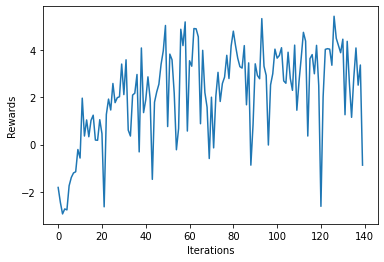

 14%|██████████▎                                                              | 14102/100000 [08:23<1:39:33, 14.38it/s]

Updated Weights
Mean Reward = 0.08
5


 14%|██████████▋                                                                | 14204/100000 [08:27<49:51, 28.68it/s]

Updated Weights
Mean Reward = 5.09
11


 14%|██████████▋                                                                | 14306/100000 [08:31<46:43, 30.56it/s]

Updated Weights
Mean Reward = 3.86
9


 14%|██████████▊                                                                | 14404/100000 [08:34<52:24, 27.22it/s]

Updated Weights
Mean Reward = 4.2
7


 14%|██████████▊                                                                | 14497/100000 [08:37<54:40, 26.06it/s]

Updated Weights
Mean Reward = 3.69
7


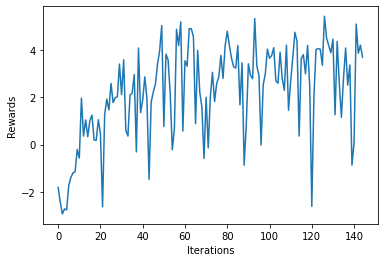

 15%|██████████▉                                                                | 14606/100000 [08:41<51:50, 27.45it/s]

Updated Weights
Mean Reward = 3.51
7


 15%|███████████                                                                | 14703/100000 [08:45<50:30, 28.14it/s]

Updated Weights
Mean Reward = 4.88
9


 15%|███████████                                                                | 14804/100000 [08:49<51:00, 27.83it/s]

Updated Weights
Mean Reward = 4.39
11


 15%|███████████▏                                                               | 14904/100000 [08:52<57:49, 24.52it/s]

Updated Weights
Mean Reward = 5.21
12


 15%|███████████▏                                                               | 14999/100000 [08:56<54:12, 26.13it/s]

Updated Weights
Mean Reward = 2.74
7


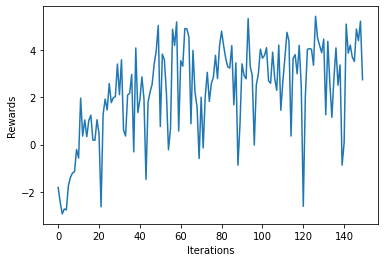

 15%|███████████▎                                                               | 15104/100000 [09:00<55:18, 25.59it/s]

Updated Weights
Mean Reward = 3.94
6


 15%|███████████▍                                                               | 15205/100000 [09:04<51:55, 27.22it/s]

Updated Weights
Mean Reward = 3.69
6


 15%|███████████▍                                                               | 15304/100000 [09:07<51:41, 27.31it/s]

Updated Weights
Mean Reward = 3.5
6


 15%|███████████▏                                                             | 15402/100000 [09:12<1:12:22, 19.48it/s]

Updated Weights
Mean Reward = 3.87
5


 16%|███████████▎                                                             | 15500/100000 [09:23<4:28:36,  5.24it/s]

Updated Weights
Mean Reward = 2.95
12


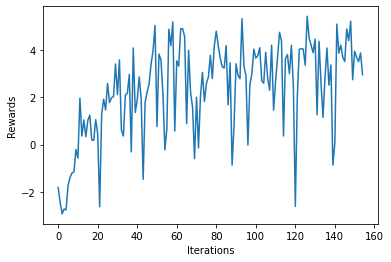

 16%|███████████▍                                                             | 15602/100000 [09:35<3:08:02,  7.48it/s]

Updated Weights
Mean Reward = 2.92
9


 16%|███████████▍                                                             | 15703/100000 [09:43<1:27:17, 16.09it/s]

Updated Weights
Mean Reward = 4.33
9


 16%|███████████▌                                                             | 15803/100000 [09:49<1:19:15, 17.70it/s]

Updated Weights
Mean Reward = 3.28
7


 16%|███████████▉                                                               | 15904/100000 [09:53<53:55, 25.99it/s]

Updated Weights
Mean Reward = 0.61
10


 16%|███████████▋                                                             | 15998/100000 [09:57<1:01:56, 22.60it/s]

Updated Weights
Mean Reward = 3.33
6


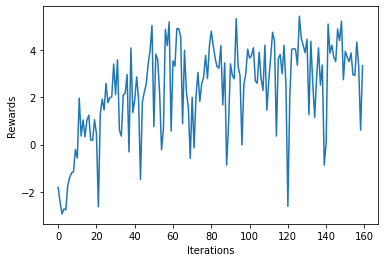

 16%|████████████                                                               | 16105/100000 [10:01<48:59, 28.54it/s]

Updated Weights
Mean Reward = 1.67
13


 16%|████████████▏                                                              | 16204/100000 [10:05<56:35, 24.68it/s]

Updated Weights
Mean Reward = 3.13
5


 16%|████████████▏                                                              | 16303/100000 [10:09<56:04, 24.88it/s]

Updated Weights
Mean Reward = 2.77
4


 16%|████████████▎                                                              | 16406/100000 [10:14<56:23, 24.70it/s]

Updated Weights
Mean Reward = 2.51
2


 16%|████████████▎                                                              | 16498/100000 [10:18<54:15, 25.65it/s]

Updated Weights
Mean Reward = 3.15
4


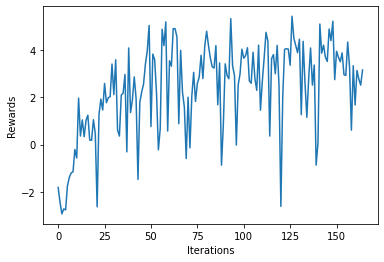

 17%|████████████                                                             | 16602/100000 [10:23<1:03:26, 21.91it/s]

Updated Weights
Mean Reward = 4.63
9


 17%|████████████▏                                                            | 16704/100000 [10:27<1:01:17, 22.65it/s]

Updated Weights
Mean Reward = 4.08
9


 17%|████████████▌                                                              | 16803/100000 [10:32<57:28, 24.13it/s]

Updated Weights
Mean Reward = 2.78
7


 17%|████████████▎                                                            | 16904/100000 [10:36<1:02:56, 22.00it/s]

Updated Weights
Mean Reward = 3.12
10


 17%|████████████▊                                                              | 17000/100000 [10:40<59:48, 23.13it/s]

Updated Weights
Mean Reward = 3.04
9


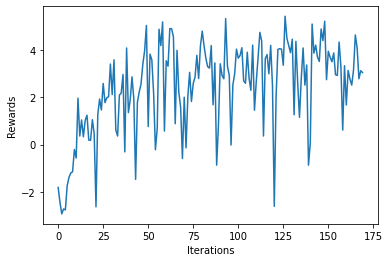

 17%|████████████▊                                                              | 17107/100000 [10:44<42:30, 32.49it/s]

Updated Weights
Mean Reward = 3.04
9


 17%|████████████▉                                                              | 17205/100000 [10:48<50:13, 27.48it/s]

Updated Weights
Mean Reward = 4.19
14


 17%|████████████▉                                                              | 17304/100000 [10:51<50:32, 27.27it/s]

Updated Weights
Mean Reward = 4.76
7


 17%|█████████████                                                              | 17406/100000 [10:55<49:04, 28.05it/s]

Updated Weights
Mean Reward = 3.49
7


 17%|█████████████                                                              | 17498/100000 [10:58<44:24, 30.97it/s]

Updated Weights
Mean Reward = 4.7
8


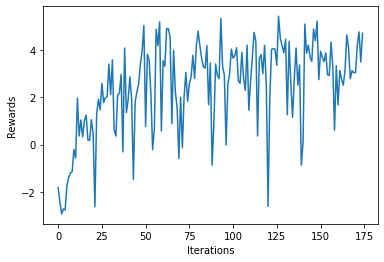

 18%|█████████████▏                                                             | 17606/100000 [11:02<55:21, 24.81it/s]

Updated Weights
Mean Reward = 4.84
8


 18%|█████████████▎                                                             | 17704/100000 [11:05<47:18, 28.99it/s]

Updated Weights
Mean Reward = 4.68
9


 18%|█████████████▎                                                             | 17804/100000 [11:09<49:13, 27.83it/s]

Updated Weights
Mean Reward = 3.93
7


 18%|█████████████▍                                                             | 17905/100000 [11:12<49:01, 27.91it/s]

Updated Weights
Mean Reward = 3.33
10


 18%|█████████████▌                                                             | 18000/100000 [11:16<53:31, 25.53it/s]

Updated Weights
Mean Reward = 3.75
4


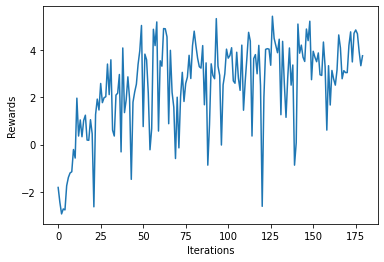

 18%|█████████████▌                                                             | 18105/100000 [11:20<53:31, 25.50it/s]

Updated Weights
Mean Reward = 4.31
4


 18%|█████████████▋                                                             | 18206/100000 [11:24<49:20, 27.63it/s]

Updated Weights
Mean Reward = 4.23
8


 18%|█████████████▋                                                             | 18304/100000 [11:27<48:57, 27.81it/s]

Updated Weights
Mean Reward = 1.72
11


 18%|█████████████▊                                                             | 18404/100000 [11:31<52:34, 25.87it/s]

Updated Weights
Mean Reward = 3.79
6


 18%|█████████████▉                                                             | 18500/100000 [11:34<49:48, 27.27it/s]

Updated Weights
Mean Reward = 3.12
4


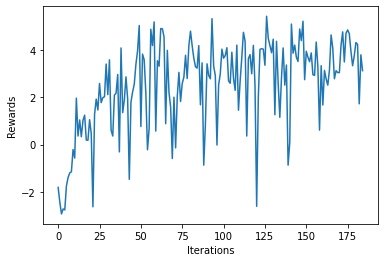

 19%|█████████████▉                                                             | 18606/100000 [11:38<49:39, 27.32it/s]

Updated Weights
Mean Reward = 0.86
10


 19%|██████████████                                                             | 18705/100000 [11:42<49:34, 27.33it/s]

Updated Weights
Mean Reward = 3.59
6


 19%|██████████████                                                             | 18807/100000 [11:46<46:53, 28.86it/s]

Updated Weights
Mean Reward = 3.98
8


 19%|██████████████▏                                                            | 18905/100000 [11:50<48:27, 27.89it/s]

Updated Weights
Mean Reward = 4.62
6


 19%|██████████████▏                                                            | 18999/100000 [11:53<49:03, 27.51it/s]

Updated Weights
Mean Reward = 2.34
4


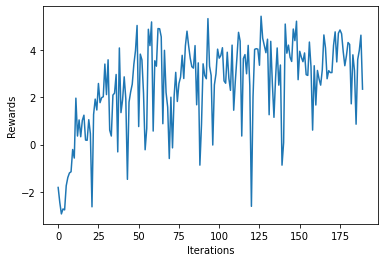

 19%|██████████████▎                                                            | 19101/100000 [11:57<56:21, 23.92it/s]

Updated Weights
Mean Reward = 3.24
3


 19%|██████████████▍                                                            | 19205/100000 [12:02<47:16, 28.48it/s]

Updated Weights
Mean Reward = 4.95
9


 19%|██████████████▍                                                            | 19305/100000 [12:05<48:40, 27.63it/s]

Updated Weights
Mean Reward = 2.86
5


 19%|██████████████▌                                                            | 19406/100000 [12:09<47:57, 28.01it/s]

Updated Weights
Mean Reward = 3.57
3


 19%|██████████████▌                                                            | 19498/100000 [12:12<47:16, 28.38it/s]

Updated Weights
Mean Reward = 3.9
6


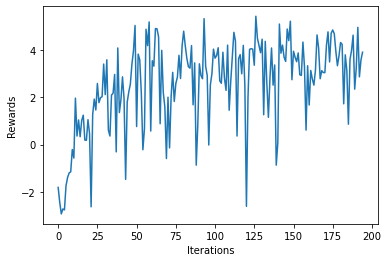

 20%|██████████████▋                                                            | 19606/100000 [12:16<45:11, 29.65it/s]

Updated Weights
Mean Reward = 3.55
8


 20%|██████████████▊                                                            | 19705/100000 [12:19<46:16, 28.92it/s]

Updated Weights
Mean Reward = 3.74
10


 20%|██████████████▊                                                            | 19804/100000 [12:23<50:01, 26.72it/s]

Updated Weights
Mean Reward = 2.76
1


 20%|██████████████▉                                                            | 19906/100000 [12:27<44:53, 29.74it/s]

Updated Weights
Mean Reward = 2.47
6


 20%|██████████████▉                                                            | 19999/100000 [12:30<48:06, 27.71it/s]

Updated Weights
Mean Reward = 4.58
11


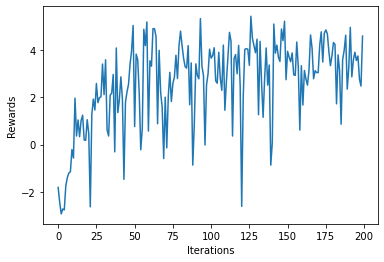

 20%|███████████████                                                            | 20106/100000 [12:34<52:38, 25.30it/s]

Updated Weights
Mean Reward = 2.97
5


 20%|███████████████▏                                                           | 20204/100000 [12:38<48:40, 27.32it/s]

Updated Weights
Mean Reward = 2.81
6


 20%|███████████████▏                                                           | 20305/100000 [12:42<50:01, 26.55it/s]

Updated Weights
Mean Reward = 0.78
2


 20%|███████████████▎                                                           | 20403/100000 [12:45<55:41, 23.82it/s]

Updated Weights
Mean Reward = 3.28
5


 20%|███████████████▎                                                           | 20498/100000 [12:49<46:39, 28.40it/s]

Updated Weights
Mean Reward = 4.54
7


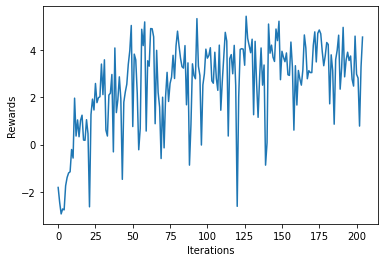

 21%|███████████████▍                                                           | 20606/100000 [12:52<47:49, 27.67it/s]

Updated Weights
Mean Reward = 3.87
6


 21%|███████████████▌                                                           | 20707/100000 [12:56<47:20, 27.91it/s]

Updated Weights
Mean Reward = 2.94
5


 21%|███████████████▌                                                           | 20806/100000 [13:00<47:36, 27.72it/s]

Updated Weights
Mean Reward = 2.56
6


 21%|███████████████▋                                                           | 20904/100000 [13:03<50:38, 26.04it/s]

Updated Weights
Mean Reward = 4.47
10


 21%|███████████████▊                                                           | 21000/100000 [13:07<47:56, 27.46it/s]

Updated Weights
Mean Reward = 3.56
4


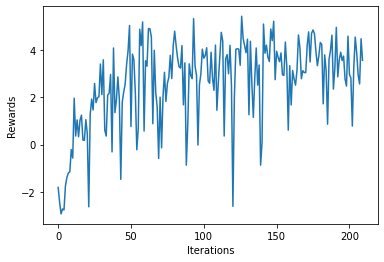

 21%|███████████████▊                                                           | 21104/100000 [13:11<50:11, 26.20it/s]

Updated Weights
Mean Reward = 0.16
4


 21%|███████████████▉                                                           | 21205/100000 [13:14<47:43, 27.51it/s]

Updated Weights
Mean Reward = 2.8
11


 21%|███████████████▉                                                           | 21306/100000 [13:18<43:08, 30.40it/s]

Updated Weights
Mean Reward = 3.94
10


 21%|████████████████                                                           | 21403/100000 [13:22<58:03, 22.56it/s]

Updated Weights
Mean Reward = 4.0
7


 22%|████████████████▏                                                          | 21500/100000 [13:26<45:52, 28.52it/s]

Updated Weights
Mean Reward = 4.16
6


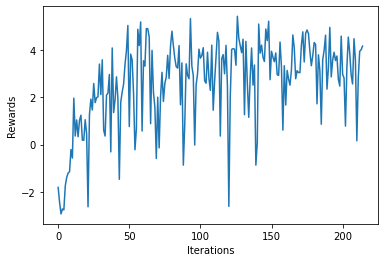

 22%|████████████████▏                                                          | 21604/100000 [13:31<50:17, 25.98it/s]

Updated Weights
Mean Reward = 2.63
11


 22%|████████████████▎                                                          | 21706/100000 [13:35<51:20, 25.42it/s]

Updated Weights
Mean Reward = 4.13
8


 22%|████████████████▎                                                          | 21804/100000 [13:39<52:22, 24.89it/s]

Updated Weights
Mean Reward = 3.27
9


 22%|████████████████▍                                                          | 21905/100000 [13:42<50:55, 25.56it/s]

Updated Weights
Mean Reward = 4.0
5


 22%|████████████████▍                                                          | 21998/100000 [13:46<44:00, 29.54it/s]

Updated Weights
Mean Reward = 3.79
7


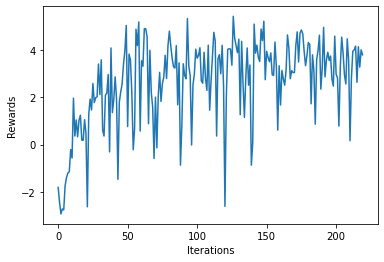

 22%|████████████████▌                                                          | 22106/100000 [13:50<46:15, 28.06it/s]

Updated Weights
Mean Reward = -2.32
7


 22%|████████████████▋                                                          | 22205/100000 [13:54<50:48, 25.52it/s]

Updated Weights
Mean Reward = 0.77
7


 22%|████████████████▋                                                          | 22305/100000 [13:59<55:44, 23.23it/s]

Updated Weights
Mean Reward = 3.23
6


 22%|████████████████▊                                                          | 22405/100000 [14:03<52:51, 24.46it/s]

Updated Weights
Mean Reward = 4.88
15


 22%|████████████████▊                                                          | 22498/100000 [14:06<49:45, 25.96it/s]

Updated Weights
Mean Reward = 4.9
16


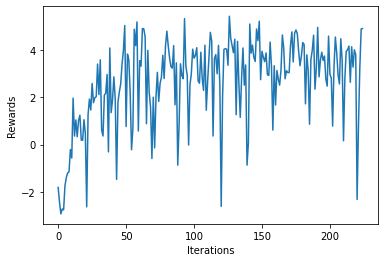

 23%|████████████████▉                                                          | 22605/100000 [14:10<45:57, 28.07it/s]

Updated Weights
Mean Reward = 5.23
12


 23%|█████████████████                                                          | 22705/100000 [14:14<42:56, 30.00it/s]

Updated Weights
Mean Reward = 3.77
6


 23%|█████████████████                                                          | 22804/100000 [14:17<47:24, 27.14it/s]

Updated Weights
Mean Reward = 4.85
11


 23%|████████████████▋                                                        | 22905/100000 [14:21<1:00:49, 21.13it/s]

Updated Weights
Mean Reward = 4.38
3


 23%|█████████████████▏                                                         | 22998/100000 [14:25<50:33, 25.39it/s]

Updated Weights
Mean Reward = 3.24
9


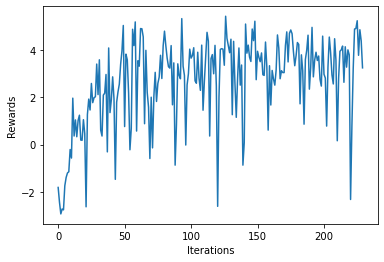

 23%|█████████████████▎                                                         | 23105/100000 [14:30<48:37, 26.36it/s]

Updated Weights
Mean Reward = 3.91
8


 23%|█████████████████▍                                                         | 23206/100000 [14:34<49:02, 26.10it/s]

Updated Weights
Mean Reward = 4.09
9


 23%|█████████████████▍                                                         | 23306/100000 [14:38<48:04, 26.59it/s]

Updated Weights
Mean Reward = 4.2
10


 23%|█████████████████▌                                                         | 23405/100000 [14:41<46:53, 27.23it/s]

Updated Weights
Mean Reward = 2.96
7


 23%|█████████████████▌                                                         | 23497/100000 [14:45<50:23, 25.30it/s]

Updated Weights
Mean Reward = 3.91
9


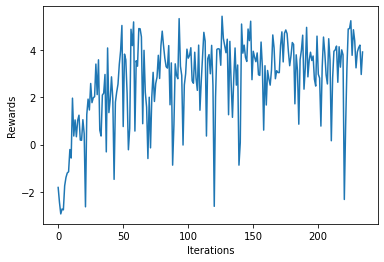

 24%|█████████████████▋                                                         | 23606/100000 [14:49<44:38, 28.52it/s]

Updated Weights
Mean Reward = 3.79
14


 24%|█████████████████▊                                                         | 23706/100000 [14:53<56:37, 22.45it/s]

Updated Weights
Mean Reward = 3.6
11


 24%|█████████████████▊                                                         | 23805/100000 [14:56<44:27, 28.57it/s]

Updated Weights
Mean Reward = 4.44
12


 24%|█████████████████▉                                                         | 23906/100000 [15:00<53:39, 23.63it/s]

Updated Weights
Mean Reward = 4.57
5


 24%|█████████████████▉                                                         | 23998/100000 [15:04<53:48, 23.54it/s]

Updated Weights
Mean Reward = 4.46
4


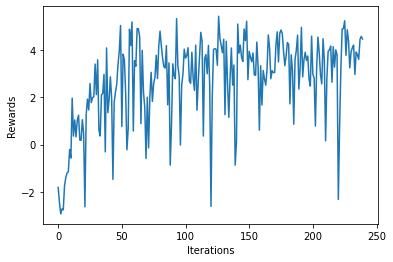

 24%|██████████████████                                                         | 24106/100000 [15:08<45:58, 27.51it/s]

Updated Weights
Mean Reward = 2.89
10


 24%|██████████████████▏                                                        | 24203/100000 [15:12<44:41, 28.27it/s]

Updated Weights
Mean Reward = 2.39
5


 24%|██████████████████▏                                                        | 24305/100000 [15:16<53:03, 23.77it/s]

Updated Weights
Mean Reward = 4.52
6


 24%|██████████████████▎                                                        | 24403/100000 [15:20<48:49, 25.80it/s]

Updated Weights
Mean Reward = 3.71
8


 24%|██████████████████▍                                                        | 24500/100000 [15:24<47:50, 26.30it/s]

Updated Weights
Mean Reward = 4.04
8


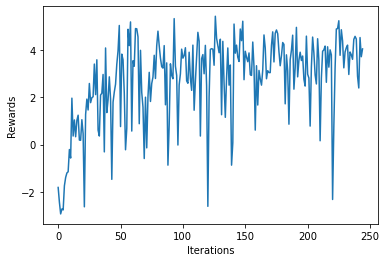

 25%|██████████████████▍                                                        | 24603/100000 [15:28<48:18, 26.01it/s]

Updated Weights
Mean Reward = 3.4
7


 25%|██████████████████▌                                                        | 24704/100000 [15:31<51:48, 24.22it/s]

Updated Weights
Mean Reward = 2.22
6


 25%|██████████████████▌                                                        | 24804/100000 [15:36<51:57, 24.12it/s]

Updated Weights
Mean Reward = 3.97
8


 25%|██████████████████▋                                                        | 24905/100000 [15:40<48:46, 25.66it/s]

Updated Weights
Mean Reward = 3.57
10


 25%|██████████████████▋                                                        | 24998/100000 [15:43<48:16, 25.89it/s]

Updated Weights
Mean Reward = 4.03
7


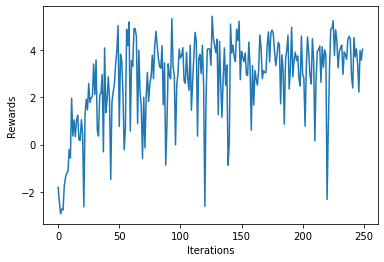

 25%|██████████████████▎                                                      | 25103/100000 [15:48<1:03:28, 19.67it/s]

Updated Weights
Mean Reward = 2.38
11


 25%|██████████████████▉                                                        | 25207/100000 [15:52<43:49, 28.45it/s]

Updated Weights
Mean Reward = 2.23
5


 25%|██████████████████▉                                                        | 25304/100000 [15:57<49:11, 25.31it/s]

Updated Weights
Mean Reward = 2.06
8


 25%|███████████████████                                                        | 25403/100000 [16:01<48:21, 25.71it/s]

Updated Weights
Mean Reward = 2.91
3


 26%|███████████████████▏                                                       | 25500/100000 [16:04<46:06, 26.93it/s]

Updated Weights
Mean Reward = 4.79
9


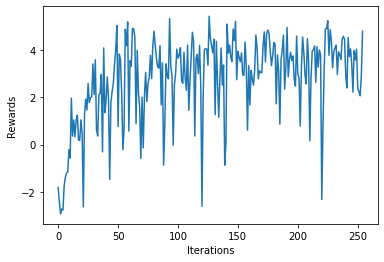

 26%|███████████████████▏                                                       | 25605/100000 [16:08<43:44, 28.35it/s]

Updated Weights
Mean Reward = 3.98
6


 26%|███████████████████▎                                                       | 25704/100000 [16:12<52:03, 23.79it/s]

Updated Weights
Mean Reward = 3.87
6


 26%|███████████████████▎                                                       | 25806/100000 [16:16<44:09, 28.00it/s]

Updated Weights
Mean Reward = 4.75
9


 26%|███████████████████▍                                                       | 25906/100000 [16:20<46:24, 26.61it/s]

Updated Weights
Mean Reward = 3.04
8


 26%|██████████████████▉                                                      | 26000/100000 [16:24<1:03:20, 19.47it/s]

Updated Weights
Mean Reward = 3.33
4


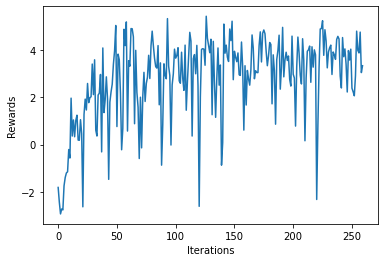

 26%|███████████████████▌                                                       | 26103/100000 [16:29<54:26, 22.62it/s]

Updated Weights
Mean Reward = 4.13
8


 26%|███████████████████▏                                                     | 26204/100000 [16:33<1:01:23, 20.03it/s]

Updated Weights
Mean Reward = 3.79
6


 26%|███████████████████▋                                                       | 26306/100000 [16:37<42:37, 28.82it/s]

Updated Weights
Mean Reward = 4.65
8


 26%|███████████████████▊                                                       | 26402/100000 [16:41<59:09, 20.74it/s]

Updated Weights
Mean Reward = 4.07
11


 26%|███████████████████▊                                                       | 26498/100000 [16:45<47:26, 25.82it/s]

Updated Weights
Mean Reward = 3.64
2


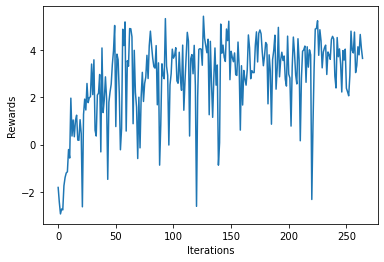

 27%|███████████████████▉                                                       | 26605/100000 [16:49<44:07, 27.73it/s]

Updated Weights
Mean Reward = 3.59
7


 27%|████████████████████                                                       | 26706/100000 [16:53<42:10, 28.96it/s]

Updated Weights
Mean Reward = 1.88
6


 27%|████████████████████                                                       | 26805/100000 [16:57<50:57, 23.94it/s]

Updated Weights
Mean Reward = 3.61
9


 27%|████████████████████▏                                                      | 26904/100000 [17:01<55:41, 21.88it/s]

Updated Weights
Mean Reward = 3.58
6


 27%|████████████████████▏                                                      | 26998/100000 [17:05<45:08, 26.95it/s]

Updated Weights
Mean Reward = 4.17
6


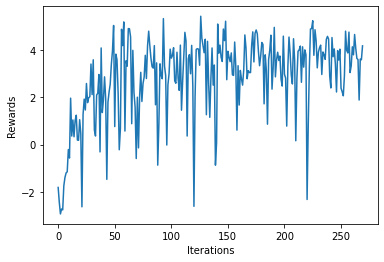

 27%|████████████████████▎                                                      | 27105/100000 [17:09<57:14, 21.22it/s]

Updated Weights
Mean Reward = 3.45
9


 27%|████████████████████▍                                                      | 27206/100000 [17:13<48:26, 25.04it/s]

Updated Weights
Mean Reward = 3.6
11


 27%|████████████████████▍                                                      | 27304/100000 [17:17<46:24, 26.11it/s]

Updated Weights
Mean Reward = 4.74
7


 27%|████████████████████▌                                                      | 27406/100000 [17:20<47:24, 25.52it/s]

Updated Weights
Mean Reward = 4.51
9


 28%|████████████████████▋                                                      | 27500/100000 [17:24<42:40, 28.32it/s]

Updated Weights
Mean Reward = 3.14
9


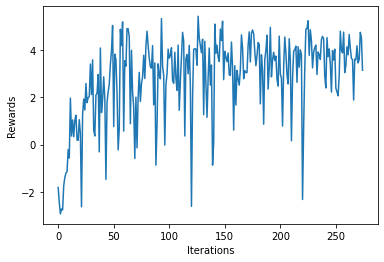

 28%|████████████████████▋                                                      | 27603/100000 [17:27<37:14, 32.40it/s]

Updated Weights
Mean Reward = 4.43
10


 28%|████████████████████▊                                                      | 27704/100000 [17:31<44:32, 27.05it/s]

Updated Weights
Mean Reward = 3.87
10


 28%|████████████████████▊                                                      | 27804/100000 [17:35<45:59, 26.16it/s]

Updated Weights
Mean Reward = 4.55
1


 28%|████████████████████▉                                                      | 27905/100000 [17:39<58:25, 20.56it/s]

Updated Weights
Mean Reward = 4.12
7


 28%|████████████████████▉                                                      | 27998/100000 [17:43<47:03, 25.50it/s]

Updated Weights
Mean Reward = 5.03
7


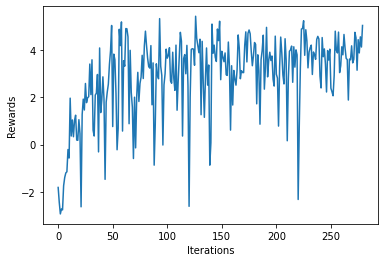

 28%|█████████████████████                                                      | 28106/100000 [17:47<45:50, 26.14it/s]

Updated Weights
Mean Reward = 3.0
7


 28%|█████████████████████▏                                                     | 28205/100000 [17:51<46:04, 25.97it/s]

Updated Weights
Mean Reward = 3.12
5


 28%|█████████████████████▏                                                     | 28306/100000 [17:55<43:37, 27.39it/s]

Updated Weights
Mean Reward = 0.25
3


 28%|█████████████████████▎                                                     | 28405/100000 [17:58<41:24, 28.82it/s]

Updated Weights
Mean Reward = 4.14
9


 28%|█████████████████████▎                                                     | 28499/100000 [18:02<43:08, 27.62it/s]

Updated Weights
Mean Reward = 4.58
6


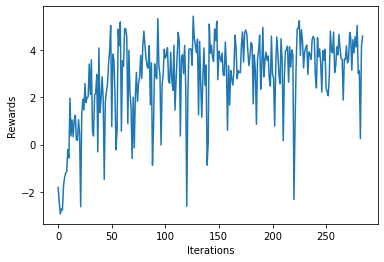

 29%|█████████████████████▍                                                     | 28606/100000 [18:05<42:58, 27.69it/s]

Updated Weights
Mean Reward = 5.31
10


 29%|█████████████████████▌                                                     | 28705/100000 [18:10<49:10, 24.17it/s]

Updated Weights
Mean Reward = 4.75
5


 29%|█████████████████████▌                                                     | 28806/100000 [18:14<42:09, 28.15it/s]

Updated Weights
Mean Reward = 3.82
10


 29%|█████████████████████▋                                                     | 28906/100000 [18:17<45:48, 25.87it/s]

Updated Weights
Mean Reward = 3.64
8


 29%|█████████████████████▊                                                     | 29000/100000 [18:21<40:40, 29.10it/s]

Updated Weights
Mean Reward = 3.44
6


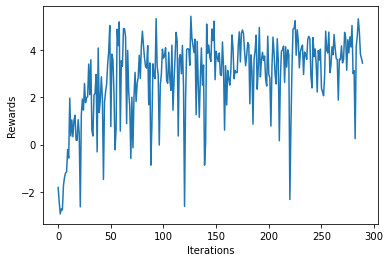

 29%|█████████████████████▊                                                     | 29104/100000 [18:25<43:29, 27.17it/s]

Updated Weights
Mean Reward = 1.16
8


 29%|█████████████████████▉                                                     | 29203/100000 [18:29<44:07, 26.74it/s]

Updated Weights
Mean Reward = 4.1
12


 29%|█████████████████████▉                                                     | 29304/100000 [18:32<43:03, 27.37it/s]

Updated Weights
Mean Reward = 4.45
8


 29%|█████████████████████▍                                                   | 29401/100000 [18:37<1:36:51, 12.15it/s]

Updated Weights
Mean Reward = 4.53
13


 29%|██████████████████████                                                     | 29499/100000 [18:42<50:38, 23.20it/s]

Updated Weights
Mean Reward = 3.39
2


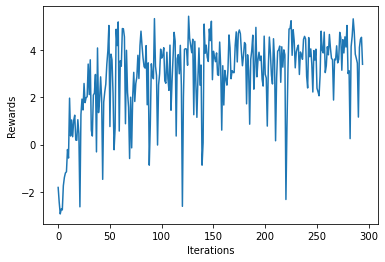

 30%|██████████████████████▏                                                    | 29604/100000 [18:46<49:53, 23.51it/s]

Updated Weights
Mean Reward = 3.98
5


 30%|██████████████████████▎                                                    | 29705/100000 [18:50<49:35, 23.63it/s]

Updated Weights
Mean Reward = 3.39
6


 30%|█████████████████████▊                                                   | 29804/100000 [18:55<1:00:20, 19.39it/s]

Updated Weights
Mean Reward = 2.91
6


 30%|██████████████████████▍                                                    | 29906/100000 [18:59<46:56, 24.88it/s]

Updated Weights
Mean Reward = 2.62
8


 30%|██████████████████████▌                                                    | 30000/100000 [19:03<48:36, 24.00it/s]

Updated Weights
Mean Reward = 4.5
14


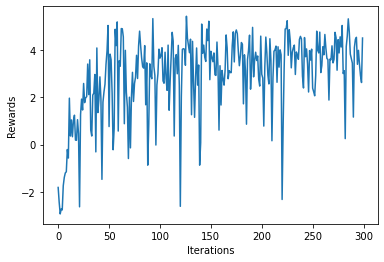

 30%|██████████████████████▌                                                    | 30105/100000 [19:07<43:22, 26.86it/s]

Updated Weights
Mean Reward = 4.74
9


 30%|██████████████████████▋                                                    | 30206/100000 [19:11<45:33, 25.53it/s]

Updated Weights
Mean Reward = 4.75
8


 30%|██████████████████████▋                                                    | 30305/100000 [19:15<42:36, 27.26it/s]

Updated Weights
Mean Reward = 3.12
4


 30%|██████████████████████▊                                                    | 30404/100000 [19:19<57:38, 20.12it/s]

Updated Weights
Mean Reward = 3.55
11


 30%|██████████████████████▊                                                    | 30498/100000 [19:23<54:55, 21.09it/s]

Updated Weights
Mean Reward = 4.45
7


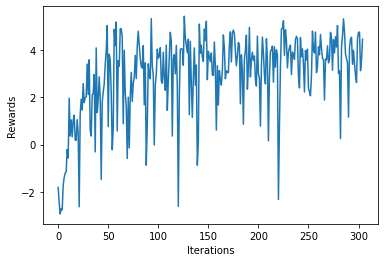

 31%|██████████████████████▉                                                    | 30605/100000 [19:28<44:32, 25.97it/s]

Updated Weights
Mean Reward = 4.53
5


 31%|███████████████████████                                                    | 30704/100000 [19:32<51:23, 22.47it/s]

Updated Weights
Mean Reward = 4.99
11


 31%|███████████████████████                                                    | 30804/100000 [19:36<45:03, 25.60it/s]

Updated Weights
Mean Reward = 4.49
7


 31%|███████████████████████▏                                                   | 30904/100000 [19:40<57:22, 20.07it/s]

Updated Weights
Mean Reward = 4.46
8


 31%|███████████████████████▎                                                   | 31000/100000 [19:44<50:38, 22.71it/s]

Updated Weights
Mean Reward = 4.09
9


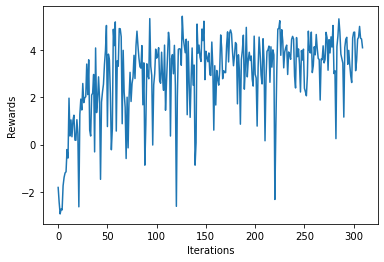

 31%|███████████████████████▎                                                   | 31104/100000 [19:49<44:41, 25.70it/s]

Updated Weights
Mean Reward = 3.86
7


 31%|███████████████████████▍                                                   | 31204/100000 [19:53<42:44, 26.83it/s]

Updated Weights
Mean Reward = 2.39
8


 31%|██████████████████████▊                                                  | 31301/100000 [19:58<1:29:43, 12.76it/s]

Updated Weights
Mean Reward = 3.52
7


 31%|███████████████████████▌                                                   | 31404/100000 [20:05<48:40, 23.49it/s]

Updated Weights
Mean Reward = -1.74
5


 32%|███████████████████████▋                                                   | 31500/100000 [20:09<43:00, 26.55it/s]

Updated Weights
Mean Reward = 2.99
10


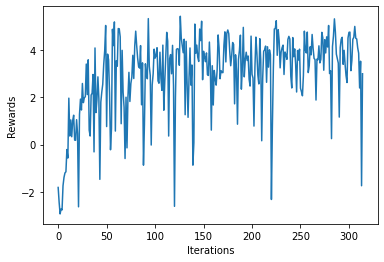

 32%|███████████████████████▋                                                   | 31605/100000 [20:13<40:43, 27.99it/s]

Updated Weights
Mean Reward = 4.75
14


 32%|███████████████████████▊                                                   | 31705/100000 [20:16<41:52, 27.18it/s]

Updated Weights
Mean Reward = 4.35
11


 32%|███████████████████████▊                                                   | 31806/100000 [20:20<43:46, 25.96it/s]

Updated Weights
Mean Reward = 3.73
8


 32%|███████████████████████▉                                                   | 31902/100000 [20:24<37:54, 29.95it/s]

Updated Weights
Mean Reward = 5.04
12


 32%|████████████████████████                                                   | 32000/100000 [20:27<42:16, 26.81it/s]

Updated Weights
Mean Reward = 4.15
7


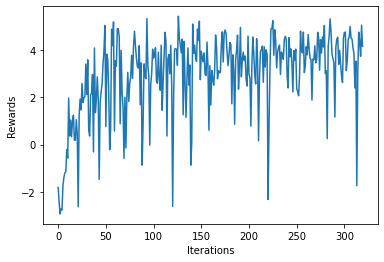

 32%|████████████████████████                                                   | 32104/100000 [20:32<45:19, 24.97it/s]

Updated Weights
Mean Reward = 5.09
11


 32%|████████████████████████▏                                                  | 32206/100000 [20:35<42:12, 26.77it/s]

Updated Weights
Mean Reward = 5.01
12


 32%|███████████████████████▌                                                 | 32303/100000 [20:40<1:10:03, 16.11it/s]

Updated Weights
Mean Reward = 4.64
8


 32%|████████████████████████▎                                                  | 32405/100000 [20:44<46:13, 24.37it/s]

Updated Weights
Mean Reward = 3.33
7


 32%|████████████████████████▎                                                  | 32499/100000 [20:48<39:29, 28.49it/s]

Updated Weights
Mean Reward = 5.43
10


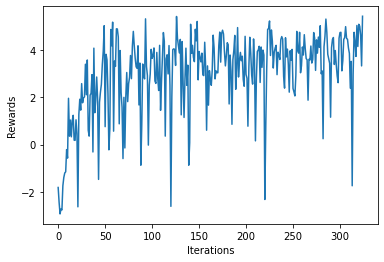

 33%|████████████████████████▍                                                  | 32603/100000 [20:52<47:12, 23.79it/s]

Updated Weights
Mean Reward = 5.53
12


 33%|████████████████████████▌                                                  | 32705/100000 [20:57<52:27, 21.38it/s]

Updated Weights
Mean Reward = 3.96
9


 33%|███████████████████████▉                                                 | 32803/100000 [21:02<1:04:55, 17.25it/s]

Updated Weights
Mean Reward = 3.03
7


 33%|████████████████████████▋                                                  | 32905/100000 [21:07<53:18, 20.98it/s]

Updated Weights
Mean Reward = 4.88
12


 33%|████████████████████████                                                 | 33000/100000 [21:14<1:10:51, 15.76it/s]

Updated Weights
Mean Reward = 4.1
8


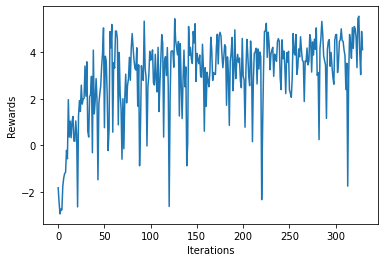

 33%|████████████████████████▏                                                | 33103/100000 [21:21<1:11:16, 15.64it/s]

Updated Weights
Mean Reward = 3.22
7


 33%|████████████████████████▏                                                | 33203/100000 [21:27<1:07:26, 16.51it/s]

Updated Weights
Mean Reward = 4.02
5


 33%|████████████████████████▎                                                | 33303/100000 [21:34<1:16:02, 14.62it/s]

Updated Weights
Mean Reward = 4.64
7


 33%|████████████████████████▍                                                | 33403/100000 [21:40<1:17:26, 14.33it/s]

Updated Weights
Mean Reward = 2.84
8


 33%|████████████████████████▍                                                | 33499/100000 [21:46<1:15:36, 14.66it/s]

Updated Weights
Mean Reward = 3.6
7


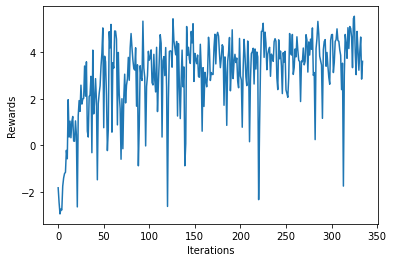

 34%|████████████████████████▌                                                | 33604/100000 [21:53<1:08:26, 16.17it/s]

Updated Weights
Mean Reward = 3.7
9


 34%|█████████████████████████▎                                                 | 33703/100000 [21:59<58:51, 18.77it/s]

Updated Weights
Mean Reward = 4.0
7


 34%|█████████████████████████▎                                                 | 33803/100000 [22:04<41:29, 26.59it/s]

Updated Weights
Mean Reward = 4.57
14


 34%|█████████████████████████▍                                                 | 33906/100000 [22:08<40:52, 26.95it/s]

Updated Weights
Mean Reward = 4.65
6


 34%|█████████████████████████▍                                                 | 33998/100000 [22:11<40:10, 27.38it/s]

Updated Weights
Mean Reward = 4.51
9


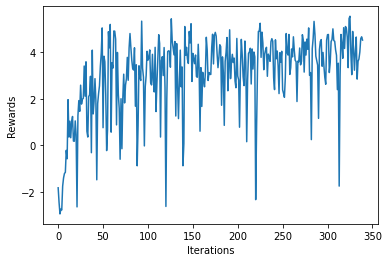

 34%|█████████████████████████▌                                                 | 34104/100000 [22:15<43:13, 25.41it/s]

Updated Weights
Mean Reward = 4.33
8


 34%|█████████████████████████▋                                                 | 34204/100000 [22:19<38:56, 28.16it/s]

Updated Weights
Mean Reward = 4.26
7


 34%|█████████████████████████▋                                                 | 34305/100000 [22:23<42:27, 25.79it/s]

Updated Weights
Mean Reward = 4.88
8


 34%|█████████████████████████▊                                                 | 34404/100000 [22:27<44:08, 24.77it/s]

Updated Weights
Mean Reward = 4.29
8


 34%|█████████████████████████▊                                                 | 34500/100000 [22:32<46:32, 23.45it/s]

Updated Weights
Mean Reward = 1.75
4


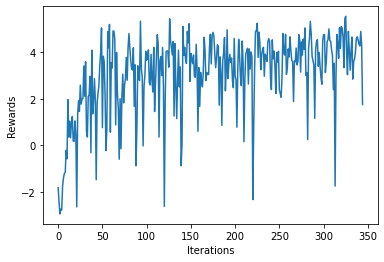

 35%|█████████████████████████▉                                                 | 34604/100000 [22:36<41:31, 26.25it/s]

Updated Weights
Mean Reward = 3.54
8


 35%|██████████████████████████                                                 | 34705/100000 [22:40<43:54, 24.78it/s]

Updated Weights
Mean Reward = 4.04
8


 35%|██████████████████████████                                                 | 34804/100000 [22:44<38:22, 28.32it/s]

Updated Weights
Mean Reward = 4.23
6


 35%|██████████████████████████▏                                                | 34904/100000 [22:48<57:25, 18.89it/s]

Updated Weights
Mean Reward = 4.91
8


 35%|██████████████████████████▎                                                | 35000/100000 [22:52<41:35, 26.05it/s]

Updated Weights
Mean Reward = 4.7
9


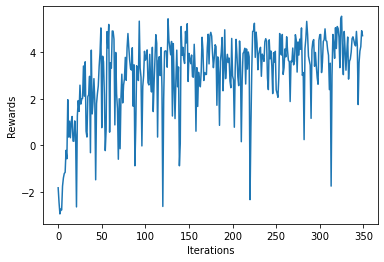

 35%|██████████████████████████▎                                                | 35106/100000 [22:57<47:01, 23.00it/s]

Updated Weights
Mean Reward = 3.27
8


 35%|██████████████████████████▍                                                | 35204/100000 [23:01<42:24, 25.47it/s]

Updated Weights
Mean Reward = 3.22
7


 35%|██████████████████████████▍                                                | 35306/100000 [23:05<43:24, 24.84it/s]

Updated Weights
Mean Reward = 3.03
8


 35%|██████████████████████████▌                                                | 35403/100000 [23:09<40:52, 26.34it/s]

Updated Weights
Mean Reward = 3.44
5


 35%|██████████████████████████▌                                                | 35497/100000 [23:13<49:03, 21.91it/s]

Updated Weights
Mean Reward = 4.69
11


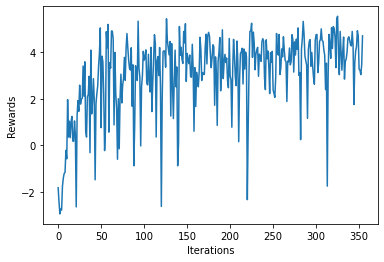

 36%|██████████████████████████▋                                                | 35603/100000 [23:17<59:18, 18.10it/s]

Updated Weights
Mean Reward = 4.03
8


 36%|██████████████████████████▊                                                | 35704/100000 [23:22<46:14, 23.17it/s]

Updated Weights
Mean Reward = 4.49
12


 36%|██████████████████████████▊                                                | 35805/100000 [23:26<42:28, 25.19it/s]

Updated Weights
Mean Reward = 5.33
9


 36%|██████████████████████████▉                                                | 35904/100000 [23:30<49:49, 21.44it/s]

Updated Weights
Mean Reward = 4.21
7


 36%|██████████████████████████▉                                                | 35999/100000 [23:35<59:14, 18.01it/s]

Updated Weights
Mean Reward = 4.33
9


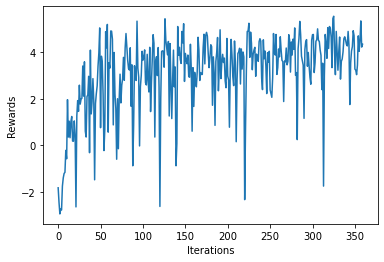

 36%|███████████████████████████                                                | 36106/100000 [23:40<43:59, 24.21it/s]

Updated Weights
Mean Reward = 3.61
5


 36%|███████████████████████████▏                                               | 36206/100000 [23:44<38:49, 27.39it/s]

Updated Weights
Mean Reward = 4.61
10


 36%|███████████████████████████▏                                               | 36303/100000 [23:48<50:09, 21.17it/s]

Updated Weights
Mean Reward = 4.76
12


 36%|███████████████████████████▎                                               | 36406/100000 [23:52<40:13, 26.35it/s]

Updated Weights
Mean Reward = 4.12
7


 36%|███████████████████████████▍                                               | 36500/100000 [23:56<39:11, 27.01it/s]

Updated Weights
Mean Reward = 4.08
4


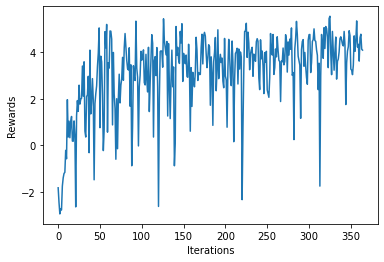

 37%|███████████████████████████▍                                               | 36606/100000 [24:00<37:36, 28.10it/s]

Updated Weights
Mean Reward = 4.94
8


 37%|███████████████████████████▌                                               | 36705/100000 [24:04<54:17, 19.43it/s]

Updated Weights
Mean Reward = 5.05
9


 37%|███████████████████████████▌                                               | 36806/100000 [24:10<47:32, 22.16it/s]

Updated Weights
Mean Reward = 4.79
9


 37%|███████████████████████████▋                                               | 36904/100000 [24:15<47:13, 22.26it/s]

Updated Weights
Mean Reward = 4.79
7


 37%|███████████████████████████▋                                               | 36999/100000 [24:19<39:45, 26.41it/s]

Updated Weights
Mean Reward = 4.59
7


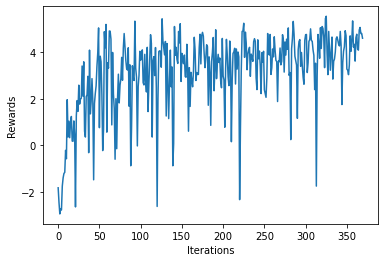

 37%|███████████████████████████▊                                               | 37103/100000 [24:23<42:07, 24.88it/s]

Updated Weights
Mean Reward = 4.2
11


 37%|███████████████████████████▉                                               | 37203/100000 [24:27<41:21, 25.31it/s]

Updated Weights
Mean Reward = 4.42
8


 37%|███████████████████████████▏                                             | 37303/100000 [24:32<1:04:06, 16.30it/s]

Updated Weights
Mean Reward = 4.44
9


 37%|████████████████████████████                                               | 37405/100000 [24:36<42:44, 24.41it/s]

Updated Weights
Mean Reward = 3.98
11


 38%|████████████████████████████▏                                              | 37500/100000 [24:40<42:03, 24.76it/s]

Updated Weights
Mean Reward = 4.7
15


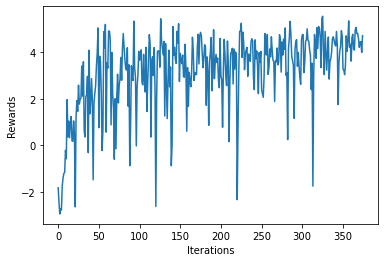

 38%|████████████████████████████▏                                              | 37606/100000 [24:44<40:09, 25.89it/s]

Updated Weights
Mean Reward = 4.7
9


 38%|████████████████████████████▎                                              | 37704/100000 [24:48<52:55, 19.62it/s]

Updated Weights
Mean Reward = 3.71
5


 38%|████████████████████████████▎                                              | 37804/100000 [24:54<55:35, 18.65it/s]

Updated Weights
Mean Reward = 1.69
8


 38%|███████████████████████████▋                                             | 37902/100000 [25:00<1:30:57, 11.38it/s]

Updated Weights
Mean Reward = 3.93
11


 38%|███████████████████████████▋                                             | 38000/100000 [25:07<1:02:04, 16.65it/s]

Updated Weights
Mean Reward = 4.11
7


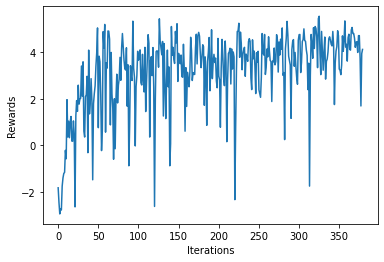

 38%|████████████████████████████▌                                              | 38103/100000 [25:13<56:57, 18.11it/s]

Updated Weights
Mean Reward = 4.3
9


 38%|████████████████████████████▋                                              | 38203/100000 [25:19<54:48, 18.79it/s]

Updated Weights
Mean Reward = 4.76
5


 38%|████████████████████████████▋                                              | 38305/100000 [25:24<52:31, 19.58it/s]

Updated Weights
Mean Reward = 5.06
9


 38%|████████████████████████████                                             | 38402/100000 [25:31<1:37:41, 10.51it/s]

Updated Weights
Mean Reward = 3.75
8


 38%|████████████████████████████                                             | 38500/100000 [25:39<1:34:18, 10.87it/s]

Updated Weights
Mean Reward = 3.26
5


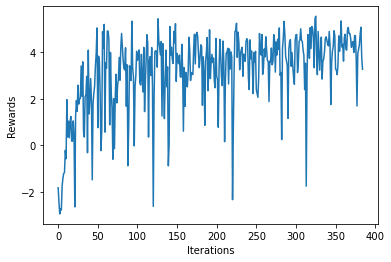

 39%|████████████████████████████▉                                              | 38604/100000 [25:46<53:47, 19.02it/s]

Updated Weights
Mean Reward = -0.12
8


 39%|█████████████████████████████                                              | 38704/100000 [25:51<56:28, 18.09it/s]

Updated Weights
Mean Reward = 3.81
3


 39%|█████████████████████████████                                              | 38804/100000 [25:57<53:44, 18.98it/s]

Updated Weights
Mean Reward = 4.17
11


 39%|█████████████████████████████▏                                             | 38903/100000 [26:02<54:35, 18.65it/s]

Updated Weights
Mean Reward = 4.74
10


 39%|█████████████████████████████▎                                             | 39000/100000 [26:07<52:31, 19.36it/s]

Updated Weights
Mean Reward = 4.69
8


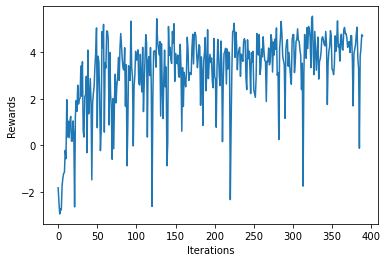

 39%|████████████████████████████▌                                            | 39103/100000 [26:14<1:00:27, 16.79it/s]

Updated Weights
Mean Reward = 4.9
11


 39%|█████████████████████████████▍                                             | 39202/100000 [26:20<48:33, 20.87it/s]

Updated Weights
Mean Reward = 2.86
11


 39%|█████████████████████████████▍                                             | 39305/100000 [26:26<53:48, 18.80it/s]

Updated Weights
Mean Reward = 4.68
11


 39%|████████████████████████████▊                                            | 39403/100000 [26:32<1:03:04, 16.01it/s]

Updated Weights
Mean Reward = 3.87
10


 40%|█████████████████████████████▋                                             | 39500/100000 [26:38<55:16, 18.24it/s]

Updated Weights
Mean Reward = 4.7
8


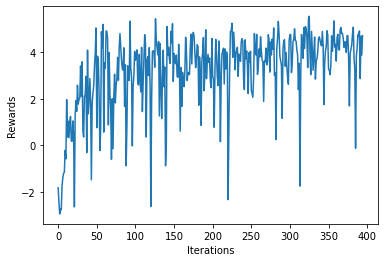

 40%|████████████████████████████▉                                            | 39604/100000 [26:45<1:04:34, 15.59it/s]

Updated Weights
Mean Reward = 2.88
9


 40%|█████████████████████████████▊                                             | 39704/100000 [26:50<38:21, 26.19it/s]

Updated Weights
Mean Reward = -0.55
6


 40%|█████████████████████████████▊                                             | 39805/100000 [26:54<40:57, 24.49it/s]

Updated Weights
Mean Reward = 4.42
7


 40%|█████████████████████████████▉                                             | 39906/100000 [26:58<35:12, 28.44it/s]

Updated Weights
Mean Reward = 4.46
6


 40%|█████████████████████████████▉                                             | 39999/100000 [27:03<55:14, 18.10it/s]

Updated Weights
Mean Reward = 5.79
13


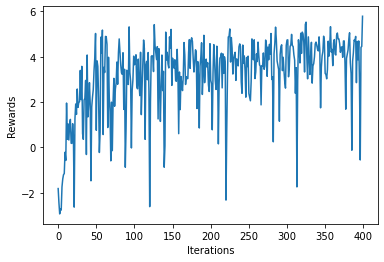

 40%|██████████████████████████████                                             | 40104/100000 [27:08<38:45, 25.76it/s]

Updated Weights
Mean Reward = 4.79
8


 40%|██████████████████████████████▏                                            | 40206/100000 [27:12<43:26, 22.94it/s]

Updated Weights
Mean Reward = 5.08
10


 40%|██████████████████████████████▏                                            | 40303/100000 [27:16<43:50, 22.69it/s]

Updated Weights
Mean Reward = 4.22
6


 40%|██████████████████████████████▎                                            | 40404/100000 [27:22<46:54, 21.17it/s]

Updated Weights
Mean Reward = 4.69
3


 40%|██████████████████████████████▍                                            | 40500/100000 [27:26<48:14, 20.56it/s]

Updated Weights
Mean Reward = 3.81
5


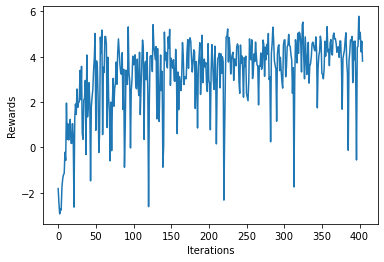

 41%|██████████████████████████████▍                                            | 40603/100000 [27:31<44:29, 22.25it/s]

Updated Weights
Mean Reward = 2.26
9


 41%|██████████████████████████████▌                                            | 40703/100000 [27:36<55:19, 17.86it/s]

Updated Weights
Mean Reward = 4.48
7


 41%|██████████████████████████████▌                                            | 40805/100000 [27:41<46:38, 21.15it/s]

Updated Weights
Mean Reward = 3.35
4


 41%|█████████████████████████████▊                                           | 40904/100000 [27:47<1:01:05, 16.12it/s]

Updated Weights
Mean Reward = 3.89
8


 41%|██████████████████████████████▋                                            | 40998/100000 [27:52<49:34, 19.84it/s]

Updated Weights
Mean Reward = 3.04
8


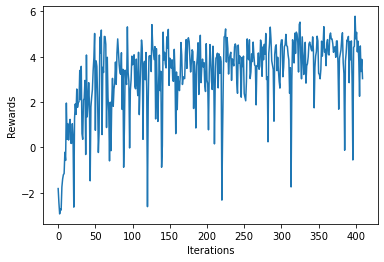

 41%|██████████████████████████████▊                                            | 41104/100000 [27:57<53:13, 18.44it/s]

Updated Weights
Mean Reward = 4.4
10


 41%|██████████████████████████████▉                                            | 41204/100000 [28:03<54:47, 17.89it/s]

Updated Weights
Mean Reward = 4.08
13


 41%|██████████████████████████████▉                                            | 41304/100000 [28:08<52:18, 18.70it/s]

Updated Weights
Mean Reward = 3.9
9


 41%|███████████████████████████████                                            | 41404/100000 [28:14<51:56, 18.80it/s]

Updated Weights
Mean Reward = 5.2
12


 42%|██████████████████████████████▎                                          | 41500/100000 [28:19<1:02:40, 15.56it/s]

Updated Weights
Mean Reward = 5.28
9


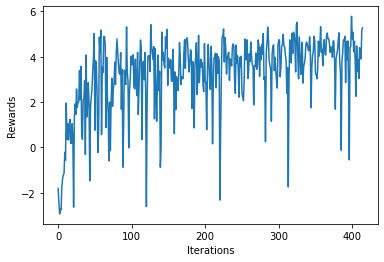

 42%|███████████████████████████████▏                                           | 41604/100000 [28:25<58:10, 16.73it/s]

Updated Weights
Mean Reward = 4.14
3


 42%|██████████████████████████████▍                                          | 41702/100000 [28:30<1:02:48, 15.47it/s]

Updated Weights
Mean Reward = 4.17
7


 42%|███████████████████████████████▎                                           | 41803/100000 [28:36<48:26, 20.02it/s]

Updated Weights
Mean Reward = 5.42
10


 42%|███████████████████████████████▍                                           | 41905/100000 [28:42<57:48, 16.75it/s]

Updated Weights
Mean Reward = 5.08
9


 42%|███████████████████████████████▌                                           | 42000/100000 [28:47<46:34, 20.75it/s]

Updated Weights
Mean Reward = 5.48
10


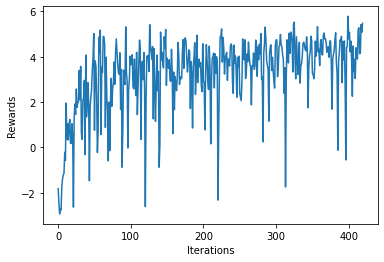

 42%|███████████████████████████████▌                                           | 42105/100000 [28:52<47:31, 20.30it/s]

Updated Weights
Mean Reward = 4.97
11


 42%|██████████████████████████████▊                                          | 42204/100000 [28:58<1:11:27, 13.48it/s]

Updated Weights
Mean Reward = 5.44
10


 42%|███████████████████████████████▋                                           | 42303/100000 [29:04<57:56, 16.60it/s]

Updated Weights
Mean Reward = 6.27
17


 42%|███████████████████████████████▊                                           | 42404/100000 [29:10<53:53, 17.81it/s]

Updated Weights
Mean Reward = 3.1
5


 42%|███████████████████████████████▉                                           | 42500/100000 [29:15<50:52, 18.84it/s]

Updated Weights
Mean Reward = 3.53
6


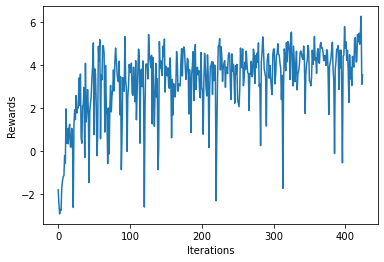

 43%|███████████████████████████████▉                                           | 42603/100000 [29:21<53:34, 17.86it/s]

Updated Weights
Mean Reward = 4.41
8


 43%|████████████████████████████████                                           | 42704/100000 [29:26<52:04, 18.34it/s]

Updated Weights
Mean Reward = 4.01
5


 43%|████████████████████████████████                                           | 42803/100000 [29:32<55:25, 17.20it/s]

Updated Weights
Mean Reward = 3.21
5


 43%|████████████████████████████████▏                                          | 42903/100000 [29:38<53:19, 17.84it/s]

Updated Weights
Mean Reward = 3.09
7


 43%|████████████████████████████████▏                                          | 42998/100000 [29:43<42:44, 22.23it/s]

Updated Weights
Mean Reward = 4.02
10


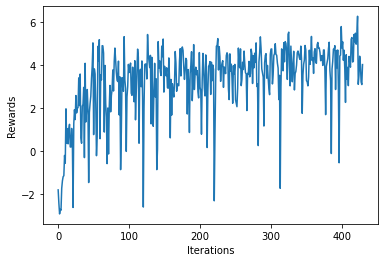

 43%|████████████████████████████████▎                                          | 43105/100000 [29:48<46:20, 20.46it/s]

Updated Weights
Mean Reward = 3.82
10


 43%|████████████████████████████████▍                                          | 43203/100000 [29:53<42:45, 22.14it/s]

Updated Weights
Mean Reward = 4.1
8


 43%|████████████████████████████████▍                                          | 43306/100000 [29:57<35:00, 26.99it/s]

Updated Weights
Mean Reward = 5.33
10


 43%|████████████████████████████████▌                                          | 43405/100000 [30:01<35:52, 26.29it/s]

Updated Weights
Mean Reward = 4.12
8


 44%|████████████████████████████████▋                                          | 43500/100000 [30:05<43:41, 21.55it/s]

Updated Weights
Mean Reward = 3.24
10


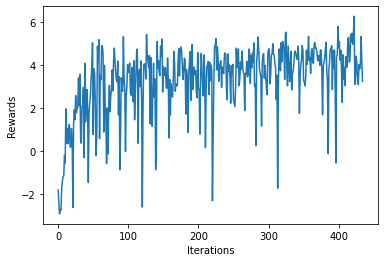

 44%|████████████████████████████████▋                                          | 43605/100000 [30:11<38:39, 24.31it/s]

Updated Weights
Mean Reward = 4.41
10


 44%|████████████████████████████████▊                                          | 43707/100000 [30:15<29:14, 32.08it/s]

Updated Weights
Mean Reward = 4.14
12


 44%|████████████████████████████████▊                                          | 43805/100000 [30:18<32:38, 28.70it/s]

Updated Weights
Mean Reward = 4.68
10


 44%|████████████████████████████████▉                                          | 43904/100000 [30:22<42:28, 22.01it/s]

Updated Weights
Mean Reward = 5.11
7


 44%|█████████████████████████████████                                          | 44000/100000 [30:26<39:08, 23.85it/s]

Updated Weights
Mean Reward = 4.21
5


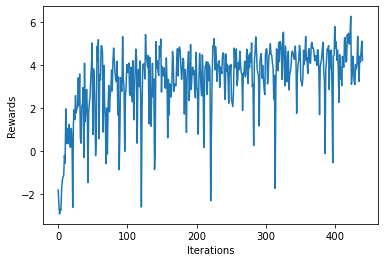

 44%|█████████████████████████████████                                          | 44103/100000 [30:31<52:59, 17.58it/s]

Updated Weights
Mean Reward = 3.37
7


 44%|█████████████████████████████████▏                                         | 44205/100000 [30:36<33:45, 27.54it/s]

Updated Weights
Mean Reward = 2.53
7


 44%|█████████████████████████████████▏                                         | 44306/100000 [30:40<42:26, 21.87it/s]

Updated Weights
Mean Reward = 3.61
8


 44%|█████████████████████████████████▎                                         | 44407/100000 [30:44<28:27, 32.56it/s]

Updated Weights
Mean Reward = 4.65
11


 44%|█████████████████████████████████▎                                         | 44499/100000 [30:48<48:38, 19.02it/s]

Updated Weights
Mean Reward = 4.65
13


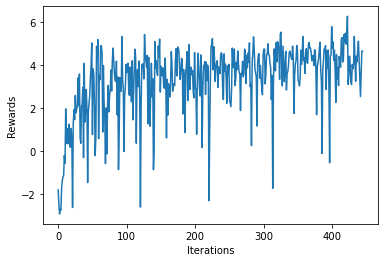

 45%|█████████████████████████████████▍                                         | 44605/100000 [30:52<30:35, 30.17it/s]

Updated Weights
Mean Reward = 4.5
12


 45%|█████████████████████████████████▌                                         | 44706/100000 [30:56<33:59, 27.11it/s]

Updated Weights
Mean Reward = 4.94
13


 45%|█████████████████████████████████▌                                         | 44805/100000 [31:00<55:18, 16.63it/s]

Updated Weights
Mean Reward = 3.43
5


 45%|█████████████████████████████████▋                                         | 44906/100000 [31:04<36:50, 24.93it/s]

Updated Weights
Mean Reward = 3.29
6


 45%|█████████████████████████████████▊                                         | 45000/100000 [31:07<36:58, 24.79it/s]

Updated Weights
Mean Reward = 4.58
3


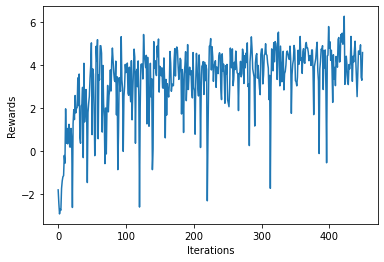

 45%|█████████████████████████████████▊                                         | 45105/100000 [31:11<34:35, 26.44it/s]

Updated Weights
Mean Reward = 5.22
12


 45%|█████████████████████████████████▉                                         | 45203/100000 [31:15<40:27, 22.57it/s]

Updated Weights
Mean Reward = 4.55
4


 45%|█████████████████████████████████▉                                         | 45304/100000 [31:19<37:35, 24.25it/s]

Updated Weights
Mean Reward = 4.64
8


 45%|██████████████████████████████████                                         | 45404/100000 [31:22<31:39, 28.74it/s]

Updated Weights
Mean Reward = 3.21
6


 45%|██████████████████████████████████                                         | 45499/100000 [31:26<49:33, 18.33it/s]

Updated Weights
Mean Reward = 4.66
7


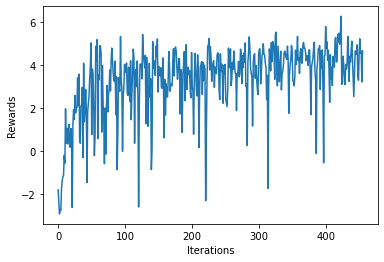

 46%|██████████████████████████████████▏                                        | 45605/100000 [31:31<32:03, 28.28it/s]

Updated Weights
Mean Reward = 4.77
7


 46%|██████████████████████████████████▎                                        | 45705/100000 [31:34<36:46, 24.60it/s]

Updated Weights
Mean Reward = 4.61
6


 46%|██████████████████████████████████▎                                        | 45804/100000 [31:38<36:41, 24.62it/s]

Updated Weights
Mean Reward = 5.07
12


 46%|██████████████████████████████████▍                                        | 45905/100000 [31:43<44:53, 20.08it/s]

Updated Weights
Mean Reward = 5.3
13


 46%|██████████████████████████████████▍                                        | 45999/100000 [31:47<37:25, 24.05it/s]

Updated Weights
Mean Reward = 5.11
6


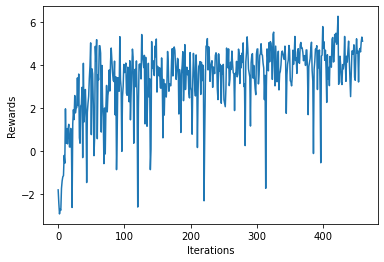

 46%|██████████████████████████████████▌                                        | 46103/100000 [31:52<46:46, 19.20it/s]

Updated Weights
Mean Reward = 5.17
10


 46%|██████████████████████████████████▋                                        | 46206/100000 [31:56<33:17, 26.93it/s]

Updated Weights
Mean Reward = 4.99
6


 46%|██████████████████████████████████▋                                        | 46305/100000 [32:00<36:10, 24.74it/s]

Updated Weights
Mean Reward = 4.24
8


 46%|██████████████████████████████████▊                                        | 46405/100000 [32:03<33:56, 26.32it/s]

Updated Weights
Mean Reward = 5.36
8


 46%|██████████████████████████████████▉                                        | 46500/100000 [32:08<43:31, 20.49it/s]

Updated Weights
Mean Reward = 5.11
9


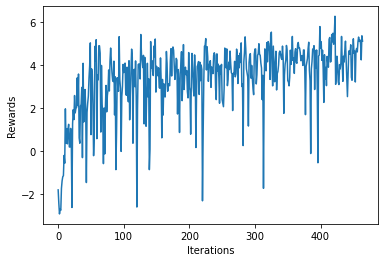

 47%|██████████████████████████████████▉                                        | 46604/100000 [32:12<35:09, 25.32it/s]

Updated Weights
Mean Reward = 4.64
6


 47%|███████████████████████████████████                                        | 46703/100000 [32:16<37:38, 23.60it/s]

Updated Weights
Mean Reward = 4.74
11


 47%|███████████████████████████████████                                        | 46805/100000 [32:21<31:26, 28.19it/s]

Updated Weights
Mean Reward = 4.04
10


 47%|███████████████████████████████████▏                                       | 46905/100000 [32:24<30:21, 29.16it/s]

Updated Weights
Mean Reward = 5.9
13


 47%|███████████████████████████████████▎                                       | 47000/100000 [32:27<31:53, 27.69it/s]

Updated Weights
Mean Reward = 3.92
8


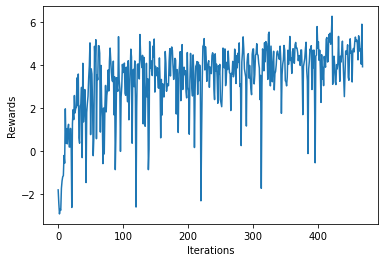

 47%|███████████████████████████████████▎                                       | 47103/100000 [32:31<31:40, 27.84it/s]

Updated Weights
Mean Reward = 4.48
8


 47%|███████████████████████████████████▍                                       | 47206/100000 [32:35<33:46, 26.05it/s]

Updated Weights
Mean Reward = 5.62
12


 47%|███████████████████████████████████▍                                       | 47303/100000 [32:40<35:05, 25.02it/s]

Updated Weights
Mean Reward = 4.91
5


 47%|███████████████████████████████████▌                                       | 47407/100000 [32:44<32:28, 26.99it/s]

Updated Weights
Mean Reward = 5.89
11


 47%|███████████████████████████████████▌                                       | 47499/100000 [32:47<29:57, 29.21it/s]

Updated Weights
Mean Reward = 5.25
11


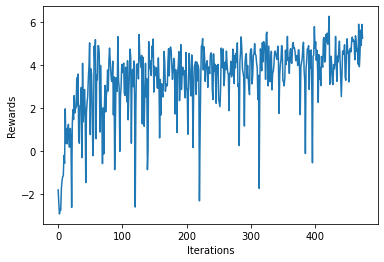

 48%|███████████████████████████████████▋                                       | 47605/100000 [32:52<43:44, 19.97it/s]

Updated Weights
Mean Reward = 4.59
5


 48%|███████████████████████████████████▊                                       | 47704/100000 [32:56<32:16, 27.01it/s]

Updated Weights
Mean Reward = 3.86
9


 48%|███████████████████████████████████▊                                       | 47806/100000 [33:00<29:31, 29.46it/s]

Updated Weights
Mean Reward = 4.4
7


 48%|███████████████████████████████████▉                                       | 47904/100000 [33:04<34:09, 25.42it/s]

Updated Weights
Mean Reward = 3.69
10


 48%|████████████████████████████████████                                       | 48000/100000 [33:08<47:50, 18.11it/s]

Updated Weights
Mean Reward = 3.76
5


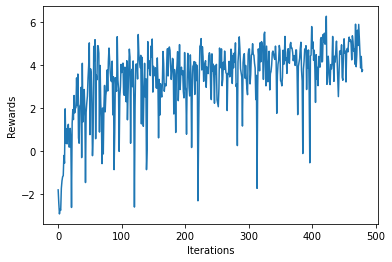

 48%|████████████████████████████████████                                       | 48106/100000 [33:13<30:31, 28.33it/s]

Updated Weights
Mean Reward = 4.75
10


 48%|████████████████████████████████████▏                                      | 48204/100000 [33:17<29:22, 29.38it/s]

Updated Weights
Mean Reward = 5.07
10


 48%|████████████████████████████████████▏                                      | 48304/100000 [33:20<32:32, 26.47it/s]

Updated Weights
Mean Reward = 4.56
5


 48%|████████████████████████████████████▎                                      | 48405/100000 [33:24<29:05, 29.56it/s]

Updated Weights
Mean Reward = 5.07
10


 48%|████████████████████████████████████▎                                      | 48498/100000 [33:27<31:38, 27.12it/s]

Updated Weights
Mean Reward = 4.28
9


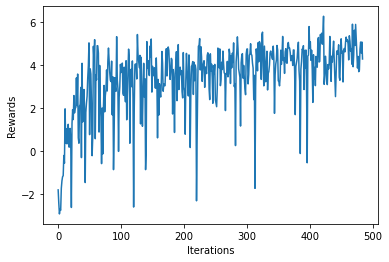

 49%|████████████████████████████████████▍                                      | 48605/100000 [33:32<26:59, 31.73it/s]

Updated Weights
Mean Reward = 4.64
9


 49%|████████████████████████████████████▌                                      | 48704/100000 [33:36<32:15, 26.50it/s]

Updated Weights
Mean Reward = 3.79
6


 49%|████████████████████████████████████▌                                      | 48806/100000 [33:39<33:25, 25.52it/s]

Updated Weights
Mean Reward = 3.79
9


 49%|████████████████████████████████████▋                                      | 48905/100000 [33:43<31:47, 26.78it/s]

Updated Weights
Mean Reward = 4.14
5


 49%|████████████████████████████████████▋                                      | 48998/100000 [33:46<30:00, 28.33it/s]

Updated Weights
Mean Reward = 4.94
11


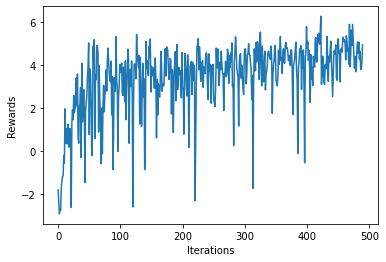

 49%|████████████████████████████████████▊                                      | 49105/100000 [33:50<32:39, 25.97it/s]

Updated Weights
Mean Reward = 4.6
4


 49%|████████████████████████████████████▉                                      | 49203/100000 [33:54<31:07, 27.20it/s]

Updated Weights
Mean Reward = 4.71
7


 49%|████████████████████████████████████▉                                      | 49306/100000 [33:58<28:27, 29.69it/s]

Updated Weights
Mean Reward = 5.4
9


 49%|█████████████████████████████████████                                      | 49404/100000 [34:02<30:42, 27.47it/s]

Updated Weights
Mean Reward = 5.18
8


 50%|█████████████████████████████████████▏                                     | 49500/100000 [34:05<34:33, 24.35it/s]

Updated Weights
Mean Reward = 5.57
11


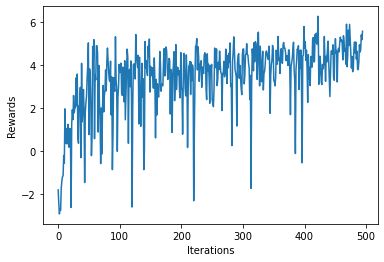

 50%|█████████████████████████████████████▏                                     | 49604/100000 [34:09<31:24, 26.74it/s]

Updated Weights
Mean Reward = 4.52
7


 50%|█████████████████████████████████████▎                                     | 49706/100000 [34:13<32:22, 25.90it/s]

Updated Weights
Mean Reward = 4.48
7


 50%|█████████████████████████████████████▎                                     | 49803/100000 [34:17<32:21, 25.85it/s]

Updated Weights
Mean Reward = 4.81
10


 50%|█████████████████████████████████████▍                                     | 49907/100000 [34:22<28:36, 29.19it/s]

Updated Weights
Mean Reward = 4.72
9


 50%|█████████████████████████████████████▌                                     | 50000/100000 [34:26<36:10, 23.03it/s]

Updated Weights
Mean Reward = 4.25
9


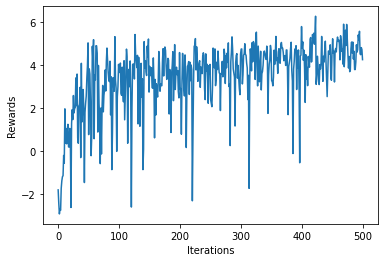

 50%|█████████████████████████████████████▌                                     | 50103/100000 [34:31<41:19, 20.13it/s]

Updated Weights
Mean Reward = 4.51
13


 50%|█████████████████████████████████████▋                                     | 50204/100000 [34:36<50:15, 16.51it/s]

Updated Weights
Mean Reward = 4.08
8


 50%|█████████████████████████████████████▋                                     | 50304/100000 [34:42<42:42, 19.39it/s]

Updated Weights
Mean Reward = 4.03
4


 50%|████████████████████████████████████▊                                    | 50403/100000 [34:47<1:00:12, 13.73it/s]

Updated Weights
Mean Reward = 5.44
15


 50%|█████████████████████████████████████▉                                     | 50500/100000 [34:52<32:56, 25.05it/s]

Updated Weights
Mean Reward = 4.79
7


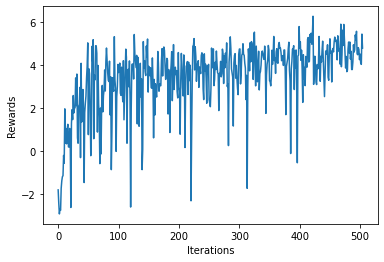

 51%|█████████████████████████████████████▉                                     | 50602/100000 [34:57<33:23, 24.66it/s]

Updated Weights
Mean Reward = 5.37
11


 51%|██████████████████████████████████████                                     | 50706/100000 [35:02<30:49, 26.65it/s]

Updated Weights
Mean Reward = 5.12
6


 51%|██████████████████████████████████████                                     | 50804/100000 [35:06<31:29, 26.04it/s]

Updated Weights
Mean Reward = 4.34
4


 51%|██████████████████████████████████████▏                                    | 50904/100000 [35:09<27:59, 29.24it/s]

Updated Weights
Mean Reward = 3.89
6


 51%|██████████████████████████████████████▏                                    | 50999/100000 [35:13<34:04, 23.96it/s]

Updated Weights
Mean Reward = 5.2
13


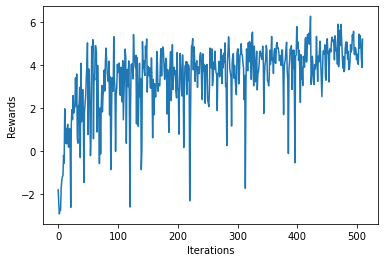

 51%|██████████████████████████████████████▎                                    | 51103/100000 [35:18<33:35, 24.26it/s]

Updated Weights
Mean Reward = 4.39
10


 51%|██████████████████████████████████████▍                                    | 51203/100000 [35:22<30:32, 26.63it/s]

Updated Weights
Mean Reward = 4.72
18


 51%|██████████████████████████████████████▍                                    | 51304/100000 [35:25<37:16, 21.78it/s]

Updated Weights
Mean Reward = 1.23
9


 51%|██████████████████████████████████████▌                                    | 51404/100000 [35:30<39:18, 20.61it/s]

Updated Weights
Mean Reward = 4.44
9


 51%|██████████████████████████████████████▌                                    | 51499/100000 [35:34<34:52, 23.18it/s]

Updated Weights
Mean Reward = 4.51
8


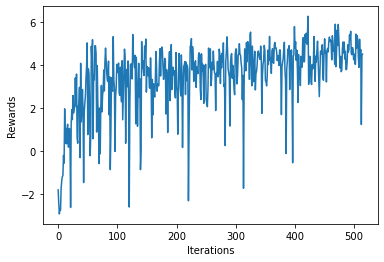

 52%|██████████████████████████████████████▋                                    | 51605/100000 [35:38<32:58, 24.46it/s]

Updated Weights
Mean Reward = 2.58
10


 52%|██████████████████████████████████████▊                                    | 51705/100000 [35:43<28:17, 28.45it/s]

Updated Weights
Mean Reward = 4.51
8


 52%|██████████████████████████████████████▊                                    | 51804/100000 [35:47<35:07, 22.87it/s]

Updated Weights
Mean Reward = 4.26
4


 52%|██████████████████████████████████████▉                                    | 51903/100000 [35:51<36:14, 22.12it/s]

Updated Weights
Mean Reward = 5.86
11


 52%|███████████████████████████████████████                                    | 52000/100000 [35:54<32:43, 24.44it/s]

Updated Weights
Mean Reward = 5.36
13


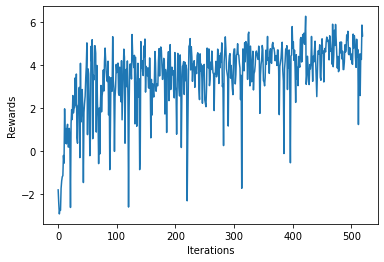

 52%|███████████████████████████████████████                                    | 52106/100000 [35:59<29:25, 27.12it/s]

Updated Weights
Mean Reward = 5.35
8


 52%|███████████████████████████████████████▏                                   | 52204/100000 [36:02<33:19, 23.90it/s]

Updated Weights
Mean Reward = 5.62
15


 52%|███████████████████████████████████████▏                                   | 52306/100000 [36:07<35:11, 22.59it/s]

Updated Weights
Mean Reward = 4.65
9


 52%|███████████████████████████████████████▎                                   | 52405/100000 [36:10<32:04, 24.73it/s]

Updated Weights
Mean Reward = 5.76
15


 52%|███████████████████████████████████████▎                                   | 52498/100000 [36:14<30:32, 25.92it/s]

Updated Weights
Mean Reward = 5.15
8


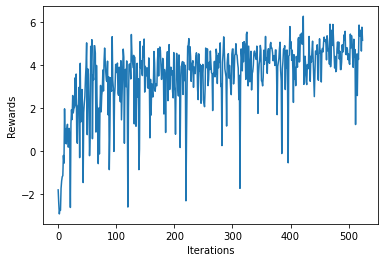

 53%|███████████████████████████████████████▍                                   | 52602/100000 [36:19<33:04, 23.88it/s]

Updated Weights
Mean Reward = 4.39
12


 53%|███████████████████████████████████████▌                                   | 52705/100000 [36:22<30:31, 25.82it/s]

Updated Weights
Mean Reward = 4.57
13


 53%|███████████████████████████████████████▌                                   | 52803/100000 [36:26<41:37, 18.89it/s]

Updated Weights
Mean Reward = 5.02
10


 53%|███████████████████████████████████████▋                                   | 52905/100000 [36:31<30:11, 25.99it/s]

Updated Weights
Mean Reward = 4.82
5


 53%|███████████████████████████████████████▋                                   | 52999/100000 [36:34<28:47, 27.21it/s]

Updated Weights
Mean Reward = 5.77
10


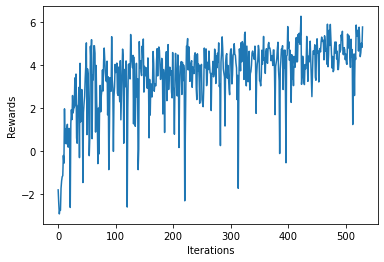

 53%|███████████████████████████████████████▊                                   | 53104/100000 [36:39<30:08, 25.93it/s]

Updated Weights
Mean Reward = 3.95
10


 53%|███████████████████████████████████████▉                                   | 53206/100000 [36:43<26:16, 29.69it/s]

Updated Weights
Mean Reward = 5.36
5


 53%|███████████████████████████████████████▉                                   | 53306/100000 [36:46<28:37, 27.19it/s]

Updated Weights
Mean Reward = 4.86
7


 53%|████████████████████████████████████████                                   | 53403/100000 [36:50<28:00, 27.73it/s]

Updated Weights
Mean Reward = 4.45
4


 53%|████████████████████████████████████████                                   | 53499/100000 [36:53<26:21, 29.40it/s]

Updated Weights
Mean Reward = 4.39
7


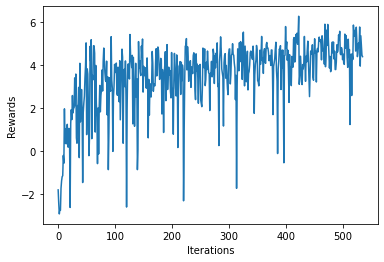

 54%|████████████████████████████████████████▏                                  | 53603/100000 [36:57<26:12, 29.50it/s]

Updated Weights
Mean Reward = 4.48
6


 54%|████████████████████████████████████████▎                                  | 53703/100000 [37:00<26:14, 29.41it/s]

Updated Weights
Mean Reward = 5.27
12


 54%|████████████████████████████████████████▎                                  | 53805/100000 [37:04<28:00, 27.49it/s]

Updated Weights
Mean Reward = 5.06
8


 54%|████████████████████████████████████████▍                                  | 53907/100000 [37:07<25:46, 29.81it/s]

Updated Weights
Mean Reward = 4.61
11


 54%|████████████████████████████████████████▍                                  | 53997/100000 [37:11<27:44, 27.63it/s]

Updated Weights
Mean Reward = 4.5
4


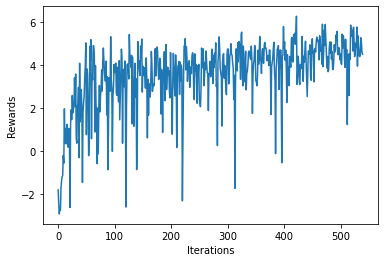

 54%|████████████████████████████████████████▌                                  | 54106/100000 [37:15<26:16, 29.11it/s]

Updated Weights
Mean Reward = 5.5
9


 54%|████████████████████████████████████████▋                                  | 54204/100000 [37:18<27:14, 28.02it/s]

Updated Weights
Mean Reward = 3.12
15


 54%|████████████████████████████████████████▋                                  | 54303/100000 [37:21<29:14, 26.04it/s]

Updated Weights
Mean Reward = 4.69
9


 54%|████████████████████████████████████████▊                                  | 54404/100000 [37:25<27:18, 27.83it/s]

Updated Weights
Mean Reward = 4.3
10


 55%|████████████████████████████████████████▉                                  | 54500/100000 [37:28<27:42, 27.36it/s]

Updated Weights
Mean Reward = 5.03
7


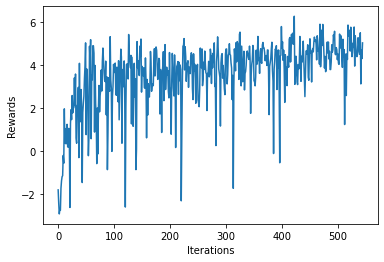

 55%|████████████████████████████████████████▉                                  | 54605/100000 [37:32<25:17, 29.92it/s]

Updated Weights
Mean Reward = 4.93
11


 55%|█████████████████████████████████████████                                  | 54703/100000 [37:35<27:10, 27.79it/s]

Updated Weights
Mean Reward = 3.44
9


 55%|█████████████████████████████████████████                                  | 54803/100000 [37:39<27:58, 26.92it/s]

Updated Weights
Mean Reward = 4.02
4


 55%|█████████████████████████████████████████▏                                 | 54904/100000 [37:43<29:28, 25.50it/s]

Updated Weights
Mean Reward = 5.06
8


 55%|█████████████████████████████████████████▏                                 | 54998/100000 [37:46<27:12, 27.57it/s]

Updated Weights
Mean Reward = 4.25
12


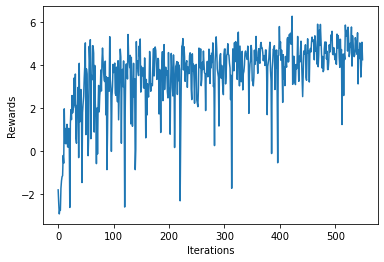

 55%|█████████████████████████████████████████▎                                 | 55105/100000 [37:50<25:09, 29.75it/s]

Updated Weights
Mean Reward = 5.56
11


 55%|█████████████████████████████████████████▍                                 | 55205/100000 [37:53<25:25, 29.37it/s]

Updated Weights
Mean Reward = 5.19
10


 55%|█████████████████████████████████████████▍                                 | 55305/100000 [37:57<25:10, 29.58it/s]

Updated Weights
Mean Reward = 5.46
11


 55%|█████████████████████████████████████████▌                                 | 55408/100000 [38:00<23:06, 32.16it/s]

Updated Weights
Mean Reward = 5.54
10


 55%|█████████████████████████████████████████▌                                 | 55498/100000 [38:03<22:24, 33.09it/s]

Updated Weights
Mean Reward = 5.24
16


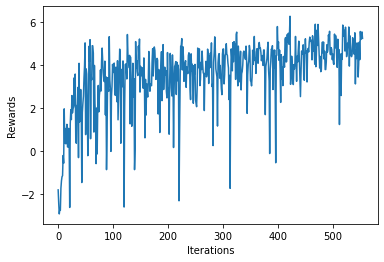

 56%|█████████████████████████████████████████▋                                 | 55605/100000 [38:07<24:54, 29.71it/s]

Updated Weights
Mean Reward = 5.85
13


 56%|█████████████████████████████████████████▊                                 | 55704/100000 [38:11<26:25, 27.94it/s]

Updated Weights
Mean Reward = 3.64
7


 56%|█████████████████████████████████████████▊                                 | 55805/100000 [38:14<25:49, 28.52it/s]

Updated Weights
Mean Reward = 4.73
6


 56%|█████████████████████████████████████████▉                                 | 55905/100000 [38:17<27:13, 27.00it/s]

Updated Weights
Mean Reward = 5.59
11


 56%|██████████████████████████████████████████                                 | 56000/100000 [38:21<26:57, 27.21it/s]

Updated Weights
Mean Reward = 6.16
5


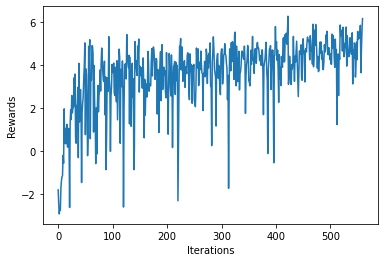

 56%|██████████████████████████████████████████                                 | 56107/100000 [38:25<23:50, 30.68it/s]

Updated Weights
Mean Reward = 5.04
8


 56%|██████████████████████████████████████████▏                                | 56205/100000 [38:28<25:24, 28.73it/s]

Updated Weights
Mean Reward = 4.98
7


 56%|██████████████████████████████████████████▏                                | 56304/100000 [38:31<25:28, 28.59it/s]

Updated Weights
Mean Reward = 5.2
12


 56%|██████████████████████████████████████████▎                                | 56407/100000 [38:35<24:44, 29.38it/s]

Updated Weights
Mean Reward = 4.82
9


 56%|██████████████████████████████████████████▎                                | 56499/100000 [38:38<22:29, 32.23it/s]

Updated Weights
Mean Reward = 5.7
14


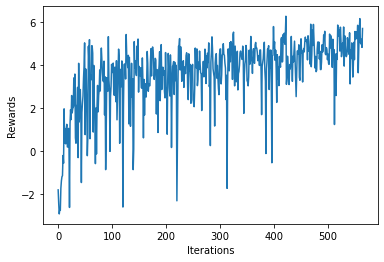

 57%|██████████████████████████████████████████▍                                | 56607/100000 [38:42<24:29, 29.53it/s]

Updated Weights
Mean Reward = 5.15
8


 57%|██████████████████████████████████████████▌                                | 56706/100000 [38:45<24:10, 29.84it/s]

Updated Weights
Mean Reward = 5.62
13


 57%|██████████████████████████████████████████▌                                | 56805/100000 [38:49<23:43, 30.34it/s]

Updated Weights
Mean Reward = 6.0
12


 57%|██████████████████████████████████████████▋                                | 56906/100000 [38:52<26:25, 27.19it/s]

Updated Weights
Mean Reward = 4.48
7


 57%|██████████████████████████████████████████▋                                | 57000/100000 [38:56<25:40, 27.91it/s]

Updated Weights
Mean Reward = 4.51
4


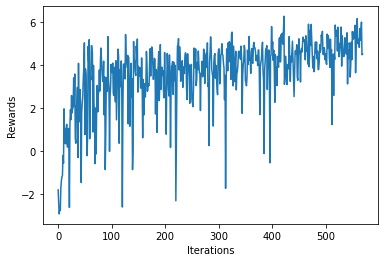

 57%|██████████████████████████████████████████▊                                | 57104/100000 [38:59<24:07, 29.64it/s]

Updated Weights
Mean Reward = 5.06
7


 57%|██████████████████████████████████████████▉                                | 57206/100000 [39:03<26:38, 26.77it/s]

Updated Weights
Mean Reward = 4.0
4


 57%|██████████████████████████████████████████▉                                | 57304/100000 [39:06<25:18, 28.11it/s]

Updated Weights
Mean Reward = 4.48
5


 57%|███████████████████████████████████████████                                | 57406/100000 [39:10<24:41, 28.74it/s]

Updated Weights
Mean Reward = 4.89
9


 57%|███████████████████████████████████████████▏                               | 57500/100000 [39:13<21:47, 32.51it/s]

Updated Weights
Mean Reward = 5.89
12


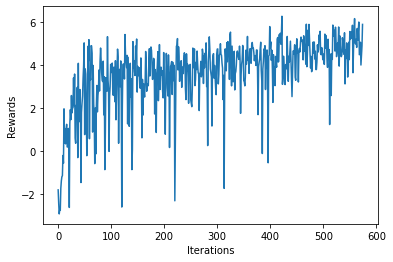

 58%|███████████████████████████████████████████▏                               | 57604/100000 [39:17<25:59, 27.18it/s]

Updated Weights
Mean Reward = 4.32
10


 58%|███████████████████████████████████████████▎                               | 57704/100000 [39:20<26:51, 26.25it/s]

Updated Weights
Mean Reward = 5.02
8


 58%|███████████████████████████████████████████▎                               | 57804/100000 [39:24<23:25, 30.02it/s]

Updated Weights
Mean Reward = 4.73
6


 58%|███████████████████████████████████████████▍                               | 57906/100000 [39:27<24:34, 28.55it/s]

Updated Weights
Mean Reward = 5.38
13


 58%|███████████████████████████████████████████▍                               | 57998/100000 [39:31<25:30, 27.44it/s]

Updated Weights
Mean Reward = 4.21
4


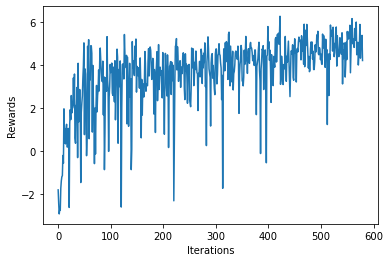

 58%|███████████████████████████████████████████▌                               | 58104/100000 [39:35<26:12, 26.64it/s]

Updated Weights
Mean Reward = 5.09
7


 58%|███████████████████████████████████████████▋                               | 58205/100000 [39:38<23:51, 29.19it/s]

Updated Weights
Mean Reward = 5.37
14


 58%|███████████████████████████████████████████▋                               | 58306/100000 [39:42<25:50, 26.89it/s]

Updated Weights
Mean Reward = 5.5
11


 58%|███████████████████████████████████████████▊                               | 58405/100000 [39:45<27:58, 24.77it/s]

Updated Weights
Mean Reward = 5.57
10


 58%|███████████████████████████████████████████▊                               | 58497/100000 [39:49<24:05, 28.72it/s]

Updated Weights
Mean Reward = 4.93
5


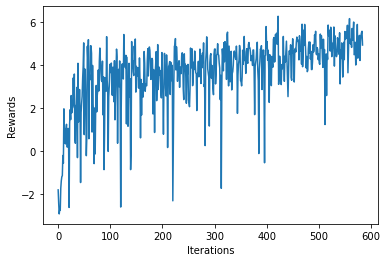

 59%|███████████████████████████████████████████▉                               | 58605/100000 [39:53<22:48, 30.24it/s]

Updated Weights
Mean Reward = 5.44
8


 59%|████████████████████████████████████████████                               | 58705/100000 [39:56<24:01, 28.65it/s]

Updated Weights
Mean Reward = 5.19
13


 59%|████████████████████████████████████████████                               | 58806/100000 [40:00<25:16, 27.16it/s]

Updated Weights
Mean Reward = 4.64
7


 59%|████████████████████████████████████████████▏                              | 58903/100000 [40:03<25:15, 27.11it/s]

Updated Weights
Mean Reward = 5.57
11


 59%|████████████████████████████████████████████▏                              | 58999/100000 [40:06<22:40, 30.13it/s]

Updated Weights
Mean Reward = 5.96
14


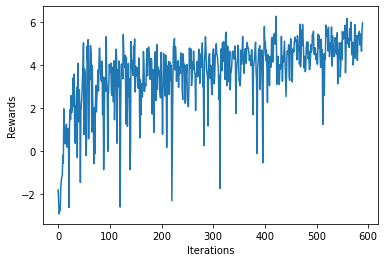

 59%|████████████████████████████████████████████▎                              | 59105/100000 [40:10<24:33, 27.76it/s]

Updated Weights
Mean Reward = 4.7
4


 59%|████████████████████████████████████████████▍                              | 59203/100000 [40:13<24:55, 27.28it/s]

Updated Weights
Mean Reward = 4.68
5


 59%|████████████████████████████████████████████▍                              | 59306/100000 [40:17<24:23, 27.81it/s]

Updated Weights
Mean Reward = 4.46
9


 59%|████████████████████████████████████████████▌                              | 59404/100000 [40:20<24:11, 27.96it/s]

Updated Weights
Mean Reward = 4.86
5


 60%|████████████████████████████████████████████▋                              | 59500/100000 [40:24<24:35, 27.45it/s]

Updated Weights
Mean Reward = 4.31
8


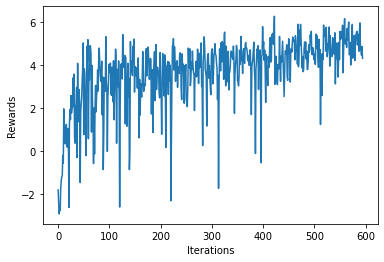

 60%|████████████████████████████████████████████▋                              | 59605/100000 [40:27<21:50, 30.82it/s]

Updated Weights
Mean Reward = 5.64
7


 60%|████████████████████████████████████████████▊                              | 59703/100000 [40:31<23:23, 28.71it/s]

Updated Weights
Mean Reward = 5.27
10


 60%|████████████████████████████████████████████▊                              | 59804/100000 [40:34<24:47, 27.03it/s]

Updated Weights
Mean Reward = 4.17
9


 60%|████████████████████████████████████████████▉                              | 59905/100000 [40:38<23:04, 28.95it/s]

Updated Weights
Mean Reward = 5.62
7


 60%|████████████████████████████████████████████▉                              | 59999/100000 [40:41<23:08, 28.81it/s]

Updated Weights
Mean Reward = 5.72
15


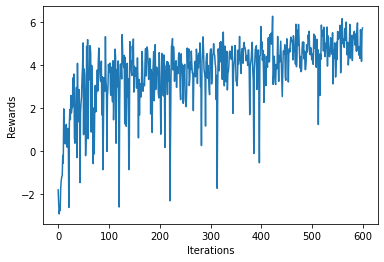

 60%|█████████████████████████████████████████████                              | 60105/100000 [40:45<24:50, 26.76it/s]

Updated Weights
Mean Reward = 4.73
4


 60%|█████████████████████████████████████████████▏                             | 60206/100000 [40:49<22:47, 29.11it/s]

Updated Weights
Mean Reward = 4.01
9


 60%|█████████████████████████████████████████████▏                             | 60305/100000 [40:52<22:26, 29.48it/s]

Updated Weights
Mean Reward = 4.75
7


 60%|█████████████████████████████████████████████▎                             | 60405/100000 [40:55<21:45, 30.33it/s]

Updated Weights
Mean Reward = 5.86
19


 60%|█████████████████████████████████████████████▎                             | 60497/100000 [40:58<20:59, 31.36it/s]

Updated Weights
Mean Reward = 5.11
13


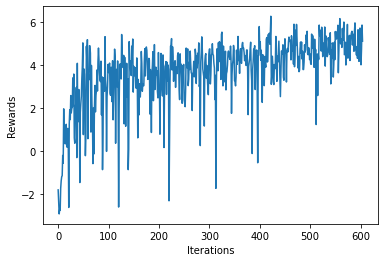

 61%|█████████████████████████████████████████████▍                             | 60604/100000 [41:02<21:58, 29.88it/s]

Updated Weights
Mean Reward = 5.04
12


 61%|█████████████████████████████████████████████▌                             | 60703/100000 [41:06<22:45, 28.77it/s]

Updated Weights
Mean Reward = 3.96
6


 61%|█████████████████████████████████████████████▌                             | 60807/100000 [41:09<21:54, 29.82it/s]

Updated Weights
Mean Reward = 5.22
16


 61%|█████████████████████████████████████████████▋                             | 60903/100000 [41:12<20:34, 31.67it/s]

Updated Weights
Mean Reward = 5.4
13


 61%|█████████████████████████████████████████████▋                             | 60998/100000 [41:15<24:02, 27.04it/s]

Updated Weights
Mean Reward = 4.36
8


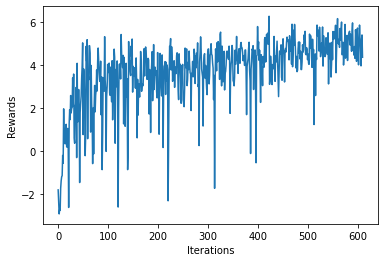

 61%|█████████████████████████████████████████████▊                             | 61105/100000 [41:19<23:26, 27.65it/s]

Updated Weights
Mean Reward = 4.67
10


 61%|█████████████████████████████████████████████▉                             | 61205/100000 [41:23<24:00, 26.93it/s]

Updated Weights
Mean Reward = 3.75
5


 61%|█████████████████████████████████████████████▉                             | 61305/100000 [41:26<22:01, 29.27it/s]

Updated Weights
Mean Reward = 4.84
11


 61%|██████████████████████████████████████████████                             | 61404/100000 [41:30<23:55, 26.89it/s]

Updated Weights
Mean Reward = 4.68
3


 61%|██████████████████████████████████████████████                             | 61499/100000 [41:33<21:00, 30.55it/s]

Updated Weights
Mean Reward = 5.82
13


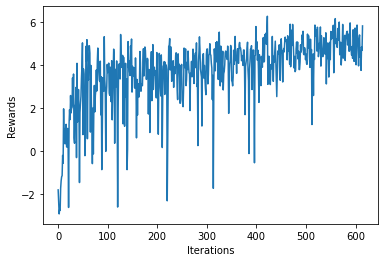

 62%|██████████████████████████████████████████████▏                            | 61604/100000 [41:37<23:19, 27.44it/s]

Updated Weights
Mean Reward = 5.76
9


 62%|██████████████████████████████████████████████▎                            | 61704/100000 [41:40<20:34, 31.03it/s]

Updated Weights
Mean Reward = 5.89
17


 62%|██████████████████████████████████████████████▎                            | 61806/100000 [41:44<21:19, 29.85it/s]

Updated Weights
Mean Reward = 5.06
10


 62%|██████████████████████████████████████████████▍                            | 61903/100000 [41:47<21:55, 28.95it/s]

Updated Weights
Mean Reward = 5.52
15


 62%|██████████████████████████████████████████████▍                            | 61998/100000 [41:50<21:58, 28.83it/s]

Updated Weights
Mean Reward = 4.99
12


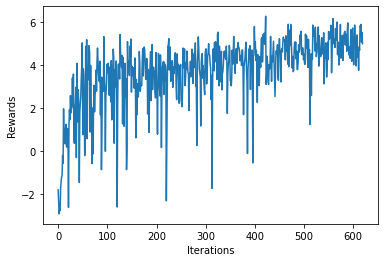

 62%|██████████████████████████████████████████████▌                            | 62105/100000 [41:54<21:51, 28.90it/s]

Updated Weights
Mean Reward = 4.79
11


 62%|██████████████████████████████████████████████▋                            | 62205/100000 [41:57<21:35, 29.18it/s]

Updated Weights
Mean Reward = 4.6
9


 62%|██████████████████████████████████████████████▋                            | 62305/100000 [42:01<20:23, 30.80it/s]

Updated Weights
Mean Reward = 5.64
9


 62%|██████████████████████████████████████████████▊                            | 62404/100000 [42:04<22:49, 27.45it/s]

Updated Weights
Mean Reward = 5.21
8


 62%|██████████████████████████████████████████████▊                            | 62497/100000 [42:08<21:07, 29.58it/s]

Updated Weights
Mean Reward = 5.92
10


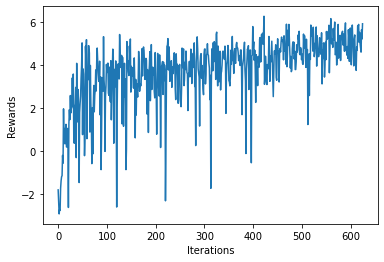

 63%|██████████████████████████████████████████████▉                            | 62606/100000 [42:11<21:21, 29.19it/s]

Updated Weights
Mean Reward = 4.71
9


 63%|███████████████████████████████████████████████                            | 62704/100000 [42:15<21:58, 28.29it/s]

Updated Weights
Mean Reward = 4.83
3


 63%|███████████████████████████████████████████████                            | 62805/100000 [42:19<22:53, 27.09it/s]

Updated Weights
Mean Reward = 4.73
4


 63%|███████████████████████████████████████████████▏                           | 62905/100000 [42:22<20:34, 30.06it/s]

Updated Weights
Mean Reward = 4.24
9


 63%|███████████████████████████████████████████████▎                           | 63000/100000 [42:25<21:03, 29.29it/s]

Updated Weights
Mean Reward = 4.77
15


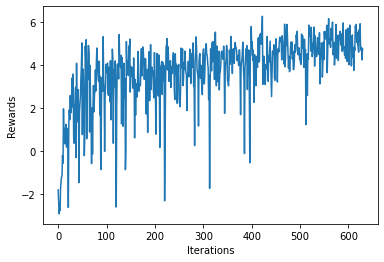

 63%|███████████████████████████████████████████████▎                           | 63105/100000 [42:29<22:14, 27.65it/s]

Updated Weights
Mean Reward = 3.09
6


 63%|███████████████████████████████████████████████▍                           | 63202/100000 [42:32<21:40, 28.30it/s]

Updated Weights
Mean Reward = -0.99
6


 63%|███████████████████████████████████████████████▍                           | 63305/100000 [42:36<22:53, 26.72it/s]

Updated Weights
Mean Reward = 2.58
8


 63%|███████████████████████████████████████████████▌                           | 63406/100000 [42:40<21:03, 28.97it/s]

Updated Weights
Mean Reward = 3.79
6


 63%|███████████████████████████████████████████████▌                           | 63497/100000 [42:43<20:26, 29.77it/s]

Updated Weights
Mean Reward = 2.42
6


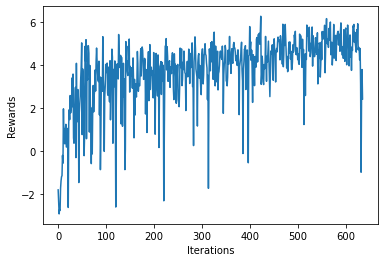

 64%|███████████████████████████████████████████████▋                           | 63606/100000 [42:47<20:45, 29.22it/s]

Updated Weights
Mean Reward = 3.14
11


 64%|███████████████████████████████████████████████▊                           | 63705/100000 [42:50<22:20, 27.07it/s]

Updated Weights
Mean Reward = 4.05
7


 64%|███████████████████████████████████████████████▊                           | 63805/100000 [42:54<22:33, 26.73it/s]

Updated Weights
Mean Reward = 4.1
5


 64%|███████████████████████████████████████████████▉                           | 63905/100000 [42:57<20:40, 29.09it/s]

Updated Weights
Mean Reward = 2.79
4


 64%|████████████████████████████████████████████████                           | 64000/100000 [43:01<20:54, 28.69it/s]

Updated Weights
Mean Reward = 4.29
9


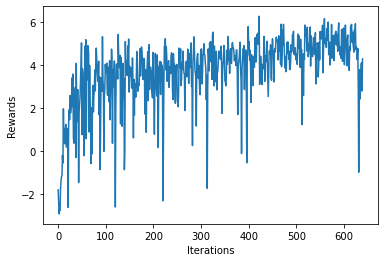

 64%|████████████████████████████████████████████████                           | 64104/100000 [43:04<21:20, 28.02it/s]

Updated Weights
Mean Reward = 3.94
5


 64%|████████████████████████████████████████████████▏                          | 64206/100000 [43:08<20:43, 28.79it/s]

Updated Weights
Mean Reward = 4.21
9


 64%|████████████████████████████████████████████████▏                          | 64306/100000 [43:11<21:22, 27.83it/s]

Updated Weights
Mean Reward = 4.95
7


 64%|████████████████████████████████████████████████▎                          | 64405/100000 [43:15<20:21, 29.14it/s]

Updated Weights
Mean Reward = 5.65
10


 64%|████████████████████████████████████████████████▍                          | 64500/100000 [43:18<22:06, 26.76it/s]

Updated Weights
Mean Reward = 5.56
10


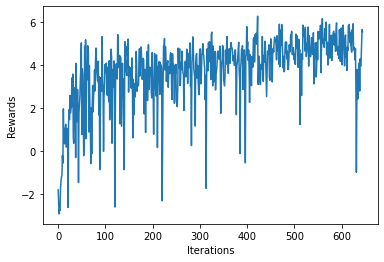

 65%|████████████████████████████████████████████████▍                          | 64603/100000 [43:22<21:27, 27.48it/s]

Updated Weights
Mean Reward = 4.77
6


 65%|████████████████████████████████████████████████▌                          | 64705/100000 [43:25<20:37, 28.53it/s]

Updated Weights
Mean Reward = 5.57
11


 65%|████████████████████████████████████████████████▌                          | 64806/100000 [43:29<21:13, 27.63it/s]

Updated Weights
Mean Reward = 4.87
8


 65%|████████████████████████████████████████████████▋                          | 64903/100000 [43:32<22:24, 26.11it/s]

Updated Weights
Mean Reward = 4.6
5


 65%|████████████████████████████████████████████████▋                          | 64999/100000 [43:36<19:09, 30.44it/s]

Updated Weights
Mean Reward = 4.59
3


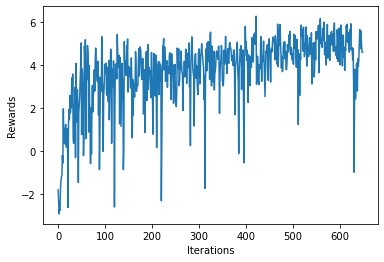

 65%|████████████████████████████████████████████████▊                          | 65104/100000 [43:40<21:03, 27.61it/s]

Updated Weights
Mean Reward = 4.6
3


 65%|████████████████████████████████████████████████▉                          | 65205/100000 [43:43<20:45, 27.93it/s]

Updated Weights
Mean Reward = 5.37
6


 65%|████████████████████████████████████████████████▉                          | 65304/100000 [43:47<20:23, 28.36it/s]

Updated Weights
Mean Reward = 5.12
8


 65%|█████████████████████████████████████████████████                          | 65405/100000 [43:50<19:17, 29.90it/s]

Updated Weights
Mean Reward = 4.18
6


 66%|█████████████████████████████████████████████████▏                         | 65500/100000 [43:54<19:29, 29.49it/s]

Updated Weights
Mean Reward = 4.95
10


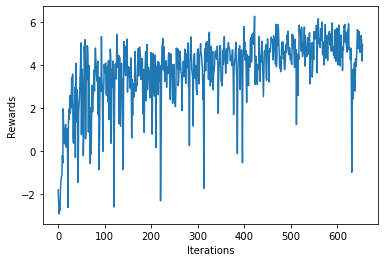

 66%|█████████████████████████████████████████████████▏                         | 65604/100000 [43:57<19:14, 29.80it/s]

Updated Weights
Mean Reward = 5.71
12


 66%|█████████████████████████████████████████████████▎                         | 65706/100000 [44:01<18:44, 30.50it/s]

Updated Weights
Mean Reward = 5.03
8


 66%|█████████████████████████████████████████████████▎                         | 65805/100000 [44:04<20:39, 27.58it/s]

Updated Weights
Mean Reward = 5.94
10


 66%|█████████████████████████████████████████████████▍                         | 65904/100000 [44:08<19:44, 28.78it/s]

Updated Weights
Mean Reward = 5.4
7


 66%|█████████████████████████████████████████████████▍                         | 65998/100000 [44:11<22:56, 24.71it/s]

Updated Weights
Mean Reward = 5.55
13


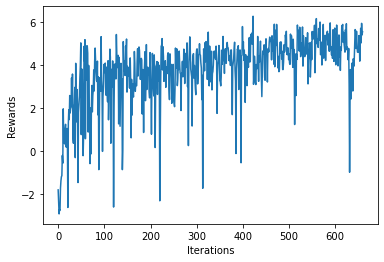

 66%|█████████████████████████████████████████████████▌                         | 66106/100000 [44:15<20:06, 28.08it/s]

Updated Weights
Mean Reward = 4.04
5


 66%|█████████████████████████████████████████████████▋                         | 66205/100000 [44:19<19:10, 29.37it/s]

Updated Weights
Mean Reward = 4.89
6


 66%|█████████████████████████████████████████████████▋                         | 66305/100000 [44:22<19:46, 28.40it/s]

Updated Weights
Mean Reward = 6.33
12


 66%|█████████████████████████████████████████████████▊                         | 66406/100000 [44:26<19:36, 28.55it/s]

Updated Weights
Mean Reward = 5.23
11


 66%|█████████████████████████████████████████████████▊                         | 66499/100000 [44:29<19:13, 29.04it/s]

Updated Weights
Mean Reward = 5.95
11


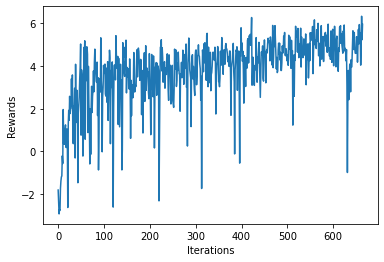

 67%|█████████████████████████████████████████████████▉                         | 66603/100000 [44:33<22:42, 24.51it/s]

Updated Weights
Mean Reward = 5.95
12


 67%|██████████████████████████████████████████████████                         | 66705/100000 [44:37<19:53, 27.90it/s]

Updated Weights
Mean Reward = 6.22
8


 67%|██████████████████████████████████████████████████                         | 66805/100000 [44:40<19:59, 27.67it/s]

Updated Weights
Mean Reward = 6.29
9


 67%|██████████████████████████████████████████████████▏                        | 66904/100000 [44:44<19:26, 28.37it/s]

Updated Weights
Mean Reward = 5.75
9


 67%|██████████████████████████████████████████████████▎                        | 67000/100000 [44:47<19:36, 28.05it/s]

Updated Weights
Mean Reward = 5.15
6


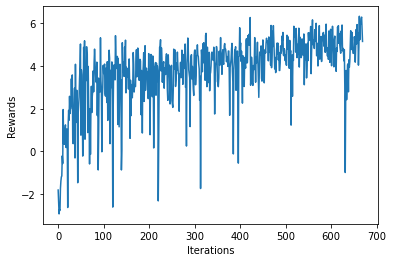

 67%|██████████████████████████████████████████████████▎                        | 67102/100000 [44:51<16:39, 32.91it/s]

Updated Weights
Mean Reward = 6.6
11


 67%|██████████████████████████████████████████████████▍                        | 67203/100000 [44:54<18:03, 30.27it/s]

Updated Weights
Mean Reward = 5.99
9


 67%|██████████████████████████████████████████████████▍                        | 67304/100000 [44:58<19:29, 27.95it/s]

Updated Weights
Mean Reward = -0.22
5


 67%|██████████████████████████████████████████████████▌                        | 67405/100000 [45:01<19:10, 28.33it/s]

Updated Weights
Mean Reward = 2.97
7


 68%|██████████████████████████████████████████████████▋                        | 67500/100000 [45:05<19:23, 27.93it/s]

Updated Weights
Mean Reward = 4.93
4


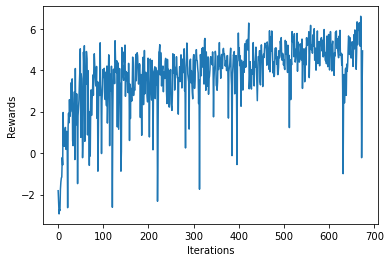

 68%|██████████████████████████████████████████████████▋                        | 67605/100000 [45:08<18:50, 28.66it/s]

Updated Weights
Mean Reward = 4.55
8


 68%|██████████████████████████████████████████████████▊                        | 67705/100000 [45:12<19:40, 27.35it/s]

Updated Weights
Mean Reward = 5.96
12


 68%|██████████████████████████████████████████████████▊                        | 67807/100000 [45:15<18:05, 29.65it/s]

Updated Weights
Mean Reward = 5.3
9


 68%|██████████████████████████████████████████████████▉                        | 67906/100000 [45:19<17:14, 31.03it/s]

Updated Weights
Mean Reward = 5.29
9


 68%|██████████████████████████████████████████████████▉                        | 67998/100000 [45:22<18:43, 28.49it/s]

Updated Weights
Mean Reward = 6.07
11


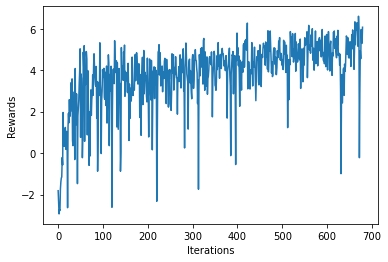

 68%|███████████████████████████████████████████████████                        | 68103/100000 [45:26<17:33, 30.29it/s]

Updated Weights
Mean Reward = 5.15
7


 68%|███████████████████████████████████████████████████▏                       | 68207/100000 [45:29<17:43, 29.90it/s]

Updated Weights
Mean Reward = 5.55
8


 68%|███████████████████████████████████████████████████▏                       | 68303/100000 [45:33<19:23, 27.24it/s]

Updated Weights
Mean Reward = 4.02
12


 68%|███████████████████████████████████████████████████▎                       | 68403/100000 [45:36<17:37, 29.88it/s]

Updated Weights
Mean Reward = 3.46
8


 68%|███████████████████████████████████████████████████▎                       | 68498/100000 [45:40<19:36, 26.77it/s]

Updated Weights
Mean Reward = 5.41
3


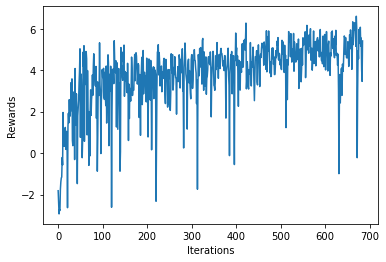

 69%|███████████████████████████████████████████████████▍                       | 68604/100000 [45:43<17:05, 30.63it/s]

Updated Weights
Mean Reward = 5.52
7


 69%|███████████████████████████████████████████████████▌                       | 68707/100000 [45:47<17:05, 30.51it/s]

Updated Weights
Mean Reward = 6.68
10


 69%|███████████████████████████████████████████████████▌                       | 68805/100000 [45:50<18:47, 27.68it/s]

Updated Weights
Mean Reward = 5.97
13


 69%|███████████████████████████████████████████████████▋                       | 68905/100000 [45:54<18:12, 28.45it/s]

Updated Weights
Mean Reward = 5.1
5


 69%|███████████████████████████████████████████████████▋                       | 68997/100000 [45:57<17:08, 30.16it/s]

Updated Weights
Mean Reward = 6.17
12


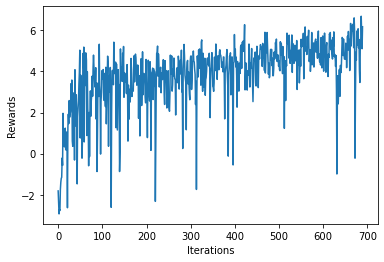

 69%|███████████████████████████████████████████████████▊                       | 69107/100000 [46:01<17:24, 29.59it/s]

Updated Weights
Mean Reward = 3.45
5


 69%|███████████████████████████████████████████████████▉                       | 69203/100000 [46:04<17:06, 29.99it/s]

Updated Weights
Mean Reward = 4.95
11


 69%|███████████████████████████████████████████████████▉                       | 69306/100000 [46:08<16:49, 30.39it/s]

Updated Weights
Mean Reward = 5.76
10


 69%|████████████████████████████████████████████████████                       | 69404/100000 [46:11<18:42, 27.26it/s]

Updated Weights
Mean Reward = 5.89
4


 69%|████████████████████████████████████████████████████                       | 69499/100000 [46:14<17:51, 28.46it/s]

Updated Weights
Mean Reward = 5.5
7


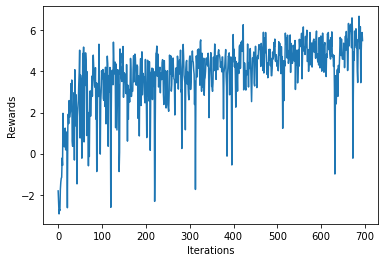

 70%|████████████████████████████████████████████████████▏                      | 69605/100000 [46:18<18:28, 27.43it/s]

Updated Weights
Mean Reward = 5.1
7


 70%|████████████████████████████████████████████████████▎                      | 69704/100000 [46:22<17:28, 28.89it/s]

Updated Weights
Mean Reward = 5.82
12


 70%|████████████████████████████████████████████████████▎                      | 69805/100000 [46:25<18:47, 26.78it/s]

Updated Weights
Mean Reward = 5.69
9


 70%|████████████████████████████████████████████████████▍                      | 69903/100000 [46:28<18:00, 27.86it/s]

Updated Weights
Mean Reward = 3.82
9


 70%|████████████████████████████████████████████████████▍                      | 69999/100000 [46:32<17:36, 28.40it/s]

Updated Weights
Mean Reward = 4.34
10


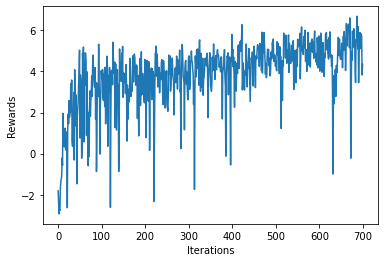

 70%|████████████████████████████████████████████████████▌                      | 70105/100000 [46:36<17:13, 28.93it/s]

Updated Weights
Mean Reward = 5.56
11


 70%|████████████████████████████████████████████████████▋                      | 70204/100000 [46:39<14:48, 33.54it/s]

Updated Weights
Mean Reward = 5.59
13


 70%|████████████████████████████████████████████████████▋                      | 70305/100000 [46:42<17:08, 28.87it/s]

Updated Weights
Mean Reward = 6.02
15


 70%|████████████████████████████████████████████████████▊                      | 70404/100000 [46:46<17:34, 28.07it/s]

Updated Weights
Mean Reward = 5.23
11


 70%|████████████████████████████████████████████████████▉                      | 70500/100000 [46:49<17:06, 28.74it/s]

Updated Weights
Mean Reward = 6.07
9


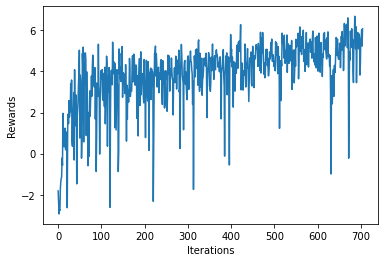

 71%|████████████████████████████████████████████████████▉                      | 70606/100000 [46:53<16:11, 30.26it/s]

Updated Weights
Mean Reward = 5.98
10


 71%|█████████████████████████████████████████████████████                      | 70704/100000 [46:56<15:17, 31.93it/s]

Updated Weights
Mean Reward = 5.87
12


 71%|█████████████████████████████████████████████████████                      | 70805/100000 [47:00<15:44, 30.93it/s]

Updated Weights
Mean Reward = 4.73
8


 71%|█████████████████████████████████████████████████████▏                     | 70903/100000 [47:03<17:34, 27.61it/s]

Updated Weights
Mean Reward = 4.86
7


 71%|█████████████████████████████████████████████████████▏                     | 70997/100000 [47:06<16:18, 29.65it/s]

Updated Weights
Mean Reward = 4.17
9


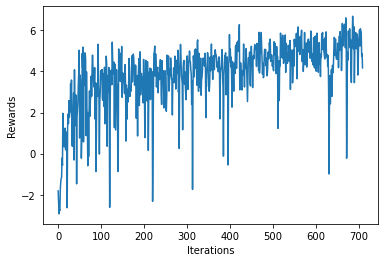

 71%|█████████████████████████████████████████████████████▎                     | 71106/100000 [47:10<15:47, 30.48it/s]

Updated Weights
Mean Reward = 5.16
7


 71%|█████████████████████████████████████████████████████▍                     | 71205/100000 [47:14<17:13, 27.87it/s]

Updated Weights
Mean Reward = 4.91
6


 71%|█████████████████████████████████████████████████████▍                     | 71303/100000 [47:17<15:55, 30.05it/s]

Updated Weights
Mean Reward = 6.46
13


 71%|█████████████████████████████████████████████████████▌                     | 71404/100000 [47:20<16:19, 29.20it/s]

Updated Weights
Mean Reward = 5.64
9


 71%|█████████████████████████████████████████████████████▌                     | 71499/100000 [47:24<16:29, 28.82it/s]

Updated Weights
Mean Reward = 5.52
7


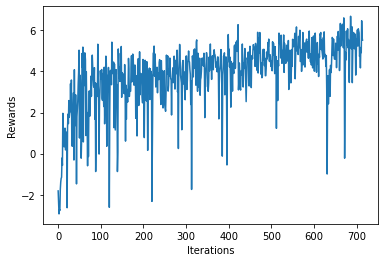

 72%|█████████████████████████████████████████████████████▋                     | 71606/100000 [47:28<15:13, 31.07it/s]

Updated Weights
Mean Reward = 5.41
10


 72%|█████████████████████████████████████████████████████▊                     | 71705/100000 [47:31<16:06, 29.28it/s]

Updated Weights
Mean Reward = 5.27
14


 72%|█████████████████████████████████████████████████████▊                     | 71807/100000 [47:34<15:07, 31.06it/s]

Updated Weights
Mean Reward = 5.28
8


 72%|█████████████████████████████████████████████████████▉                     | 71902/100000 [47:38<21:56, 21.34it/s]

Updated Weights
Mean Reward = 6.53
12


 72%|█████████████████████████████████████████████████████▉                     | 71999/100000 [47:42<22:39, 20.60it/s]

Updated Weights
Mean Reward = 5.19
5


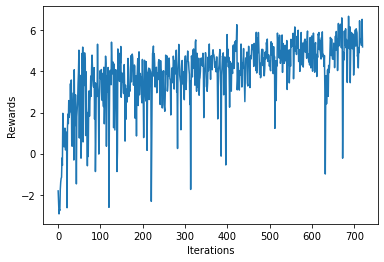

 72%|██████████████████████████████████████████████████████                     | 72106/100000 [47:47<18:42, 24.84it/s]

Updated Weights
Mean Reward = 6.5
9


 72%|██████████████████████████████████████████████████████▏                    | 72206/100000 [47:51<16:32, 28.00it/s]

Updated Weights
Mean Reward = 6.15
12


 72%|██████████████████████████████████████████████████████▏                    | 72305/100000 [47:55<20:02, 23.03it/s]

Updated Weights
Mean Reward = 5.47
9


 72%|██████████████████████████████████████████████████████▎                    | 72405/100000 [47:58<16:07, 28.53it/s]

Updated Weights
Mean Reward = 5.42
9


 72%|██████████████████████████████████████████████████████▎                    | 72498/100000 [48:02<16:45, 27.34it/s]

Updated Weights
Mean Reward = 4.64
10


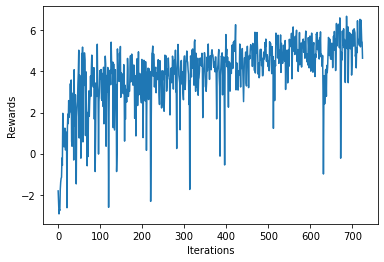

 73%|██████████████████████████████████████████████████████▍                    | 72606/100000 [48:06<16:50, 27.11it/s]

Updated Weights
Mean Reward = 4.37
13


 73%|██████████████████████████████████████████████████████▌                    | 72705/100000 [48:09<18:05, 25.15it/s]

Updated Weights
Mean Reward = 3.68
8


 73%|██████████████████████████████████████████████████████▌                    | 72808/100000 [48:13<15:20, 29.53it/s]

Updated Weights
Mean Reward = 6.77
10


 73%|██████████████████████████████████████████████████████▋                    | 72904/100000 [48:16<17:05, 26.42it/s]

Updated Weights
Mean Reward = 4.51
14


 73%|██████████████████████████████████████████████████████▋                    | 72999/100000 [48:21<24:33, 18.33it/s]

Updated Weights
Mean Reward = 5.44
13


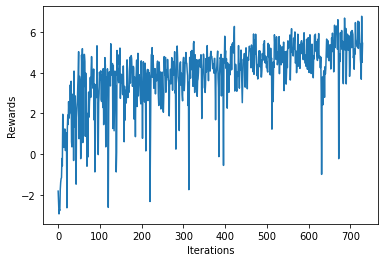

 73%|██████████████████████████████████████████████████████▊                    | 73103/100000 [48:25<22:01, 20.35it/s]

Updated Weights
Mean Reward = 3.89
9


 73%|██████████████████████████████████████████████████████▉                    | 73203/100000 [48:30<18:50, 23.70it/s]

Updated Weights
Mean Reward = 5.38
4


 73%|██████████████████████████████████████████████████████▉                    | 73306/100000 [48:34<16:55, 26.28it/s]

Updated Weights
Mean Reward = 5.87
7


 73%|███████████████████████████████████████████████████████                    | 73405/100000 [48:38<17:20, 25.55it/s]

Updated Weights
Mean Reward = 5.41
8


 73%|███████████████████████████████████████████████████████                    | 73499/100000 [48:42<16:01, 27.55it/s]

Updated Weights
Mean Reward = 6.1
12


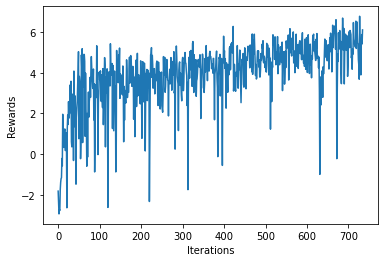

 74%|███████████████████████████████████████████████████████▏                   | 73605/100000 [48:46<15:37, 28.17it/s]

Updated Weights
Mean Reward = 6.17
15


 74%|███████████████████████████████████████████████████████▎                   | 73704/100000 [48:51<23:35, 18.57it/s]

Updated Weights
Mean Reward = 6.08
10


 74%|███████████████████████████████████████████████████████▎                   | 73803/100000 [48:56<17:31, 24.92it/s]

Updated Weights
Mean Reward = 6.12
10


 74%|███████████████████████████████████████████████████████▍                   | 73904/100000 [48:59<17:43, 24.54it/s]

Updated Weights
Mean Reward = 6.46
17


 74%|███████████████████████████████████████████████████████▍                   | 73998/100000 [49:03<16:57, 25.57it/s]

Updated Weights
Mean Reward = 4.52
5


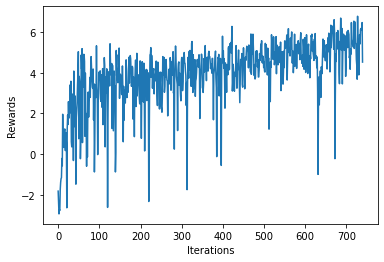

 74%|███████████████████████████████████████████████████████▌                   | 74105/100000 [49:11<19:47, 21.80it/s]

Updated Weights
Mean Reward = 5.49
8


 74%|███████████████████████████████████████████████████████▋                   | 74204/100000 [49:14<16:35, 25.91it/s]

Updated Weights
Mean Reward = 5.49
9


 74%|███████████████████████████████████████████████████████▋                   | 74304/100000 [49:18<16:04, 26.65it/s]

Updated Weights
Mean Reward = 5.33
9


 74%|███████████████████████████████████████████████████████▊                   | 74402/100000 [49:22<16:30, 25.85it/s]

Updated Weights
Mean Reward = 4.68
14


 74%|███████████████████████████████████████████████████████▉                   | 74500/100000 [49:27<16:58, 25.03it/s]

Updated Weights
Mean Reward = 5.16
11


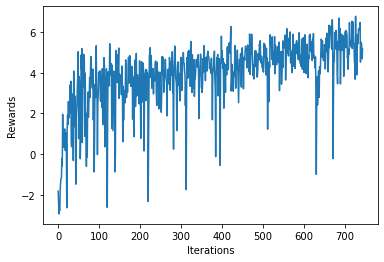

 75%|███████████████████████████████████████████████████████▉                   | 74603/100000 [49:31<17:52, 23.68it/s]

Updated Weights
Mean Reward = 5.68
11


 75%|████████████████████████████████████████████████████████                   | 74704/100000 [49:35<17:31, 24.05it/s]

Updated Weights
Mean Reward = 6.07
14


 75%|████████████████████████████████████████████████████████                   | 74806/100000 [49:38<15:23, 27.27it/s]

Updated Weights
Mean Reward = 5.38
10


 75%|████████████████████████████████████████████████████████▏                  | 74906/100000 [49:42<15:47, 26.48it/s]

Updated Weights
Mean Reward = 6.21
10


 75%|████████████████████████████████████████████████████████▎                  | 75000/100000 [49:46<16:30, 25.23it/s]

Updated Weights
Mean Reward = 6.05
10


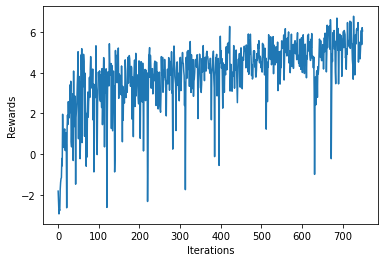

 75%|████████████████████████████████████████████████████████▎                  | 75105/100000 [49:50<15:34, 26.64it/s]

Updated Weights
Mean Reward = 5.59
9


 75%|████████████████████████████████████████████████████████▍                  | 75204/100000 [49:53<15:34, 26.52it/s]

Updated Weights
Mean Reward = 4.88
13


 75%|████████████████████████████████████████████████████████▍                  | 75304/100000 [49:57<14:46, 27.87it/s]

Updated Weights
Mean Reward = 5.16
12


 75%|████████████████████████████████████████████████████████▌                  | 75403/100000 [50:01<17:10, 23.87it/s]

Updated Weights
Mean Reward = 5.17
6


 76%|████████████████████████████████████████████████████████▋                  | 75500/100000 [50:05<15:03, 27.11it/s]

Updated Weights
Mean Reward = 6.32
13


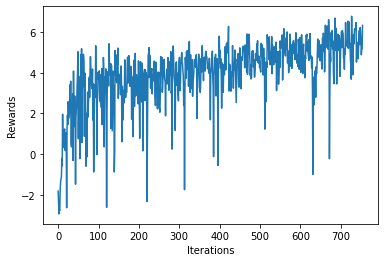

 76%|████████████████████████████████████████████████████████▋                  | 75605/100000 [50:09<15:08, 26.85it/s]

Updated Weights
Mean Reward = 6.15
13


 76%|████████████████████████████████████████████████████████▊                  | 75706/100000 [50:12<14:56, 27.09it/s]

Updated Weights
Mean Reward = 4.66
7


 76%|████████████████████████████████████████████████████████▊                  | 75804/100000 [50:16<16:41, 24.16it/s]

Updated Weights
Mean Reward = 5.49
9


 76%|████████████████████████████████████████████████████████▉                  | 75904/100000 [50:20<15:26, 26.02it/s]

Updated Weights
Mean Reward = 5.7
10


 76%|████████████████████████████████████████████████████████▉                  | 75999/100000 [50:23<16:18, 24.53it/s]

Updated Weights
Mean Reward = 6.84
14


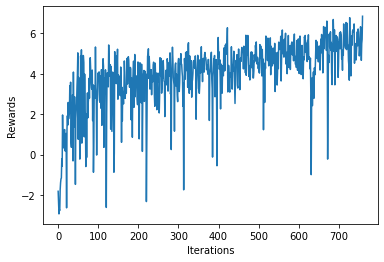

 76%|█████████████████████████████████████████████████████████                  | 76104/100000 [50:28<19:57, 19.96it/s]

Updated Weights
Mean Reward = 5.36
9


 76%|█████████████████████████████████████████████████████████▏                 | 76204/100000 [50:31<14:05, 28.16it/s]

Updated Weights
Mean Reward = 6.17
11


 76%|█████████████████████████████████████████████████████████▏                 | 76303/100000 [50:35<14:24, 27.41it/s]

Updated Weights
Mean Reward = 5.5
11


 76%|█████████████████████████████████████████████████████████▎                 | 76405/100000 [50:39<12:54, 30.48it/s]

Updated Weights
Mean Reward = 5.33
10


 76%|█████████████████████████████████████████████████████████▎                 | 76498/100000 [50:42<14:23, 27.21it/s]

Updated Weights
Mean Reward = 6.6
13


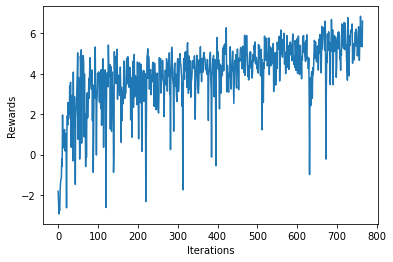

 77%|█████████████████████████████████████████████████████████▍                 | 76606/100000 [50:46<14:22, 27.14it/s]

Updated Weights
Mean Reward = 6.64
9


 77%|█████████████████████████████████████████████████████████▌                 | 76705/100000 [50:50<14:39, 26.48it/s]

Updated Weights
Mean Reward = 6.08
7


 77%|█████████████████████████████████████████████████████████▌                 | 76803/100000 [50:53<13:59, 27.63it/s]

Updated Weights
Mean Reward = 7.51
16


 77%|█████████████████████████████████████████████████████████▋                 | 76905/100000 [50:57<14:26, 26.66it/s]

Updated Weights
Mean Reward = 6.87
9


 77%|█████████████████████████████████████████████████████████▊                 | 77000/100000 [51:01<15:28, 24.77it/s]

Updated Weights
Mean Reward = 4.93
5


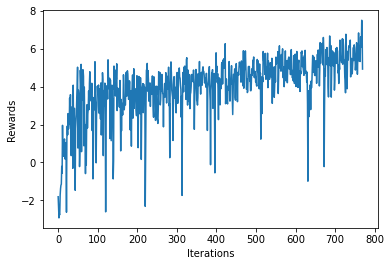

 77%|█████████████████████████████████████████████████████████▊                 | 77105/100000 [51:05<13:27, 28.36it/s]

Updated Weights
Mean Reward = 5.93
8


 77%|█████████████████████████████████████████████████████████▉                 | 77205/100000 [51:09<12:13, 31.06it/s]

Updated Weights
Mean Reward = 6.92
15


 77%|█████████████████████████████████████████████████████████▉                 | 77307/100000 [51:12<13:16, 28.48it/s]

Updated Weights
Mean Reward = 6.2
16


 77%|██████████████████████████████████████████████████████████                 | 77403/100000 [51:16<16:31, 22.79it/s]

Updated Weights
Mean Reward = 3.86
6


 77%|██████████████████████████████████████████████████████████                 | 77498/100000 [51:20<16:38, 22.55it/s]

Updated Weights
Mean Reward = 4.94
10


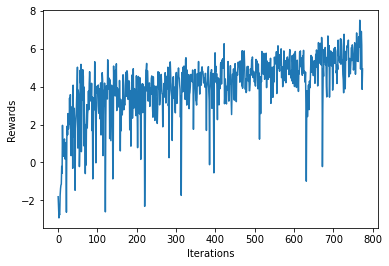

 78%|██████████████████████████████████████████████████████████▏                | 77603/100000 [51:25<18:28, 20.20it/s]

Updated Weights
Mean Reward = 5.11
7


 78%|██████████████████████████████████████████████████████████▎                | 77706/100000 [51:29<13:33, 27.41it/s]

Updated Weights
Mean Reward = 5.56
6


 78%|██████████████████████████████████████████████████████████▎                | 77806/100000 [51:33<14:24, 25.66it/s]

Updated Weights
Mean Reward = 5.5
12


 78%|██████████████████████████████████████████████████████████▍                | 77904/100000 [51:37<15:09, 24.31it/s]

Updated Weights
Mean Reward = 5.48
11


 78%|██████████████████████████████████████████████████████████▍                | 77998/100000 [51:41<12:44, 28.80it/s]

Updated Weights
Mean Reward = 5.56
9


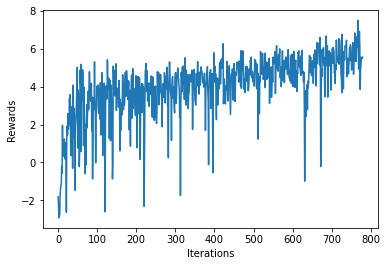

 78%|██████████████████████████████████████████████████████████▌                | 78105/100000 [51:45<14:41, 24.83it/s]

Updated Weights
Mean Reward = 4.06
6


 78%|██████████████████████████████████████████████████████████▋                | 78204/100000 [51:49<13:07, 27.68it/s]

Updated Weights
Mean Reward = 4.48
11


 78%|██████████████████████████████████████████████████████████▋                | 78305/100000 [51:52<13:26, 26.90it/s]

Updated Weights
Mean Reward = 4.64
11


 78%|██████████████████████████████████████████████████████████▊                | 78403/100000 [51:56<15:06, 23.81it/s]

Updated Weights
Mean Reward = 5.5
11


 78%|██████████████████████████████████████████████████████████▊                | 78497/100000 [51:59<12:44, 28.14it/s]

Updated Weights
Mean Reward = 5.48
11


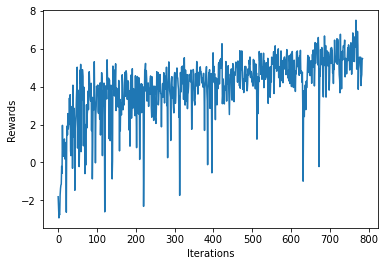

 79%|██████████████████████████████████████████████████████████▉                | 78604/100000 [52:03<12:41, 28.09it/s]

Updated Weights
Mean Reward = 5.2
8


 79%|███████████████████████████████████████████████████████████                | 78705/100000 [52:06<13:01, 27.25it/s]

Updated Weights
Mean Reward = 5.63
11


 79%|███████████████████████████████████████████████████████████                | 78804/100000 [52:10<13:13, 26.72it/s]

Updated Weights
Mean Reward = 5.17
9


 79%|███████████████████████████████████████████████████████████▏               | 78904/100000 [52:13<12:46, 27.53it/s]

Updated Weights
Mean Reward = 5.97
14


 79%|███████████████████████████████████████████████████████████▎               | 79000/100000 [52:17<12:32, 27.91it/s]

Updated Weights
Mean Reward = 5.06
8


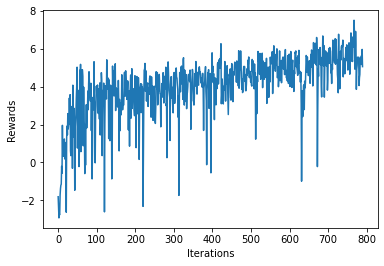

 79%|███████████████████████████████████████████████████████████▎               | 79106/100000 [52:21<13:05, 26.60it/s]

Updated Weights
Mean Reward = 6.24
10


 79%|███████████████████████████████████████████████████████████▍               | 79207/100000 [52:24<10:48, 32.04it/s]

Updated Weights
Mean Reward = 5.89
10


 79%|███████████████████████████████████████████████████████████▍               | 79307/100000 [52:28<11:53, 29.00it/s]

Updated Weights
Mean Reward = 6.46
10


 79%|███████████████████████████████████████████████████████████▌               | 79403/100000 [52:31<11:43, 29.26it/s]

Updated Weights
Mean Reward = 6.36
13


 79%|███████████████████████████████████████████████████████████▌               | 79499/100000 [52:34<12:50, 26.62it/s]

Updated Weights
Mean Reward = 4.93
4


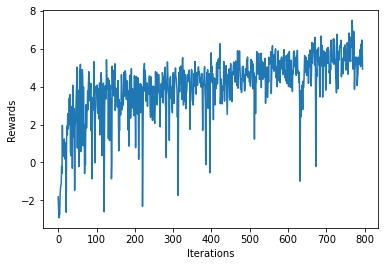

 80%|███████████████████████████████████████████████████████████▋               | 79606/100000 [52:38<11:54, 28.55it/s]

Updated Weights
Mean Reward = 6.39
14


 80%|███████████████████████████████████████████████████████████▊               | 79704/100000 [52:42<11:52, 28.47it/s]

Updated Weights
Mean Reward = 5.83
11


 80%|███████████████████████████████████████████████████████████▊               | 79805/100000 [52:45<11:50, 28.40it/s]

Updated Weights
Mean Reward = 5.67
7


 80%|███████████████████████████████████████████████████████████▉               | 79904/100000 [52:49<11:53, 28.17it/s]

Updated Weights
Mean Reward = 5.06
7


 80%|███████████████████████████████████████████████████████████▉               | 79997/100000 [52:52<10:16, 32.42it/s]

Updated Weights
Mean Reward = 5.9
9


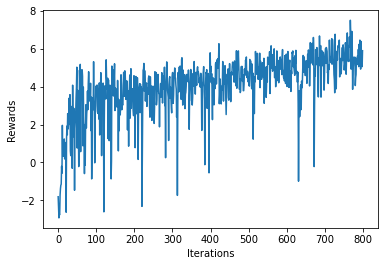

 80%|████████████████████████████████████████████████████████████               | 80106/100000 [52:56<11:05, 29.88it/s]

Updated Weights
Mean Reward = 6.84
12


 80%|████████████████████████████████████████████████████████████▏              | 80203/100000 [53:00<12:25, 26.56it/s]

Updated Weights
Mean Reward = 3.65
5


 80%|████████████████████████████████████████████████████████████▏              | 80305/100000 [53:03<11:15, 29.16it/s]

Updated Weights
Mean Reward = 2.37
14


 80%|████████████████████████████████████████████████████████████▎              | 80403/100000 [53:07<12:19, 26.52it/s]

Updated Weights
Mean Reward = 6.0
9


 80%|████████████████████████████████████████████████████████████▎              | 80499/100000 [53:10<11:55, 27.24it/s]

Updated Weights
Mean Reward = 5.82
12


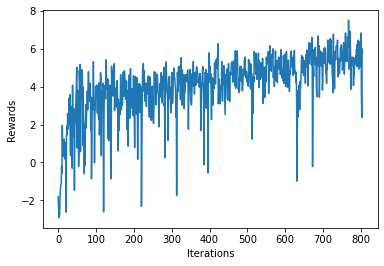

 81%|████████████████████████████████████████████████████████████▍              | 80605/100000 [53:14<11:14, 28.76it/s]

Updated Weights
Mean Reward = 5.97
12


 81%|████████████████████████████████████████████████████████████▌              | 80706/100000 [53:17<10:54, 29.48it/s]

Updated Weights
Mean Reward = 6.13
14


 81%|████████████████████████████████████████████████████████████▌              | 80806/100000 [53:21<11:11, 28.60it/s]

Updated Weights
Mean Reward = 6.49
10


 81%|████████████████████████████████████████████████████████████▋              | 80906/100000 [53:24<11:39, 27.30it/s]

Updated Weights
Mean Reward = 5.59
10


 81%|████████████████████████████████████████████████████████████▊              | 81000/100000 [53:28<12:21, 25.61it/s]

Updated Weights
Mean Reward = 5.47
10


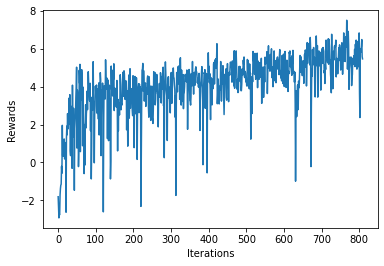

 81%|████████████████████████████████████████████████████████████▊              | 81104/100000 [53:32<10:45, 29.26it/s]

Updated Weights
Mean Reward = 5.79
12


 81%|████████████████████████████████████████████████████████████▉              | 81207/100000 [53:35<10:49, 28.95it/s]

Updated Weights
Mean Reward = 5.78
12


 81%|████████████████████████████████████████████████████████████▉              | 81304/100000 [53:40<13:59, 22.27it/s]

Updated Weights
Mean Reward = 6.15
11


 81%|█████████████████████████████████████████████████████████████              | 81403/100000 [53:47<15:55, 19.46it/s]

Updated Weights
Mean Reward = 5.77
9


 82%|█████████████████████████████████████████████████████████████              | 81500/100000 [53:52<13:57, 22.09it/s]

Updated Weights
Mean Reward = 5.12
12


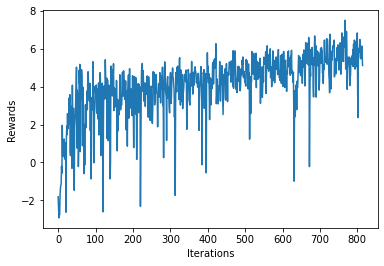

 82%|█████████████████████████████████████████████████████████████▏             | 81602/100000 [54:03<38:45,  7.91it/s]

Updated Weights
Mean Reward = 6.12
10


 82%|█████████████████████████████████████████████████████████████▎             | 81704/100000 [54:09<14:35, 20.91it/s]

Updated Weights
Mean Reward = 6.57
9


 82%|█████████████████████████████████████████████████████████████▎             | 81803/100000 [54:14<16:31, 18.36it/s]

Updated Weights
Mean Reward = 5.72
8


 82%|█████████████████████████████████████████████████████████████▍             | 81903/100000 [54:19<15:04, 20.00it/s]

Updated Weights
Mean Reward = 4.98
9


 82%|█████████████████████████████████████████████████████████████▍             | 82000/100000 [54:24<14:50, 20.20it/s]

Updated Weights
Mean Reward = 5.2
8


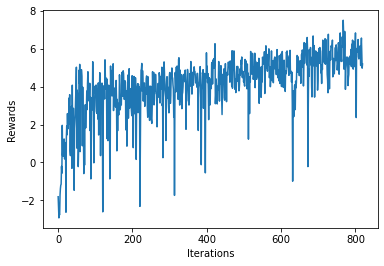

 82%|█████████████████████████████████████████████████████████████▌             | 82104/100000 [54:29<15:29, 19.26it/s]

Updated Weights
Mean Reward = 5.82
8


 82%|█████████████████████████████████████████████████████████████▋             | 82203/100000 [54:34<15:31, 19.12it/s]

Updated Weights
Mean Reward = 5.38
11


 82%|█████████████████████████████████████████████████████████████▋             | 82304/100000 [54:39<14:26, 20.41it/s]

Updated Weights
Mean Reward = 5.77
9


 82%|█████████████████████████████████████████████████████████████▊             | 82403/100000 [54:44<13:55, 21.07it/s]

Updated Weights
Mean Reward = 6.02
12


 82%|█████████████████████████████████████████████████████████████▊             | 82499/100000 [54:49<14:02, 20.77it/s]

Updated Weights
Mean Reward = 6.07
14


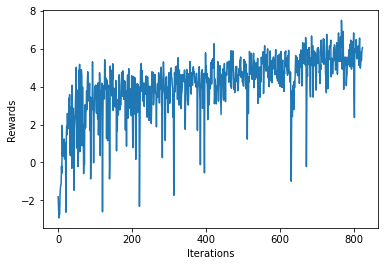

 83%|█████████████████████████████████████████████████████████████▉             | 82605/100000 [54:54<14:18, 20.26it/s]

Updated Weights
Mean Reward = 5.45
9


 83%|██████████████████████████████████████████████████████████████             | 82703/100000 [54:59<17:10, 16.78it/s]

Updated Weights
Mean Reward = 6.79
13


 83%|██████████████████████████████████████████████████████████████             | 82803/100000 [55:05<16:19, 17.56it/s]

Updated Weights
Mean Reward = 5.76
5


 83%|██████████████████████████████████████████████████████████████▏            | 82903/100000 [55:10<15:36, 18.26it/s]

Updated Weights
Mean Reward = 5.03
12


 83%|██████████████████████████████████████████████████████████████▏            | 82998/100000 [55:16<14:19, 19.78it/s]

Updated Weights
Mean Reward = 5.23
14


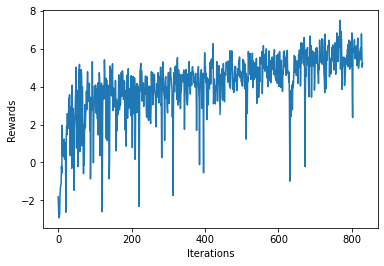

 83%|██████████████████████████████████████████████████████████████▎            | 83105/100000 [55:22<15:13, 18.48it/s]

Updated Weights
Mean Reward = 4.46
6


 83%|██████████████████████████████████████████████████████████████▍            | 83204/100000 [55:28<15:09, 18.46it/s]

Updated Weights
Mean Reward = 4.74
9


 83%|██████████████████████████████████████████████████████████████▍            | 83304/100000 [55:33<15:28, 17.98it/s]

Updated Weights
Mean Reward = 5.13
9


 83%|██████████████████████████████████████████████████████████████▌            | 83403/100000 [55:39<16:13, 17.05it/s]

Updated Weights
Mean Reward = 5.61
8


 83%|██████████████████████████████████████████████████████████████▌            | 83498/100000 [55:44<16:00, 17.17it/s]

Updated Weights
Mean Reward = 5.82
13


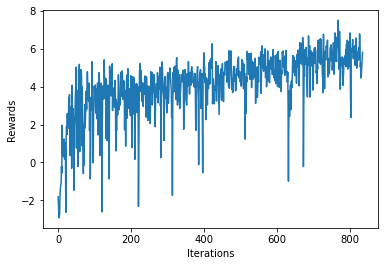

 84%|██████████████████████████████████████████████████████████████▋            | 83605/100000 [55:50<14:25, 18.94it/s]

Updated Weights
Mean Reward = 5.85
10


 84%|██████████████████████████████████████████████████████████████▊            | 83703/100000 [55:56<15:50, 17.15it/s]

Updated Weights
Mean Reward = 4.91
7


 84%|██████████████████████████████████████████████████████████████▊            | 83804/100000 [56:02<15:29, 17.43it/s]

Updated Weights
Mean Reward = 6.18
12


 84%|██████████████████████████████████████████████████████████████▉            | 83904/100000 [56:07<14:46, 18.17it/s]

Updated Weights
Mean Reward = 5.37
14


 84%|███████████████████████████████████████████████████████████████            | 84000/100000 [56:12<15:36, 17.09it/s]

Updated Weights
Mean Reward = 5.14
9


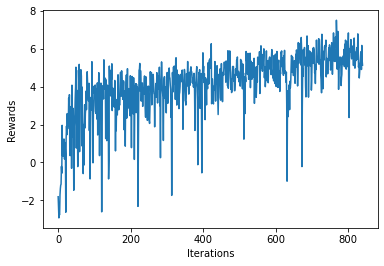

 84%|███████████████████████████████████████████████████████████████            | 84103/100000 [56:19<14:19, 18.48it/s]

Updated Weights
Mean Reward = 5.71
11


 84%|███████████████████████████████████████████████████████████████▏           | 84205/100000 [56:24<13:44, 19.16it/s]

Updated Weights
Mean Reward = 5.3
6


 84%|███████████████████████████████████████████████████████████████▏           | 84303/100000 [56:30<15:08, 17.27it/s]

Updated Weights
Mean Reward = 5.87
6


 84%|███████████████████████████████████████████████████████████████▎           | 84404/100000 [56:35<13:46, 18.86it/s]

Updated Weights
Mean Reward = 5.73
10


 84%|███████████████████████████████████████████████████████████████▍           | 84500/100000 [56:41<14:26, 17.89it/s]

Updated Weights
Mean Reward = 5.17
7


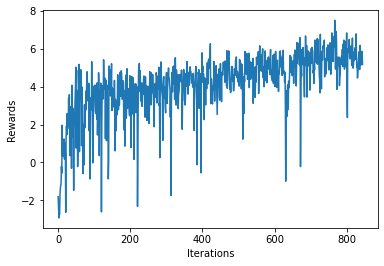

 85%|███████████████████████████████████████████████████████████████▍           | 84604/100000 [56:47<14:19, 17.91it/s]

Updated Weights
Mean Reward = 4.74
10


 85%|███████████████████████████████████████████████████████████████▌           | 84703/100000 [56:52<14:31, 17.55it/s]

Updated Weights
Mean Reward = 6.13
9


 85%|███████████████████████████████████████████████████████████████▌           | 84804/100000 [56:58<13:05, 19.34it/s]

Updated Weights
Mean Reward = 6.78
14


 85%|███████████████████████████████████████████████████████████████▋           | 84903/100000 [57:03<14:52, 16.92it/s]

Updated Weights
Mean Reward = 6.4
10


 85%|███████████████████████████████████████████████████████████████▋           | 84999/100000 [57:09<14:00, 17.84it/s]

Updated Weights
Mean Reward = 5.2
6


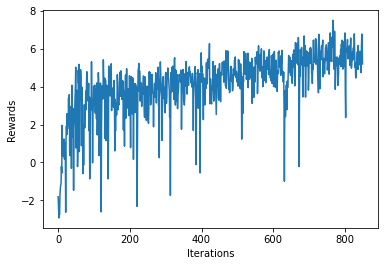

 85%|███████████████████████████████████████████████████████████████▊           | 85104/100000 [57:15<14:51, 16.70it/s]

Updated Weights
Mean Reward = 5.62
5


 85%|███████████████████████████████████████████████████████████████▉           | 85203/100000 [57:20<14:28, 17.04it/s]

Updated Weights
Mean Reward = 5.75
15


 85%|███████████████████████████████████████████████████████████████▉           | 85303/100000 [57:26<14:03, 17.41it/s]

Updated Weights
Mean Reward = 5.6
12


 85%|████████████████████████████████████████████████████████████████           | 85403/100000 [57:32<14:19, 16.99it/s]

Updated Weights
Mean Reward = 5.94
7


 85%|████████████████████████████████████████████████████████████████           | 85499/100000 [57:37<13:49, 17.49it/s]

Updated Weights
Mean Reward = 4.2
3


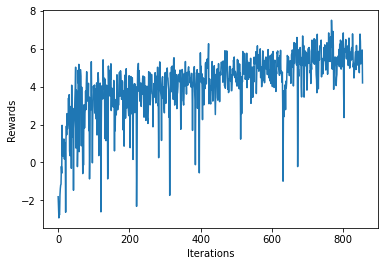

 86%|████████████████████████████████████████████████████████████████▏          | 85604/100000 [57:43<11:21, 21.13it/s]

Updated Weights
Mean Reward = 5.88
13


 86%|████████████████████████████████████████████████████████████████▎          | 85704/100000 [57:49<13:10, 18.08it/s]

Updated Weights
Mean Reward = 5.63
10


 86%|████████████████████████████████████████████████████████████████▎          | 85804/100000 [57:54<13:21, 17.71it/s]

Updated Weights
Mean Reward = 5.73
7


 86%|████████████████████████████████████████████████████████████████▍          | 85903/100000 [58:00<14:28, 16.24it/s]

Updated Weights
Mean Reward = 5.35
11


 86%|████████████████████████████████████████████████████████████████▍          | 85999/100000 [58:05<12:53, 18.10it/s]

Updated Weights
Mean Reward = 5.86
11


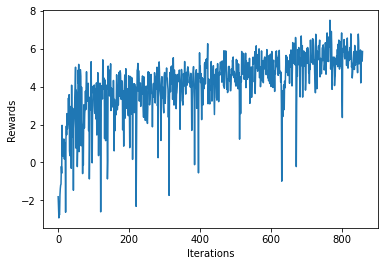

 86%|████████████████████████████████████████████████████████████████▌          | 86103/100000 [58:11<12:41, 18.25it/s]

Updated Weights
Mean Reward = 5.88
15


 86%|████████████████████████████████████████████████████████████████▋          | 86203/100000 [58:17<12:20, 18.62it/s]

Updated Weights
Mean Reward = 4.56
11


 86%|████████████████████████████████████████████████████████████████▋          | 86304/100000 [58:22<12:37, 18.09it/s]

Updated Weights
Mean Reward = 4.48
7


 86%|████████████████████████████████████████████████████████████████▊          | 86403/100000 [58:28<16:11, 14.00it/s]

Updated Weights
Mean Reward = 4.22
13


 86%|████████████████████████████████████████████████████████████████▉          | 86500/100000 [58:33<08:44, 25.72it/s]

Updated Weights
Mean Reward = 6.66
19


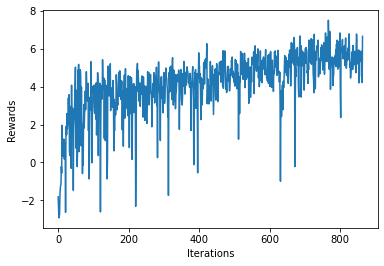

 87%|████████████████████████████████████████████████████████████████▉          | 86603/100000 [58:40<19:13, 11.61it/s]

Updated Weights
Mean Reward = 5.86
12


 87%|█████████████████████████████████████████████████████████████████          | 86702/100000 [58:46<15:20, 14.45it/s]

Updated Weights
Mean Reward = 6.31
9


 87%|█████████████████████████████████████████████████████████████████          | 86803/100000 [58:53<16:50, 13.06it/s]

Updated Weights
Mean Reward = 5.32
10


 87%|█████████████████████████████████████████████████████████████████▏         | 86904/100000 [59:01<12:27, 17.53it/s]

Updated Weights
Mean Reward = 5.96
12


 87%|█████████████████████████████████████████████████████████████████▏         | 86999/100000 [59:07<11:37, 18.64it/s]

Updated Weights
Mean Reward = 6.86
10


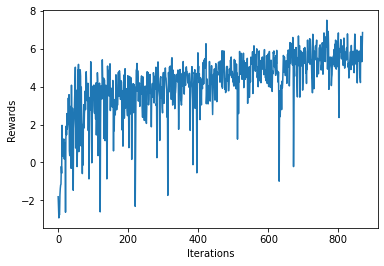

 87%|█████████████████████████████████████████████████████████████████▎         | 87101/100000 [59:12<13:05, 16.42it/s]

Updated Weights
Mean Reward = 6.31
8


 87%|█████████████████████████████████████████████████████████████████▍         | 87205/100000 [59:19<11:28, 18.60it/s]

Updated Weights
Mean Reward = 6.52
9


 87%|█████████████████████████████████████████████████████████████████▍         | 87304/100000 [59:23<08:01, 26.38it/s]

Updated Weights
Mean Reward = 6.38
13


 87%|█████████████████████████████████████████████████████████████████▌         | 87405/100000 [59:27<10:10, 20.62it/s]

Updated Weights
Mean Reward = 5.96
17


 87%|█████████████████████████████████████████████████████████████████▌         | 87499/100000 [59:31<08:00, 26.02it/s]

Updated Weights
Mean Reward = 4.73
12


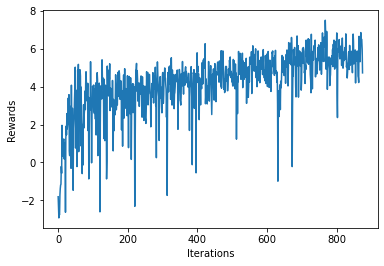

 88%|█████████████████████████████████████████████████████████████████▋         | 87606/100000 [59:35<07:42, 26.83it/s]

Updated Weights
Mean Reward = 5.74
11


 88%|█████████████████████████████████████████████████████████████████▊         | 87705/100000 [59:39<08:02, 25.49it/s]

Updated Weights
Mean Reward = 5.94
11


 88%|█████████████████████████████████████████████████████████████████▊         | 87802/100000 [59:43<09:34, 21.23it/s]

Updated Weights
Mean Reward = 5.77
11


 88%|█████████████████████████████████████████████████████████████████▉         | 87903/100000 [59:48<09:00, 22.36it/s]

Updated Weights
Mean Reward = 3.1
7


 88%|█████████████████████████████████████████████████████████████████▉         | 87999/100000 [59:52<08:40, 23.04it/s]

Updated Weights
Mean Reward = 4.74
14


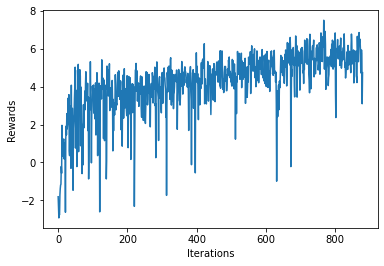

 88%|██████████████████████████████████████████████████████████████████         | 88105/100000 [59:57<09:33, 20.73it/s]

Updated Weights
Mean Reward = 5.9
15


 88%|████████████████████████████████████████████████████████████████▍        | 88205/100000 [1:00:01<07:22, 26.67it/s]

Updated Weights
Mean Reward = 5.28
14


 88%|████████████████████████████████████████████████████████████████▍        | 88306/100000 [1:00:05<06:26, 30.23it/s]

Updated Weights
Mean Reward = 5.59
8


 88%|████████████████████████████████████████████████████████████████▌        | 88407/100000 [1:00:09<06:49, 28.28it/s]

Updated Weights
Mean Reward = 6.43
10


 88%|████████████████████████████████████████████████████████████████▌        | 88499/100000 [1:00:12<06:41, 28.66it/s]

Updated Weights
Mean Reward = 5.85
11


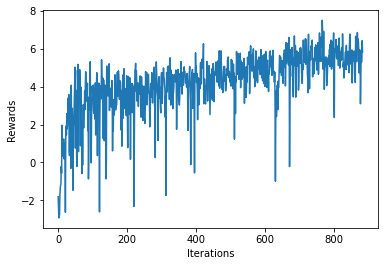

 89%|████████████████████████████████████████████████████████████████▋        | 88604/100000 [1:00:16<06:54, 27.47it/s]

Updated Weights
Mean Reward = 5.19
11


 89%|████████████████████████████████████████████████████████████████▊        | 88706/100000 [1:00:20<07:09, 26.32it/s]

Updated Weights
Mean Reward = 5.38
7


 89%|████████████████████████████████████████████████████████████████▊        | 88804/100000 [1:00:23<06:48, 27.38it/s]

Updated Weights
Mean Reward = 5.97
11


 89%|████████████████████████████████████████████████████████████████▉        | 88906/100000 [1:00:27<07:06, 26.00it/s]

Updated Weights
Mean Reward = 6.29
13


 89%|████████████████████████████████████████████████████████████████▉        | 88999/100000 [1:00:30<06:55, 26.50it/s]

Updated Weights
Mean Reward = 5.08
5


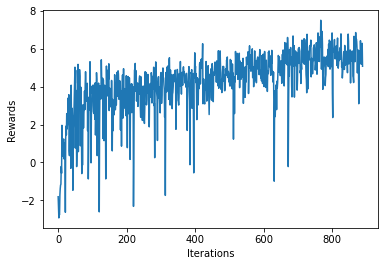

 89%|█████████████████████████████████████████████████████████████████        | 89103/100000 [1:00:34<06:20, 28.62it/s]

Updated Weights
Mean Reward = 5.95
14


 89%|█████████████████████████████████████████████████████████████████        | 89203/100000 [1:00:38<06:44, 26.72it/s]

Updated Weights
Mean Reward = 5.61
11


 89%|█████████████████████████████████████████████████████████████████▏       | 89305/100000 [1:00:42<06:30, 27.42it/s]

Updated Weights
Mean Reward = 5.15
11


 89%|█████████████████████████████████████████████████████████████████▎       | 89406/100000 [1:00:45<06:32, 27.02it/s]

Updated Weights
Mean Reward = 4.36
10


 89%|█████████████████████████████████████████████████████████████████▎       | 89498/100000 [1:00:49<06:50, 25.60it/s]

Updated Weights
Mean Reward = 1.35
3


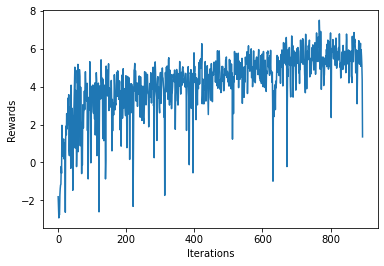

 90%|█████████████████████████████████████████████████████████████████▍       | 89606/100000 [1:00:53<06:26, 26.92it/s]

Updated Weights
Mean Reward = 5.07
11


 90%|█████████████████████████████████████████████████████████████████▍       | 89705/100000 [1:00:56<06:33, 26.17it/s]

Updated Weights
Mean Reward = 5.81
13


 90%|█████████████████████████████████████████████████████████████████▌       | 89804/100000 [1:01:00<06:03, 28.05it/s]

Updated Weights
Mean Reward = 6.08
13


 90%|█████████████████████████████████████████████████████████████████▋       | 89906/100000 [1:01:03<05:59, 28.06it/s]

Updated Weights
Mean Reward = 6.16
17


 90%|█████████████████████████████████████████████████████████████████▋       | 89999/100000 [1:01:07<05:31, 30.19it/s]

Updated Weights
Mean Reward = 5.37
11


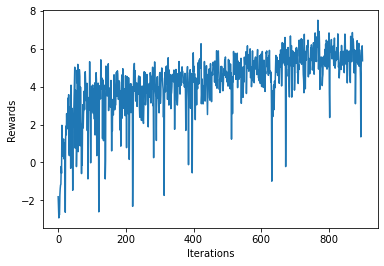

 90%|█████████████████████████████████████████████████████████████████▊       | 90102/100000 [1:01:10<05:34, 29.58it/s]

Updated Weights
Mean Reward = 4.77
11


 90%|█████████████████████████████████████████████████████████████████▊       | 90204/100000 [1:01:14<05:50, 27.95it/s]

Updated Weights
Mean Reward = 5.1
15


 90%|█████████████████████████████████████████████████████████████████▉       | 90306/100000 [1:01:18<06:20, 25.49it/s]

Updated Weights
Mean Reward = 5.42
11


 90%|█████████████████████████████████████████████████████████████████▉       | 90403/100000 [1:01:21<05:52, 27.22it/s]

Updated Weights
Mean Reward = 5.56
11


 90%|██████████████████████████████████████████████████████████████████       | 90499/100000 [1:01:25<05:53, 26.90it/s]

Updated Weights
Mean Reward = 2.72
6


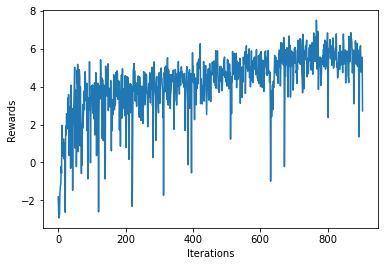

 91%|██████████████████████████████████████████████████████████████████▏      | 90604/100000 [1:01:29<05:48, 26.96it/s]

Updated Weights
Mean Reward = 4.45
7


 91%|██████████████████████████████████████████████████████████████████▏      | 90704/100000 [1:01:32<05:26, 28.48it/s]

Updated Weights
Mean Reward = 4.89
6


 91%|██████████████████████████████████████████████████████████████████▎      | 90804/100000 [1:01:36<05:42, 26.82it/s]

Updated Weights
Mean Reward = 6.52
14


 91%|██████████████████████████████████████████████████████████████████▎      | 90905/100000 [1:01:40<05:45, 26.35it/s]

Updated Weights
Mean Reward = 6.25
13


 91%|██████████████████████████████████████████████████████████████████▍      | 90997/100000 [1:01:43<05:36, 26.75it/s]

Updated Weights
Mean Reward = 6.41
15


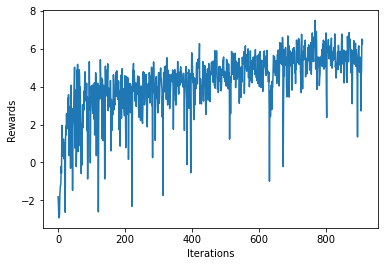

 91%|██████████████████████████████████████████████████████████████████▌      | 91104/100000 [1:01:47<05:29, 26.96it/s]

Updated Weights
Mean Reward = 5.7
13


 91%|██████████████████████████████████████████████████████████████████▌      | 91205/100000 [1:01:50<05:14, 27.97it/s]

Updated Weights
Mean Reward = 5.64
13


 91%|██████████████████████████████████████████████████████████████████▋      | 91304/100000 [1:01:54<05:22, 26.95it/s]

Updated Weights
Mean Reward = 5.75
7


 91%|██████████████████████████████████████████████████████████████████▋      | 91406/100000 [1:01:58<05:14, 27.31it/s]

Updated Weights
Mean Reward = 5.4
9


 91%|██████████████████████████████████████████████████████████████████▊      | 91498/100000 [1:02:01<05:15, 26.91it/s]

Updated Weights
Mean Reward = 5.54
8


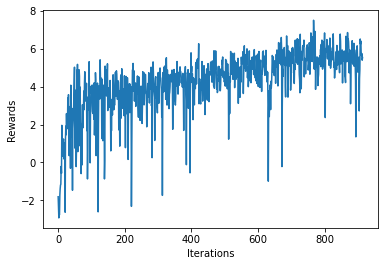

 92%|██████████████████████████████████████████████████████████████████▊      | 91606/100000 [1:02:05<05:14, 26.66it/s]

Updated Weights
Mean Reward = 5.5
11


 92%|██████████████████████████████████████████████████████████████████▉      | 91704/100000 [1:02:09<05:22, 25.70it/s]

Updated Weights
Mean Reward = 5.23
8


 92%|███████████████████████████████████████████████████████████████████      | 91806/100000 [1:02:12<05:12, 26.23it/s]

Updated Weights
Mean Reward = 5.46
11


 92%|███████████████████████████████████████████████████████████████████      | 91904/100000 [1:02:16<05:12, 25.89it/s]

Updated Weights
Mean Reward = 5.97
8


 92%|███████████████████████████████████████████████████████████████████▏     | 91998/100000 [1:02:20<05:09, 25.88it/s]

Updated Weights
Mean Reward = 4.97
5


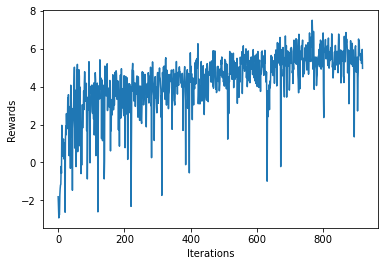

 92%|███████████████████████████████████████████████████████████████████▏     | 92105/100000 [1:02:24<04:47, 27.44it/s]

Updated Weights
Mean Reward = 6.15
10


 92%|███████████████████████████████████████████████████████████████████▎     | 92207/100000 [1:02:27<04:49, 26.90it/s]

Updated Weights
Mean Reward = 6.43
16


 92%|███████████████████████████████████████████████████████████████████▍     | 92306/100000 [1:02:31<04:34, 28.01it/s]

Updated Weights
Mean Reward = 6.39
13


 92%|███████████████████████████████████████████████████████████████████▍     | 92406/100000 [1:02:34<04:43, 26.78it/s]

Updated Weights
Mean Reward = 5.96
10


 92%|███████████████████████████████████████████████████████████████████▌     | 92500/100000 [1:02:38<04:35, 27.24it/s]

Updated Weights
Mean Reward = 5.99
13


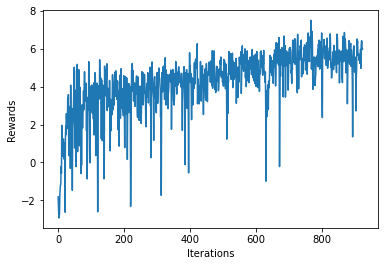

 93%|███████████████████████████████████████████████████████████████████▌     | 92606/100000 [1:02:42<04:38, 26.55it/s]

Updated Weights
Mean Reward = 6.29
7


 93%|███████████████████████████████████████████████████████████████████▋     | 92705/100000 [1:02:45<04:39, 26.09it/s]

Updated Weights
Mean Reward = 6.17
16


 93%|███████████████████████████████████████████████████████████████████▋     | 92806/100000 [1:02:49<04:19, 27.70it/s]

Updated Weights
Mean Reward = 6.81
14


 93%|███████████████████████████████████████████████████████████████████▊     | 92906/100000 [1:02:53<04:18, 27.48it/s]

Updated Weights
Mean Reward = 6.8
10


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:02:56<04:23, 26.53it/s]

Updated Weights
Mean Reward = 5.73
13


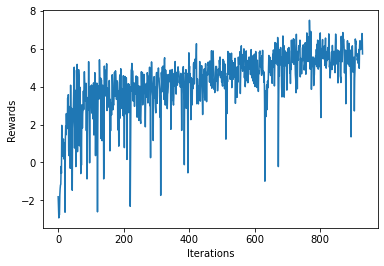

 93%|███████████████████████████████████████████████████████████████████▉     | 93106/100000 [1:03:00<04:01, 28.50it/s]

Updated Weights
Mean Reward = 6.02
14


 93%|████████████████████████████████████████████████████████████████████     | 93206/100000 [1:03:03<04:04, 27.76it/s]

Updated Weights
Mean Reward = 3.0
10


 93%|████████████████████████████████████████████████████████████████████     | 93306/100000 [1:03:07<04:01, 27.67it/s]

Updated Weights
Mean Reward = 2.49
9


 93%|████████████████████████████████████████████████████████████████████▏    | 93405/100000 [1:03:11<04:08, 26.53it/s]

Updated Weights
Mean Reward = 6.13
7


 93%|████████████████████████████████████████████████████████████████████▎    | 93499/100000 [1:03:14<04:07, 26.22it/s]

Updated Weights
Mean Reward = 6.01
8


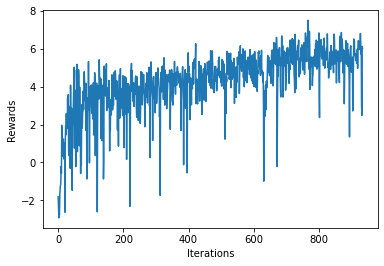

 94%|████████████████████████████████████████████████████████████████████▎    | 93605/100000 [1:03:18<03:45, 28.37it/s]

Updated Weights
Mean Reward = 5.07
11


 94%|████████████████████████████████████████████████████████████████████▍    | 93706/100000 [1:03:22<03:59, 26.31it/s]

Updated Weights
Mean Reward = 6.12
9


 94%|████████████████████████████████████████████████████████████████████▍    | 93804/100000 [1:03:25<03:24, 30.34it/s]

Updated Weights
Mean Reward = 5.13
13


 94%|████████████████████████████████████████████████████████████████████▌    | 93906/100000 [1:03:29<03:41, 27.51it/s]

Updated Weights
Mean Reward = 5.08
8


 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [1:03:32<03:41, 27.07it/s]

Updated Weights
Mean Reward = 6.0
14


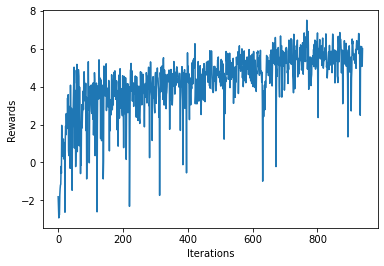

 94%|████████████████████████████████████████████████████████████████████▋    | 94104/100000 [1:03:36<03:46, 26.05it/s]

Updated Weights
Mean Reward = 5.63
8


 94%|████████████████████████████████████████████████████████████████████▊    | 94204/100000 [1:03:40<03:36, 26.78it/s]

Updated Weights
Mean Reward = 5.57
10


 94%|████████████████████████████████████████████████████████████████████▊    | 94306/100000 [1:03:44<03:39, 26.00it/s]

Updated Weights
Mean Reward = 6.15
8


 94%|████████████████████████████████████████████████████████████████████▉    | 94406/100000 [1:03:48<03:37, 25.68it/s]

Updated Weights
Mean Reward = 6.36
11


 94%|████████████████████████████████████████████████████████████████████▉    | 94500/100000 [1:03:51<03:03, 30.01it/s]

Updated Weights
Mean Reward = 6.51
9


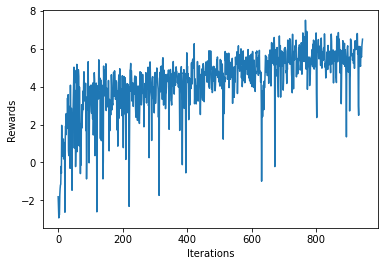

 95%|█████████████████████████████████████████████████████████████████████    | 94605/100000 [1:03:55<03:22, 26.68it/s]

Updated Weights
Mean Reward = 5.25
3


 95%|█████████████████████████████████████████████████████████████████████▏   | 94706/100000 [1:03:59<03:29, 25.26it/s]

Updated Weights
Mean Reward = 5.26
7


 95%|█████████████████████████████████████████████████████████████████████▏   | 94806/100000 [1:04:03<02:54, 29.85it/s]

Updated Weights
Mean Reward = 6.12
13


 95%|█████████████████████████████████████████████████████████████████████▎   | 94905/100000 [1:04:06<03:07, 27.24it/s]

Updated Weights
Mean Reward = 5.5
6


 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [1:04:10<03:12, 26.02it/s]

Updated Weights
Mean Reward = 5.65
9


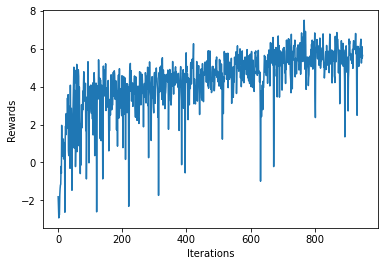

 95%|█████████████████████████████████████████████████████████████████████▍   | 95104/100000 [1:04:14<03:03, 26.65it/s]

Updated Weights
Mean Reward = 5.32
10


 95%|█████████████████████████████████████████████████████████████████████▌   | 95206/100000 [1:04:17<02:51, 27.99it/s]

Updated Weights
Mean Reward = 5.86
9


 95%|█████████████████████████████████████████████████████████████████████▌   | 95304/100000 [1:04:21<02:38, 29.56it/s]

Updated Weights
Mean Reward = 6.23
16


 95%|█████████████████████████████████████████████████████████████████████▋   | 95404/100000 [1:04:25<02:52, 26.71it/s]

Updated Weights
Mean Reward = 6.12
8


 95%|█████████████████████████████████████████████████████████████████████▋   | 95499/100000 [1:04:28<02:46, 27.11it/s]

Updated Weights
Mean Reward = 6.24
7


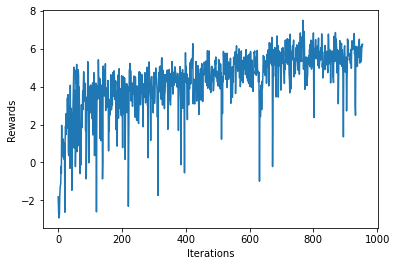

 96%|█████████████████████████████████████████████████████████████████████▊   | 95605/100000 [1:04:32<02:45, 26.61it/s]

Updated Weights
Mean Reward = 6.0
12


 96%|█████████████████████████████████████████████████████████████████████▊   | 95706/100000 [1:04:36<02:50, 25.17it/s]

Updated Weights
Mean Reward = 5.56
11


 96%|█████████████████████████████████████████████████████████████████████▉   | 95806/100000 [1:04:39<02:31, 27.62it/s]

Updated Weights
Mean Reward = 5.68
9


 96%|██████████████████████████████████████████████████████████████████████   | 95904/100000 [1:04:43<02:33, 26.69it/s]

Updated Weights
Mean Reward = 5.26
11


 96%|██████████████████████████████████████████████████████████████████████   | 95999/100000 [1:04:46<02:17, 29.18it/s]

Updated Weights
Mean Reward = 4.53
12


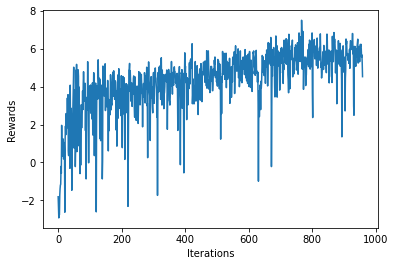

 96%|██████████████████████████████████████████████████████████████████████▏  | 96103/100000 [1:04:51<03:32, 18.38it/s]

Updated Weights
Mean Reward = 5.55
9


 96%|██████████████████████████████████████████████████████████████████████▏  | 96204/100000 [1:04:56<02:24, 26.25it/s]

Updated Weights
Mean Reward = 3.24
2


 96%|██████████████████████████████████████████████████████████████████████▎  | 96304/100000 [1:05:00<02:20, 26.35it/s]

Updated Weights
Mean Reward = 4.98
11


 96%|██████████████████████████████████████████████████████████████████████▍  | 96406/100000 [1:05:03<02:18, 25.91it/s]

Updated Weights
Mean Reward = 6.45
10


 96%|██████████████████████████████████████████████████████████████████████▍  | 96498/100000 [1:05:07<02:13, 26.32it/s]

Updated Weights
Mean Reward = 4.83
10


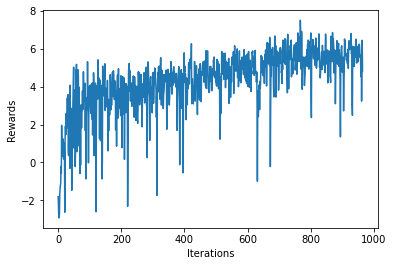

 97%|██████████████████████████████████████████████████████████████████████▌  | 96605/100000 [1:05:11<02:08, 26.36it/s]

Updated Weights
Mean Reward = 6.35
15


 97%|██████████████████████████████████████████████████████████████████████▌  | 96704/100000 [1:05:14<02:05, 26.34it/s]

Updated Weights
Mean Reward = 5.29
10


 97%|██████████████████████████████████████████████████████████████████████▋  | 96803/100000 [1:05:18<02:04, 25.72it/s]

Updated Weights
Mean Reward = 5.2
11


 97%|██████████████████████████████████████████████████████████████████████▋  | 96905/100000 [1:05:22<02:00, 25.64it/s]

Updated Weights
Mean Reward = 6.19
12


 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [1:05:25<01:48, 27.71it/s]

Updated Weights
Mean Reward = 5.81
10


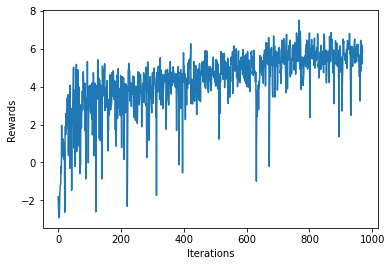

 97%|██████████████████████████████████████████████████████████████████████▉  | 97107/100000 [1:05:29<01:44, 27.59it/s]

Updated Weights
Mean Reward = 5.78
14


 97%|██████████████████████████████████████████████████████████████████████▉  | 97205/100000 [1:05:33<01:33, 29.81it/s]

Updated Weights
Mean Reward = 4.85
12


 97%|███████████████████████████████████████████████████████████████████████  | 97304/100000 [1:05:36<01:38, 27.44it/s]

Updated Weights
Mean Reward = 4.83
10


 97%|███████████████████████████████████████████████████████████████████████  | 97406/100000 [1:05:40<01:31, 28.50it/s]

Updated Weights
Mean Reward = 4.7
10


 97%|███████████████████████████████████████████████████████████████████████▏ | 97499/100000 [1:05:43<01:28, 28.26it/s]

Updated Weights
Mean Reward = 5.7
10


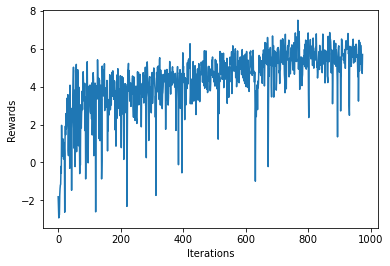

 98%|███████████████████████████████████████████████████████████████████████▎ | 97605/100000 [1:05:47<01:33, 25.65it/s]

Updated Weights
Mean Reward = 5.24
9


 98%|███████████████████████████████████████████████████████████████████████▎ | 97706/100000 [1:05:51<01:25, 26.86it/s]

Updated Weights
Mean Reward = 5.93
9


 98%|███████████████████████████████████████████████████████████████████████▍ | 97804/100000 [1:05:54<01:18, 27.97it/s]

Updated Weights
Mean Reward = 6.01
15


 98%|███████████████████████████████████████████████████████████████████████▍ | 97904/100000 [1:05:58<01:18, 26.65it/s]

Updated Weights
Mean Reward = 5.48
7


 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [1:06:02<01:17, 25.92it/s]

Updated Weights
Mean Reward = 5.23
9


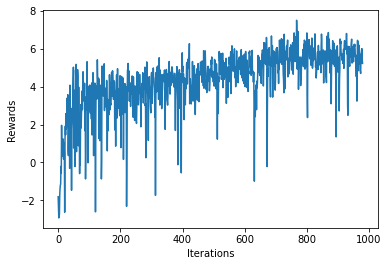

 98%|███████████████████████████████████████████████████████████████████████▌ | 98107/100000 [1:06:06<01:07, 27.99it/s]

Updated Weights
Mean Reward = 4.45
11


 98%|███████████████████████████████████████████████████████████████████████▋ | 98206/100000 [1:06:09<01:07, 26.47it/s]

Updated Weights
Mean Reward = 5.66
17


 98%|███████████████████████████████████████████████████████████████████████▊ | 98306/100000 [1:06:13<01:03, 26.78it/s]

Updated Weights
Mean Reward = 5.22
8


 98%|███████████████████████████████████████████████████████████████████████▊ | 98406/100000 [1:06:16<01:01, 26.03it/s]

Updated Weights
Mean Reward = 5.62
8


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [1:06:20<00:51, 29.27it/s]

Updated Weights
Mean Reward = 6.33
14


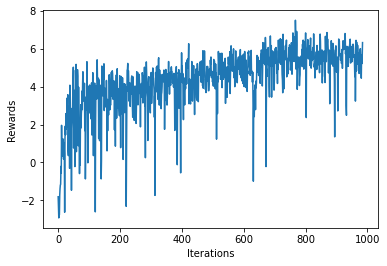

 99%|███████████████████████████████████████████████████████████████████████▉ | 98607/100000 [1:06:24<00:47, 29.38it/s]

Updated Weights
Mean Reward = 4.03
5


 99%|████████████████████████████████████████████████████████████████████████ | 98706/100000 [1:06:27<00:46, 27.56it/s]

Updated Weights
Mean Reward = 5.99
11


 99%|████████████████████████████████████████████████████████████████████████▏| 98806/100000 [1:06:31<00:46, 25.62it/s]

Updated Weights
Mean Reward = 6.48
9


 99%|████████████████████████████████████████████████████████████████████████▏| 98904/100000 [1:06:35<00:41, 26.11it/s]

Updated Weights
Mean Reward = 5.41
9


 99%|████████████████████████████████████████████████████████████████████████▎| 98999/100000 [1:06:38<00:38, 26.01it/s]

Updated Weights
Mean Reward = 4.96
10


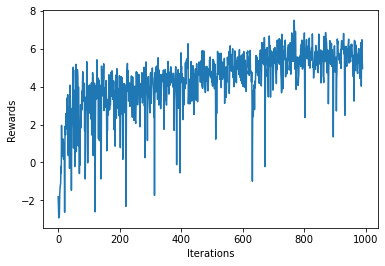

 99%|████████████████████████████████████████████████████████████████████████▎| 99105/100000 [1:06:42<00:33, 26.90it/s]

Updated Weights
Mean Reward = 5.38
12


 99%|████████████████████████████████████████████████████████████████████████▍| 99204/100000 [1:06:46<00:28, 27.65it/s]

Updated Weights
Mean Reward = 3.95
15


 99%|████████████████████████████████████████████████████████████████████████▍| 99306/100000 [1:06:49<00:26, 25.89it/s]

Updated Weights
Mean Reward = 6.68
10


 99%|████████████████████████████████████████████████████████████████████████▌| 99405/100000 [1:06:53<00:23, 25.39it/s]

Updated Weights
Mean Reward = 6.17
10


 99%|████████████████████████████████████████████████████████████████████████▋| 99498/100000 [1:06:56<00:18, 27.65it/s]

Updated Weights
Mean Reward = 6.28
11


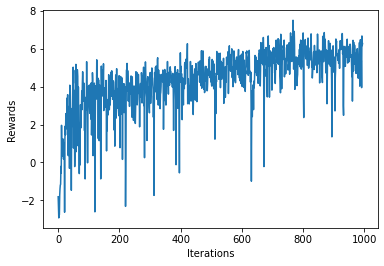

100%|████████████████████████████████████████████████████████████████████████▋| 99606/100000 [1:07:01<00:13, 28.35it/s]

Updated Weights
Mean Reward = 6.18
6


100%|████████████████████████████████████████████████████████████████████████▊| 99708/100000 [1:07:04<00:09, 31.82it/s]

Updated Weights
Mean Reward = 6.41
13


100%|████████████████████████████████████████████████████████████████████████▊| 99804/100000 [1:07:08<00:06, 28.85it/s]

Updated Weights
Mean Reward = 5.54
13


100%|████████████████████████████████████████████████████████████████████████▉| 99904/100000 [1:07:11<00:03, 28.19it/s]

Updated Weights
Mean Reward = 5.94
14


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:07:15<00:00, 24.78it/s]


In [6]:
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
    state = [start[0], start[1], dest[0], dest[1]]
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()

    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
#         assert(np.allclose(user_agent.target_model.get_weights(),user_agent.model.get_weights()))
        print('Updated Weights')
#     print(user_agent.model.get_weights())
        
    
    if epoch>50 and epoch%250==0:
        user_agent.epsilon*=0.9
        user_agent.epsilon = max(user_agent.epsilon, 0.1)

    mean_rewards.append(episode_reward)
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [7]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
#     start = np.array([0.1,0.1])
#     dest = np.array([0.1,0.3])
state = [start[0], start[1], dest[0], dest[1]]
while not done and step<max_steps:
    print(state)
    state = np.array(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1


[0.2, 0.4, 0.2, 0.7]
[0.2, 0.5, 0.2, 0.7]
[0.2, 0.6, 0.2, 0.7]


In [8]:
print(done)

1
